# **Downloading dataset**

In [0]:
!wget http://memorability.csail.mit.edu/lamem.tar.gz

--2019-12-05 18:07:21--  http://memorability.csail.mit.edu/lamem.tar.gz
Resolving memorability.csail.mit.edu (memorability.csail.mit.edu)... 128.30.195.49
Connecting to memorability.csail.mit.edu (memorability.csail.mit.edu)|128.30.195.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2708368436 (2.5G) [application/x-gzip]
Saving to: ‘lamem.tar.gz.1’

lamem.tar.gz.1      100%[===================>]   2.52G  31.9MB/s    in 82s     

2019-12-05 18:08:43 (31.5 MB/s) - ‘lamem.tar.gz.1’ saved [2708368436/2708368436]



In [0]:
!tar -xf /content/lamem.tar.gz

In [0]:
#total image in the folder
ls /content/lamem/images -1 | wc -l


58741


# **Necessary imports**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io,transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
import copy
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 'drive/My Drive'

'Colab Notebooks'		'face grouping'        'image memorability'
'face detection dataset WIDER'	'Getting started.pdf'   keras-facenet


# **Exploring the dataset**

In [0]:
columns={'name' : 'X' ,'score':'y'}
dataset = pd.read_csv("/content/drive/My Drive/image memorability/dataset/saved_file.csv")
dataset.rename(columns=columns,inplace=True)

In [0]:
dataset.head()

,X,y
0,00051110.jpg,0.675000
1,00016503.jpg,0.729167
2,00035805.jpg,0.930233
3,00009320.jpg,0.725000
4,00016469.jpg,0.825000


In [0]:
len(dataset)

58741

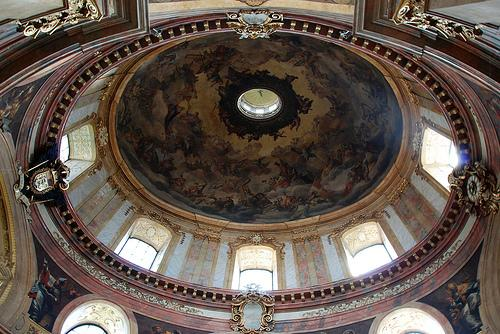

In [0]:
from IPython.display import Image
Image(filename="/content/lamem/images/00051110.jpg")

In [0]:
# #train validation split
# from sklearn.model_selection import train_test_split
# dataset_train,dataset_validation =train_test_split(dataset,test_size=0.2,random_state=2)

In [0]:
dataset_train = pd.read_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv")
dataset_validation = pd.read_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv")

In [0]:
len(dataset_train),len(dataset_validation)

(46992, 11749)

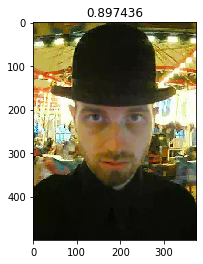

In [0]:
def show_sample_from_dataset(i=0):
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))
  image_path=os.path.join("/content/lamem/images/"+str(dataset_train.iloc[i]["X"]))
  mem_value = os.path.join(str(dataset_train.iloc[i]["y"]))
  show_image(io.imread(image_path),mem_value)
show_sample_from_dataset(7000)

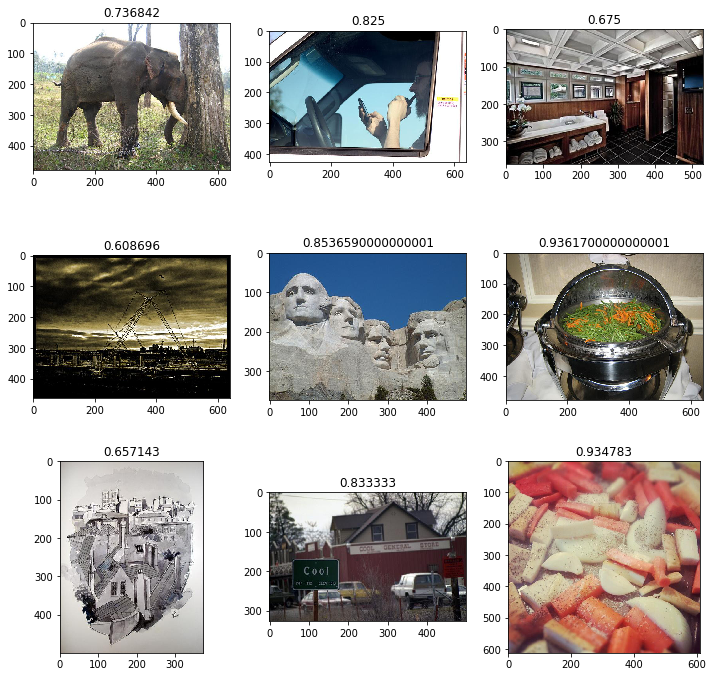

In [0]:

def show_grid(n_row,n_col):
  i=900
  _ ,fig = plt.subplots(n_row, n_col, figsize=(12,12))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("/content/lamem/images/"+str(dataset_train.iloc[i]["X"]))
    mem_value = os.path.join(str(dataset_train.iloc[i]["y"]))
    f.imshow(io.imread(image_path))
    f.title.set_text(str(mem_value))
#     f.title(str(aseth_value))
    i=i+1
show_grid(3,3)

# **Statistics**

In [0]:
dataset_train["y"].describe()

count    46992.000000
mean         0.755873
std          0.123970
min          0.200000
25%          0.675676
50%          0.770833
75%          0.848485
max          1.000000
Name: y, dtype: float64

In [0]:

dataset_validation["y"].describe()

count    11749.000000
mean         0.756625
std          0.123198
min          0.200000
25%          0.676471
50%          0.771429
75%          0.848485
max          1.000000
Name: y, dtype: float64

## **Data preprocessing**

In [0]:

class AsetheticsDataset(Dataset):
  '''asethitics dataset'''
  def __init__(self,dataframe,root_dir,transform=None):
    """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = dataframe
#     self.data.rename(columns=columns,inplace=True)
#     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
   
    if torch.is_tensor(idx):
      idx = idx.tolist()
   
    image_name =  os.path.join(self.root_dir,self.data.iloc[idx,0])
    image = io.imread(image_name)
    mem_val = self.data.iloc[idx,1]
#     return_sample={}
    return_sample = {
          'image':image,
          'memorability_score':mem_val 
    }
    if self.transform:
      return_sample = self.transform(return_sample)

     
    return return_sample

In [0]:

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image,mem_val = sample['image'], sample["memorability_score"]
        
        h, w = image.shape[:2]
        
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        #     new_h, new_w = self.output_size

        # new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size,self.output_size,3))
        return {'image': img, 'memorability_score': mem_val}

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image, mem_val = sample['image'], sample['memorability_score']
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
      
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}

In [0]:
class Normalize(object):
  def __init__(self,mean,std):
    self.mean=mean
    self.std=std
  def __call__(self,sample):
    image, mem_val = sample["image"], sample["memorability_score"]
    normalized=  (image -self.mean) / self.std
    return {
        "image":normalized,
        "memorability_score" : mem_val
    }

In [0]:

transformed_dataset_train = AsetheticsDataset(dataset_train,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

transformed_dataset_val= AsetheticsDataset(dataset_validation,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

In [0]:

train_dataloader=DataLoader(transformed_dataset_train,batch_size=128,shuffle=True)
validation_dataloader=DataLoader(transformed_dataset_val,batch_size=128,shuffle=True)

In [0]:
dataloaders={
    "train":train_dataloader,
    "val":validation_dataloader
}

In [0]:
dataset_sizes ={
    "train":len(dataset_train),
    "val":len(dataset_validation)
}

# **ResNet50**


In [0]:
model_50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.9MB/s]


In [0]:
# model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

# model_50 = model_50.double()

1


In [0]:

model_50 = model_50.double()
resmodel_50=copy.deepcopy(model_50)

In [0]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr = 0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:

# epochs = 5
# running_loss_history = []
# val_running_loss_history=[]

# for e in range(epochs):
#   running_loss=0.0
#   val_running_loss=0.0
#   for i,batched_data in enumerate(train_dataloader):
#     print(i)
#     inputs= batched_data["image"].to(device)
#     score = batched_data["memorability_score"].to(device)
#     score=score.view(-1,1)
#     score=score.double()
#     outputs = model(inputs)
#     loss = criterion(outputs,score)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     running_loss+=loss.item()
#     print(loss.item())
#   else:
#     with torch.no_grad():
#       for i,batched_val in enumerate(validation_dataloader):
#         val_inputs = batched_val["image"].to(device)
#         val_score = batched_val["memorability_score"].to(device)
#         val_score=val_score.view(-1,1)
#         val_score=val_score.double()
#         val_outputs = model(val_inputs)
#         val_loss = criterion(val_outputs,val_score)
#         val_running_loss+=val_loss.item()
# #         print(val_loss.item())
    
# #   epoch_loss
#     epoch_loss = running_loss/len(train_dataloader.dataset)
  
#     running_loss_history.append(epoch_loss)
    
#     val_epoch_loss = val_running_loss/len(validation_dataloader.dataset)
#     val_running_loss_history.append(val_epoch_loss)
    
#     print('epoch :', (e+1))
#     print('training loss: {:.4f}'.format(epoch_loss))
#     print('validation loss: {:.4f}'.format(val_epoch_loss))

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history=[]
    orignal_model=None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):
          
                inputs=batched_data["image"]
                inputs = inputs.to(device)
                labels=batched_data["memorability_score"]
                labels=labels.view(-1,1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ",loss.item())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
              running_loss_history.append(epoch_loss)
            else:
              val_running_loss_history.append(epoch_loss)
            

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            

            # deep copy the model
            if phase == 'val' and epoch_loss < low_loss:
            
                print("saving best model......")
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts,"/content/drive/My Drive/image memorability/saved models/resnet50_weights(2).pt")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    original_model =copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model,original_model,running_loss_history,val_running_loss_history

In [0]:
best_model_50,model_50,running_loss_history,val_running_loss_history = train_model(model_50,criterion,optimizer,exp_lr_scheduler,7)

sap={'epoch': epochs,
            'model_state_dict':best_model_50.state_dict(),
              'val_running_loss': val_running_loss_history,
            'running_loss_history':running_loss_history
    }
torch.save(sap, "/content/drive/My Drive/image memorability/bestmodel50(2).pt")

sap={'epoch': epochs,
            'model_state_dict':model_50.state_dict(),
              'val_running_loss': val_running_loss_history,
            'running_loss_history':running_loss_history
    }
torch.save(sap, "/content/drive/My Drive/image memorability/model50(2).pt")

  0%|          | 0/368 [00:00<?, ?it/s]

Epoch 0/6
----------


  0%|          | 1/368 [00:07<46:45,  7.64s/it]

  batch loss:     1.2738777598173616


  1%|          | 2/368 [00:15<46:12,  7.57s/it]

  batch loss:     1.0397469743597916


  1%|          | 3/368 [00:23<47:15,  7.77s/it]

  batch loss:     0.88765139922461


  1%|          | 4/368 [00:30<45:42,  7.53s/it]

  batch loss:     0.6963310812892044


  1%|▏         | 5/368 [00:37<44:49,  7.41s/it]

  batch loss:     0.6013242597494521


  2%|▏         | 6/368 [00:44<43:38,  7.23s/it]

  batch loss:     0.4667567704641167


  2%|▏         | 7/368 [00:52<45:12,  7.51s/it]

  batch loss:     0.35344505545970917


  2%|▏         | 8/368 [01:02<48:59,  8.17s/it]

  batch loss:     0.31010382920157


  2%|▏         | 9/368 [01:11<50:22,  8.42s/it]

  batch loss:     0.22805906935674122


  3%|▎         | 10/368 [01:19<50:01,  8.39s/it]

  batch loss:     0.15772792472577063


  3%|▎         | 11/368 [01:26<48:06,  8.09s/it]

  batch loss:     0.12926468703729585


  3%|▎         | 12/368 [01:33<46:04,  7.76s/it]

  batch loss:     0.10064926287856141


  4%|▎         | 13/368 [01:40<44:16,  7.48s/it]

  batch loss:     0.09537091551895768


  4%|▍         | 14/368 [01:50<48:27,  8.21s/it]

  batch loss:     0.07713550169464002


  4%|▍         | 15/368 [01:58<47:05,  8.00s/it]

  batch loss:     0.08718412811935318


  4%|▍         | 16/368 [02:07<49:02,  8.36s/it]

  batch loss:     0.08821430576928459


  5%|▍         | 17/368 [02:19<55:12,  9.44s/it]

  batch loss:     0.13525340928357685


  5%|▍         | 18/368 [02:26<52:08,  8.94s/it]

  batch loss:     0.10903323232273149


  5%|▌         | 19/368 [02:34<48:46,  8.38s/it]

  batch loss:     0.12828813597207422


  5%|▌         | 20/368 [02:41<46:37,  8.04s/it]

  batch loss:     0.13911094535744756


  6%|▌         | 21/368 [02:51<49:40,  8.59s/it]

  batch loss:     0.1643574128971605


  6%|▌         | 22/368 [03:01<53:15,  9.24s/it]

  batch loss:     0.16104214433649836


  6%|▋         | 23/368 [03:10<52:10,  9.07s/it]

  batch loss:     0.15002008217189236


  7%|▋         | 24/368 [03:17<48:54,  8.53s/it]

  batch loss:     0.1488706090517405


  7%|▋         | 25/368 [03:26<48:35,  8.50s/it]

  batch loss:     0.12832347634802327


  7%|▋         | 26/368 [03:34<48:36,  8.53s/it]

  batch loss:     0.1289903197790832


  7%|▋         | 27/368 [03:43<48:52,  8.60s/it]

  batch loss:     0.10615404954428898


  8%|▊         | 28/368 [03:51<47:29,  8.38s/it]

  batch loss:     0.11108553187090502


  8%|▊         | 29/368 [04:01<49:32,  8.77s/it]

  batch loss:     0.09951094957906337


  8%|▊         | 30/368 [04:08<47:13,  8.38s/it]

  batch loss:     0.10576262933049113


  8%|▊         | 31/368 [04:19<51:59,  9.26s/it]

  batch loss:     0.08175368545132448


  9%|▊         | 32/368 [04:27<48:44,  8.70s/it]

  batch loss:     0.08894915324275408


  9%|▉         | 33/368 [04:34<45:30,  8.15s/it]

  batch loss:     0.0766936857397649


  9%|▉         | 34/368 [04:41<43:57,  7.90s/it]

  batch loss:     0.08973753883977487


 10%|▉         | 35/368 [04:48<42:00,  7.57s/it]

  batch loss:     0.08081570784644901


 10%|▉         | 36/368 [04:56<42:19,  7.65s/it]

  batch loss:     0.075364142482819


 10%|█         | 37/368 [05:05<45:36,  8.27s/it]

  batch loss:     0.08267969646915593


 10%|█         | 38/368 [05:13<43:42,  7.95s/it]

  batch loss:     0.09446906067983704


 11%|█         | 39/368 [05:20<42:49,  7.81s/it]

  batch loss:     0.07202898680039174


 11%|█         | 40/368 [05:28<42:07,  7.70s/it]

  batch loss:     0.07284823651172717


 11%|█         | 41/368 [05:35<41:57,  7.70s/it]

  batch loss:     0.08032863125013057


 11%|█▏        | 42/368 [05:46<46:58,  8.65s/it]

  batch loss:     0.08329787821433969


 12%|█▏        | 43/368 [05:53<44:46,  8.26s/it]

  batch loss:     0.07765927465494143


 12%|█▏        | 44/368 [06:03<46:02,  8.53s/it]

  batch loss:     0.09084778943604704


 12%|█▏        | 45/368 [06:10<43:28,  8.08s/it]

  batch loss:     0.07200153634009743


 12%|█▎        | 46/368 [06:17<42:24,  7.90s/it]

  batch loss:     0.07257204120730637


 13%|█▎        | 47/368 [06:25<42:40,  7.98s/it]

  batch loss:     0.07934754542848739


 13%|█▎        | 48/368 [06:34<43:49,  8.22s/it]

  batch loss:     0.09066864714672734


 13%|█▎        | 49/368 [06:45<48:01,  9.03s/it]

  batch loss:     0.06431646696604479


 14%|█▎        | 50/368 [06:54<47:32,  8.97s/it]

  batch loss:     0.0847544731902403


 14%|█▍        | 51/368 [07:01<44:32,  8.43s/it]

  batch loss:     0.10184456070596949


 14%|█▍        | 52/368 [07:08<41:31,  7.88s/it]

  batch loss:     0.06202410860788496


 14%|█▍        | 53/368 [07:15<40:52,  7.78s/it]

  batch loss:     0.08345037927030527


 15%|█▍        | 54/368 [07:23<41:26,  7.92s/it]

  batch loss:     0.08524390760329739


 15%|█▍        | 55/368 [07:30<39:37,  7.60s/it]

  batch loss:     0.06637650116651622


 15%|█▌        | 56/368 [07:38<40:03,  7.70s/it]

  batch loss:     0.060741934397694514


 15%|█▌        | 57/368 [07:48<43:43,  8.44s/it]

  batch loss:     0.062324605957606735


 16%|█▌        | 58/368 [07:56<42:21,  8.20s/it]

  batch loss:     0.08296493331698276


 16%|█▌        | 59/368 [08:06<44:50,  8.71s/it]

  batch loss:     0.0714783660835171


 16%|█▋        | 60/368 [08:15<45:42,  8.90s/it]

  batch loss:     0.06952726867306976


 17%|█▋        | 61/368 [08:27<49:25,  9.66s/it]

  batch loss:     0.08046497715539838


 17%|█▋        | 62/368 [08:34<45:14,  8.87s/it]

  batch loss:     0.06766885728492422


 17%|█▋        | 63/368 [08:42<44:08,  8.68s/it]

  batch loss:     0.06477320606275369


 17%|█▋        | 64/368 [08:52<46:22,  9.15s/it]

  batch loss:     0.06076342889655676


 18%|█▊        | 65/368 [09:02<46:46,  9.26s/it]

  batch loss:     0.07300845402340425


 18%|█▊        | 66/368 [09:09<44:20,  8.81s/it]

  batch loss:     0.06103217676664411


 18%|█▊        | 67/368 [09:16<41:26,  8.26s/it]

  batch loss:     0.0629774476600908


 18%|█▊        | 68/368 [09:25<41:38,  8.33s/it]

  batch loss:     0.0687610705818752


 19%|█▉        | 69/368 [09:32<40:12,  8.07s/it]

  batch loss:     0.07280405249706512


 19%|█▉        | 70/368 [09:40<39:44,  8.00s/it]

  batch loss:     0.06952275550173316


 19%|█▉        | 71/368 [09:48<39:32,  7.99s/it]

  batch loss:     0.05625770175597383


 20%|█▉        | 72/368 [09:55<38:13,  7.75s/it]

  batch loss:     0.0738331645733833


 20%|█▉        | 73/368 [10:03<38:16,  7.78s/it]

  batch loss:     0.06054748576006904


 20%|██        | 74/368 [10:11<37:35,  7.67s/it]

  batch loss:     0.05662911694670129


 20%|██        | 75/368 [10:19<37:57,  7.77s/it]

  batch loss:     0.07196790995017847


 21%|██        | 76/368 [10:25<36:22,  7.47s/it]

  batch loss:     0.06161711185712364


 21%|██        | 77/368 [10:33<35:59,  7.42s/it]

  batch loss:     0.07131080508972984


 21%|██        | 78/368 [10:41<37:13,  7.70s/it]

  batch loss:     0.06275945503274279


 21%|██▏       | 79/368 [10:49<37:36,  7.81s/it]

  batch loss:     0.06888767065401874


 22%|██▏       | 80/368 [10:57<37:35,  7.83s/it]

  batch loss:     0.06659405827654019


 22%|██▏       | 81/368 [11:06<38:42,  8.09s/it]

  batch loss:     0.05968705737863583


 22%|██▏       | 82/368 [11:15<40:16,  8.45s/it]

  batch loss:     0.06777169037741396


 23%|██▎       | 83/368 [11:23<39:36,  8.34s/it]

  batch loss:     0.06039274464223531


 23%|██▎       | 84/368 [11:31<38:12,  8.07s/it]

  batch loss:     0.07281873289726534


 23%|██▎       | 85/368 [11:39<39:08,  8.30s/it]

  batch loss:     0.060378775869059625


 23%|██▎       | 86/368 [11:47<38:39,  8.23s/it]

  batch loss:     0.04206946630185253


 24%|██▎       | 87/368 [11:57<40:00,  8.54s/it]

  batch loss:     0.05452650440978126


 24%|██▍       | 88/368 [12:03<37:22,  8.01s/it]

  batch loss:     0.06655048801148722


 24%|██▍       | 89/368 [12:11<36:58,  7.95s/it]

  batch loss:     0.06297761929517318


 24%|██▍       | 90/368 [12:21<39:12,  8.46s/it]

  batch loss:     0.06728747057015078


 25%|██▍       | 91/368 [12:30<39:17,  8.51s/it]

  batch loss:     0.05795485291596502


 25%|██▌       | 92/368 [12:38<39:03,  8.49s/it]

  batch loss:     0.05403576918916614


 25%|██▌       | 93/368 [12:48<40:46,  8.90s/it]

  batch loss:     0.07236931189102053


 26%|██▌       | 94/368 [12:56<39:12,  8.59s/it]

  batch loss:     0.06507473269453942


 26%|██▌       | 95/368 [13:07<42:31,  9.35s/it]

  batch loss:     0.055630698507509055


 26%|██▌       | 96/368 [13:15<41:06,  9.07s/it]

  batch loss:     0.06816644116633283


 26%|██▋       | 97/368 [13:22<37:57,  8.40s/it]

  batch loss:     0.0577230040942823


 27%|██▋       | 98/368 [13:29<35:47,  7.95s/it]

  batch loss:     0.06500514970722643


 27%|██▋       | 99/368 [13:37<36:14,  8.08s/it]

  batch loss:     0.07241066566339292


 27%|██▋       | 100/368 [13:45<35:44,  8.00s/it]

  batch loss:     0.0578061313944005


 27%|██▋       | 101/368 [13:54<37:14,  8.37s/it]

  batch loss:     0.0585029932954898


 28%|██▊       | 102/368 [14:04<38:34,  8.70s/it]

  batch loss:     0.061432525486480455


 28%|██▊       | 103/368 [14:15<42:02,  9.52s/it]

  batch loss:     0.05222096345965295


 28%|██▊       | 104/368 [14:22<38:07,  8.66s/it]

  batch loss:     0.06924481612444684


 29%|██▊       | 105/368 [14:29<35:39,  8.14s/it]

  batch loss:     0.06488001334780788


 29%|██▉       | 106/368 [14:36<34:20,  7.86s/it]

  batch loss:     0.058245233618445844


 29%|██▉       | 107/368 [14:47<38:35,  8.87s/it]

  batch loss:     0.05621081979601751


 29%|██▉       | 108/368 [14:55<36:26,  8.41s/it]

  batch loss:     0.061973429429761064


 30%|██▉       | 109/368 [15:03<36:39,  8.49s/it]

  batch loss:     0.054586134872255984


 30%|██▉       | 110/368 [15:11<35:51,  8.34s/it]

  batch loss:     0.05186006710543345


 30%|███       | 111/368 [15:18<33:57,  7.93s/it]

  batch loss:     0.05238467006516529


 30%|███       | 112/368 [15:28<35:46,  8.39s/it]

  batch loss:     0.05756773025786807


 31%|███       | 113/368 [15:35<34:46,  8.18s/it]

  batch loss:     0.05213906721072742


 31%|███       | 114/368 [15:43<33:47,  7.98s/it]

  batch loss:     0.06348193142588879


 31%|███▏      | 115/368 [15:51<33:52,  8.03s/it]

  batch loss:     0.05010049637210463


 32%|███▏      | 116/368 [15:59<33:54,  8.07s/it]

  batch loss:     0.06601706699299978


 32%|███▏      | 117/368 [16:09<36:24,  8.70s/it]

  batch loss:     0.04794194860483893


 32%|███▏      | 118/368 [16:17<34:38,  8.31s/it]

  batch loss:     0.06463343284400944


 32%|███▏      | 119/368 [16:24<32:39,  7.87s/it]

  batch loss:     0.04335444656730653


 33%|███▎      | 120/368 [16:31<31:19,  7.58s/it]

  batch loss:     0.047769237951479235


 33%|███▎      | 121/368 [16:37<30:07,  7.32s/it]

  batch loss:     0.05918724579629149


 33%|███▎      | 122/368 [16:45<31:00,  7.56s/it]

  batch loss:     0.06370497556481562


 33%|███▎      | 123/368 [16:52<30:06,  7.37s/it]

  batch loss:     0.050016544238145125


 34%|███▎      | 124/368 [17:01<30:57,  7.61s/it]

  batch loss:     0.057718896548406146


 34%|███▍      | 125/368 [17:09<31:39,  7.81s/it]

  batch loss:     0.05576288978392717


 34%|███▍      | 126/368 [17:16<31:19,  7.77s/it]

  batch loss:     0.05455840294522284


 35%|███▍      | 127/368 [17:26<33:24,  8.32s/it]

  batch loss:     0.056929972554100795


 35%|███▍      | 128/368 [17:33<31:21,  7.84s/it]

  batch loss:     0.050440743725088846


 35%|███▌      | 129/368 [17:40<30:50,  7.74s/it]

  batch loss:     0.049524179998239375


 35%|███▌      | 130/368 [17:48<30:09,  7.60s/it]

  batch loss:     0.05832580517859526


 36%|███▌      | 131/368 [17:55<29:29,  7.47s/it]

  batch loss:     0.05086802467276973


 36%|███▌      | 132/368 [18:02<28:52,  7.34s/it]

  batch loss:     0.04780264737542031


 36%|███▌      | 133/368 [18:09<28:28,  7.27s/it]

  batch loss:     0.06695928885401331


 36%|███▋      | 134/368 [18:17<29:05,  7.46s/it]

  batch loss:     0.04115068075343656


 37%|███▋      | 135/368 [18:28<33:43,  8.68s/it]

  batch loss:     0.042376276695879636


 37%|███▋      | 136/368 [18:35<31:43,  8.20s/it]

  batch loss:     0.047329275162527676


 37%|███▋      | 137/368 [18:43<30:49,  8.01s/it]

  batch loss:     0.05494394800457622


 38%|███▊      | 138/368 [18:50<29:41,  7.74s/it]

  batch loss:     0.05136462874258851


 38%|███▊      | 139/368 [18:57<29:07,  7.63s/it]

  batch loss:     0.049335714901144724


 38%|███▊      | 140/368 [19:05<28:59,  7.63s/it]

  batch loss:     0.0608942600227047


 38%|███▊      | 141/368 [19:13<28:52,  7.63s/it]

  batch loss:     0.06253907497237512


 39%|███▊      | 142/368 [19:20<28:21,  7.53s/it]

  batch loss:     0.0433550440294236


 39%|███▉      | 143/368 [19:28<28:57,  7.72s/it]

  batch loss:     0.03682345680417085


 39%|███▉      | 144/368 [19:36<28:57,  7.76s/it]

  batch loss:     0.045200654764426994


 39%|███▉      | 145/368 [19:43<27:58,  7.53s/it]

  batch loss:     0.057371260561897355


 40%|███▉      | 146/368 [19:50<27:26,  7.42s/it]

  batch loss:     0.05369413944308253


 40%|███▉      | 147/368 [19:57<27:04,  7.35s/it]

  batch loss:     0.0509793080915486


 40%|████      | 148/368 [20:05<27:22,  7.47s/it]

  batch loss:     0.05578238686673258


 40%|████      | 149/368 [20:14<29:05,  7.97s/it]

  batch loss:     0.054650918933495926


 41%|████      | 150/368 [20:21<27:49,  7.66s/it]

  batch loss:     0.047608015047562


 41%|████      | 151/368 [20:29<27:53,  7.71s/it]

  batch loss:     0.047281281841522346


 41%|████▏     | 152/368 [20:36<27:11,  7.55s/it]

  batch loss:     0.05072718598786827


 42%|████▏     | 153/368 [20:44<26:55,  7.51s/it]

  batch loss:     0.04162547829033307


 42%|████▏     | 154/368 [20:51<26:18,  7.38s/it]

  batch loss:     0.04678635511342817


 42%|████▏     | 155/368 [21:02<30:43,  8.66s/it]

  batch loss:     0.0535027561635909


 42%|████▏     | 156/368 [21:09<28:39,  8.11s/it]

  batch loss:     0.043818399518999546


 43%|████▎     | 157/368 [21:17<28:40,  8.15s/it]

  batch loss:     0.04701842709578008


 43%|████▎     | 158/368 [21:26<29:09,  8.33s/it]

  batch loss:     0.04099565915880858


 43%|████▎     | 159/368 [21:36<30:32,  8.77s/it]

  batch loss:     0.044005790347583826


 43%|████▎     | 160/368 [21:43<28:22,  8.18s/it]

  batch loss:     0.05286374194177086


 44%|████▍     | 161/368 [21:50<27:31,  7.98s/it]

  batch loss:     0.049261710655658715


 44%|████▍     | 162/368 [21:57<26:23,  7.69s/it]

  batch loss:     0.04666643651700427


 44%|████▍     | 163/368 [22:05<26:21,  7.71s/it]

  batch loss:     0.044380297981994964


 45%|████▍     | 164/368 [22:13<25:58,  7.64s/it]

  batch loss:     0.044679174364580417


 45%|████▍     | 165/368 [22:22<27:30,  8.13s/it]

  batch loss:     0.03766720588767053


 45%|████▌     | 166/368 [22:29<26:50,  7.97s/it]

  batch loss:     0.04718045152560422


 45%|████▌     | 167/368 [22:37<26:17,  7.85s/it]

  batch loss:     0.041468261875777956


 46%|████▌     | 168/368 [22:44<25:06,  7.53s/it]

  batch loss:     0.044420757515281725


 46%|████▌     | 169/368 [22:52<25:56,  7.82s/it]

  batch loss:     0.04325246159081296


 46%|████▌     | 170/368 [22:59<24:54,  7.55s/it]

  batch loss:     0.05633576841378302


 46%|████▋     | 171/368 [23:08<25:42,  7.83s/it]

  batch loss:     0.05315738621090019


 47%|████▋     | 172/368 [23:19<28:44,  8.80s/it]

  batch loss:     0.046706313122500696


 47%|████▋     | 173/368 [23:27<27:41,  8.52s/it]

  batch loss:     0.04317581454625594


 47%|████▋     | 174/368 [23:35<27:13,  8.42s/it]

  batch loss:     0.056965593416889476


 48%|████▊     | 175/368 [23:45<28:54,  8.99s/it]

  batch loss:     0.03896140189400262


 48%|████▊     | 176/368 [23:53<27:16,  8.52s/it]

  batch loss:     0.05512278395564495


 48%|████▊     | 177/368 [24:00<26:04,  8.19s/it]

  batch loss:     0.041134190772161114


 48%|████▊     | 178/368 [24:11<28:34,  9.02s/it]

  batch loss:     0.05247618735720157


 49%|████▊     | 179/368 [24:18<26:33,  8.43s/it]

  batch loss:     0.04143981417541672


 49%|████▉     | 180/368 [24:26<26:00,  8.30s/it]

  batch loss:     0.04006455136631712


 49%|████▉     | 181/368 [24:33<24:20,  7.81s/it]

  batch loss:     0.055028636831385896


 49%|████▉     | 182/368 [24:41<24:29,  7.90s/it]

  batch loss:     0.048350610823643995


 50%|████▉     | 183/368 [24:49<24:36,  7.98s/it]

  batch loss:     0.052173023698134466


 50%|█████     | 184/368 [24:56<23:45,  7.75s/it]

  batch loss:     0.04344200426398147


 50%|█████     | 185/368 [25:08<27:23,  8.98s/it]

  batch loss:     0.04610860455270369


 51%|█████     | 186/368 [25:19<29:30,  9.73s/it]

  batch loss:     0.046624621979982656


 51%|█████     | 187/368 [25:27<27:06,  8.99s/it]

  batch loss:     0.04791813414434207


 51%|█████     | 188/368 [25:34<25:20,  8.45s/it]

  batch loss:     0.04916091543374622


 51%|█████▏    | 189/368 [25:41<24:11,  8.11s/it]

  batch loss:     0.038578290136224866


 52%|█████▏    | 190/368 [25:50<24:15,  8.18s/it]

  batch loss:     0.043059796456210386


 52%|█████▏    | 191/368 [25:56<22:58,  7.79s/it]

  batch loss:     0.042289183970270317


 52%|█████▏    | 192/368 [26:06<24:17,  8.28s/it]

  batch loss:     0.04775886121425957


 52%|█████▏    | 193/368 [26:14<23:48,  8.16s/it]

  batch loss:     0.044997894549160984


 53%|█████▎    | 194/368 [26:25<26:39,  9.19s/it]

  batch loss:     0.05187855186158659


 53%|█████▎    | 195/368 [26:33<25:09,  8.72s/it]

  batch loss:     0.041453051039001015


 53%|█████▎    | 196/368 [26:45<27:41,  9.66s/it]

  batch loss:     0.04481836380465232


 54%|█████▎    | 197/368 [26:52<25:05,  8.80s/it]

  batch loss:     0.04506370570054334


 54%|█████▍    | 198/368 [26:59<23:38,  8.34s/it]

  batch loss:     0.04211474824302541


 54%|█████▍    | 199/368 [27:07<23:24,  8.31s/it]

  batch loss:     0.03970358584907946


 54%|█████▍    | 200/368 [27:15<22:34,  8.07s/it]

  batch loss:     0.0472509077523721


 55%|█████▍    | 201/368 [27:27<26:23,  9.48s/it]

  batch loss:     0.03844764700433283


 55%|█████▍    | 202/368 [27:36<25:11,  9.11s/it]

  batch loss:     0.040001279187257176


 55%|█████▌    | 203/368 [27:43<23:31,  8.55s/it]

  batch loss:     0.04796811586656914


 55%|█████▌    | 204/368 [27:51<23:14,  8.51s/it]

  batch loss:     0.046509436316758426


 56%|█████▌    | 205/368 [28:01<23:49,  8.77s/it]

  batch loss:     0.049012116864423236


 56%|█████▌    | 206/368 [28:08<22:49,  8.46s/it]

  batch loss:     0.04404849230494443


 56%|█████▋    | 207/368 [28:15<21:31,  8.02s/it]

  batch loss:     0.04457502483766845


 57%|█████▋    | 208/368 [28:24<21:53,  8.21s/it]

  batch loss:     0.029006672105010484


 57%|█████▋    | 209/368 [28:31<20:47,  7.84s/it]

  batch loss:     0.04090782280045818


 57%|█████▋    | 210/368 [28:38<19:46,  7.51s/it]

  batch loss:     0.04077387171338087


 57%|█████▋    | 211/368 [28:46<19:52,  7.59s/it]

  batch loss:     0.04295658605424921


 58%|█████▊    | 212/368 [28:54<20:27,  7.87s/it]

  batch loss:     0.04477618145478594


 58%|█████▊    | 213/368 [29:03<20:52,  8.08s/it]

  batch loss:     0.043781829559828025


 58%|█████▊    | 214/368 [29:12<21:25,  8.35s/it]

  batch loss:     0.039765463128948


 58%|█████▊    | 215/368 [29:19<20:12,  7.93s/it]

  batch loss:     0.05454639391164537


 59%|█████▊    | 216/368 [29:25<19:11,  7.57s/it]

  batch loss:     0.039471604180640406


 59%|█████▉    | 217/368 [29:33<18:56,  7.53s/it]

  batch loss:     0.047253031145898836


 59%|█████▉    | 218/368 [29:44<21:37,  8.65s/it]

  batch loss:     0.03274776779572581


 60%|█████▉    | 219/368 [29:51<20:29,  8.25s/it]

  batch loss:     0.028078966354374672


 60%|█████▉    | 220/368 [30:00<20:59,  8.51s/it]

  batch loss:     0.0378791862637475


 60%|██████    | 221/368 [30:10<21:44,  8.87s/it]

  batch loss:     0.030483622891468193


 60%|██████    | 222/368 [30:18<20:35,  8.46s/it]

  batch loss:     0.04295720664597656


 61%|██████    | 223/368 [30:26<20:10,  8.35s/it]

  batch loss:     0.03824346702579462


 61%|██████    | 224/368 [30:33<19:32,  8.14s/it]

  batch loss:     0.04232122891483648


 61%|██████    | 225/368 [30:41<18:52,  7.92s/it]

  batch loss:     0.04684408406568592


 61%|██████▏   | 226/368 [30:50<19:22,  8.18s/it]

  batch loss:     0.04470771437846575


 62%|██████▏   | 227/368 [31:00<20:38,  8.78s/it]

  batch loss:     0.056607472967560885


 62%|██████▏   | 228/368 [31:07<19:30,  8.36s/it]

  batch loss:     0.03887883396849812


 62%|██████▏   | 229/368 [31:14<18:22,  7.93s/it]

  batch loss:     0.039304007975952425


 62%|██████▎   | 230/368 [31:28<22:17,  9.69s/it]

  batch loss:     0.04807291298376111


 63%|██████▎   | 231/368 [31:35<20:27,  8.96s/it]

  batch loss:     0.03934510246904599


 63%|██████▎   | 232/368 [31:42<19:06,  8.43s/it]

  batch loss:     0.044610753251376964


 63%|██████▎   | 233/368 [31:54<21:25,  9.52s/it]

  batch loss:     0.040784715499316976


 64%|██████▎   | 234/368 [32:02<19:53,  8.91s/it]

  batch loss:     0.0428350902640664


 64%|██████▍   | 235/368 [32:09<18:47,  8.47s/it]

  batch loss:     0.037319386752469486


 64%|██████▍   | 236/368 [32:20<20:13,  9.19s/it]

  batch loss:     0.04243019416357716


 64%|██████▍   | 237/368 [32:29<19:36,  8.98s/it]

  batch loss:     0.04526788802623116


 65%|██████▍   | 238/368 [32:36<18:15,  8.43s/it]

  batch loss:     0.040967948228471815


 65%|██████▍   | 239/368 [32:44<17:52,  8.31s/it]

  batch loss:     0.040382093612522665


 65%|██████▌   | 240/368 [32:55<19:13,  9.01s/it]

  batch loss:     0.03309614193415414


 65%|██████▌   | 241/368 [33:02<17:48,  8.41s/it]

  batch loss:     0.04111114928612602


 66%|██████▌   | 242/368 [33:09<16:48,  8.00s/it]

  batch loss:     0.040724923301977856


 66%|██████▌   | 243/368 [33:17<16:56,  8.13s/it]

  batch loss:     0.03709478077665468


 66%|██████▋   | 244/368 [33:24<16:19,  7.90s/it]

  batch loss:     0.04657647470205589


 67%|██████▋   | 245/368 [33:31<15:42,  7.66s/it]

  batch loss:     0.04671800399108024


 67%|██████▋   | 246/368 [33:40<16:13,  7.98s/it]

  batch loss:     0.03432542581930459


 67%|██████▋   | 247/368 [33:49<16:22,  8.12s/it]

  batch loss:     0.04541637673288535


 67%|██████▋   | 248/368 [33:56<15:37,  7.81s/it]

  batch loss:     0.03236742931648141


 68%|██████▊   | 249/368 [34:03<14:56,  7.53s/it]

  batch loss:     0.03960067845162646


 68%|██████▊   | 250/368 [34:12<16:11,  8.23s/it]

  batch loss:     0.03381278448782888


 68%|██████▊   | 251/368 [34:19<15:19,  7.86s/it]

  batch loss:     0.03460055234549789


 68%|██████▊   | 252/368 [34:27<14:51,  7.69s/it]

  batch loss:     0.042525000597873154


 69%|██████▉   | 253/368 [34:38<16:33,  8.64s/it]

  batch loss:     0.04152364080033504


 69%|██████▉   | 254/368 [34:44<15:18,  8.06s/it]

  batch loss:     0.03887862556905773


 69%|██████▉   | 255/368 [34:51<14:39,  7.78s/it]

  batch loss:     0.041287394106034256


 70%|██████▉   | 256/368 [34:59<14:31,  7.78s/it]

  batch loss:     0.04019935389389981


 70%|██████▉   | 257/368 [35:07<14:13,  7.69s/it]

  batch loss:     0.042431987900677745


 70%|███████   | 258/368 [35:14<13:47,  7.52s/it]

  batch loss:     0.04547585381937965


 70%|███████   | 259/368 [35:21<13:25,  7.39s/it]

  batch loss:     0.04713353235000489


 71%|███████   | 260/368 [35:29<13:51,  7.70s/it]

  batch loss:     0.04102974075276769


 71%|███████   | 261/368 [35:36<13:22,  7.50s/it]

  batch loss:     0.038712154203917534


 71%|███████   | 262/368 [35:46<14:10,  8.02s/it]

  batch loss:     0.03724607434366324


 71%|███████▏  | 263/368 [35:53<13:45,  7.86s/it]

  batch loss:     0.03731739047570711


 72%|███████▏  | 264/368 [36:01<13:53,  8.02s/it]

  batch loss:     0.04057650402732337


 72%|███████▏  | 265/368 [36:09<13:25,  7.82s/it]

  batch loss:     0.03444270448085354


 72%|███████▏  | 266/368 [36:16<12:49,  7.55s/it]

  batch loss:     0.03639903464365509


 73%|███████▎  | 267/368 [36:23<12:27,  7.41s/it]

  batch loss:     0.031269580656319546


 73%|███████▎  | 268/368 [36:32<13:25,  8.06s/it]

  batch loss:     0.03295512717634275


 73%|███████▎  | 269/368 [36:41<13:41,  8.30s/it]

  batch loss:     0.03887505641809639


 73%|███████▎  | 270/368 [36:49<13:03,  7.99s/it]

  batch loss:     0.0377012748897311


 74%|███████▎  | 271/368 [36:55<12:20,  7.63s/it]

  batch loss:     0.0443610780529136


 74%|███████▍  | 272/368 [37:04<12:57,  8.10s/it]

  batch loss:     0.032577352765669455


 74%|███████▍  | 273/368 [37:14<13:17,  8.39s/it]

  batch loss:     0.036971949032157954


 74%|███████▍  | 274/368 [37:20<12:21,  7.89s/it]

  batch loss:     0.034664382766282545


 75%|███████▍  | 275/368 [37:29<12:42,  8.20s/it]

  batch loss:     0.03413591947603047


 75%|███████▌  | 276/368 [37:36<12:02,  7.85s/it]

  batch loss:     0.028747539973146323


 75%|███████▌  | 277/368 [37:43<11:36,  7.66s/it]

  batch loss:     0.0320977931516873


 76%|███████▌  | 278/368 [37:57<14:00,  9.34s/it]

  batch loss:     0.04170676631567209


 76%|███████▌  | 279/368 [38:06<13:44,  9.27s/it]

  batch loss:     0.03438556962502664


 76%|███████▌  | 280/368 [38:13<12:43,  8.68s/it]

  batch loss:     0.037334495356522265


 76%|███████▋  | 281/368 [38:20<11:44,  8.10s/it]

  batch loss:     0.028559106820122703


 77%|███████▋  | 282/368 [38:28<11:25,  7.98s/it]

  batch loss:     0.03490851075647232


 77%|███████▋  | 283/368 [38:35<11:10,  7.89s/it]

  batch loss:     0.03933991091005781


 77%|███████▋  | 284/368 [38:42<10:40,  7.62s/it]

  batch loss:     0.03300381013317467


 77%|███████▋  | 285/368 [38:51<11:11,  8.10s/it]

  batch loss:     0.03546985176167758


 78%|███████▊  | 286/368 [38:59<10:52,  7.96s/it]

  batch loss:     0.031490566017239596


 78%|███████▊  | 287/368 [39:06<10:18,  7.64s/it]

  batch loss:     0.03161823711368682


 78%|███████▊  | 288/368 [39:14<10:25,  7.81s/it]

  batch loss:     0.036252425987460764


 79%|███████▊  | 289/368 [39:23<10:33,  8.02s/it]

  batch loss:     0.03540079682737027


 79%|███████▉  | 290/368 [39:32<11:03,  8.51s/it]

  batch loss:     0.029001084725911758


 79%|███████▉  | 291/368 [39:40<10:28,  8.16s/it]

  batch loss:     0.03704983353566649


 79%|███████▉  | 292/368 [39:48<10:23,  8.20s/it]

  batch loss:     0.030382926235071106


 80%|███████▉  | 293/368 [39:55<09:39,  7.72s/it]

  batch loss:     0.041333142732623764


 80%|███████▉  | 294/368 [40:03<09:39,  7.83s/it]

  batch loss:     0.0387974297728279


 80%|████████  | 295/368 [40:12<10:07,  8.32s/it]

  batch loss:     0.03747661440264125


 80%|████████  | 296/368 [40:20<10:00,  8.33s/it]

  batch loss:     0.032151790476716464


 81%|████████  | 297/368 [40:31<10:32,  8.90s/it]

  batch loss:     0.043037599707508964


 81%|████████  | 298/368 [40:39<10:04,  8.63s/it]

  batch loss:     0.03950306834791561


 81%|████████▏ | 299/368 [40:48<10:04,  8.76s/it]

  batch loss:     0.0354159506406607


 82%|████████▏ | 300/368 [40:56<09:40,  8.53s/it]

  batch loss:     0.039554560659461516


 82%|████████▏ | 301/368 [41:04<09:31,  8.54s/it]

  batch loss:     0.03077082677961847


 82%|████████▏ | 302/368 [41:12<09:03,  8.24s/it]

  batch loss:     0.03519196988763017


 82%|████████▏ | 303/368 [41:19<08:33,  7.90s/it]

  batch loss:     0.039706692134704985


 83%|████████▎ | 304/368 [41:26<08:13,  7.71s/it]

  batch loss:     0.031151097820234036


 83%|████████▎ | 305/368 [41:33<07:53,  7.51s/it]

  batch loss:     0.03978236835302114


 83%|████████▎ | 306/368 [41:41<07:43,  7.48s/it]

  batch loss:     0.028986208160013266


 83%|████████▎ | 307/368 [41:48<07:24,  7.28s/it]

  batch loss:     0.036092946795721975


 84%|████████▎ | 308/368 [41:54<07:11,  7.19s/it]

  batch loss:     0.030091961920095903


 84%|████████▍ | 309/368 [42:03<07:27,  7.59s/it]

  batch loss:     0.036775826736468724


 84%|████████▍ | 310/368 [42:13<07:58,  8.24s/it]

  batch loss:     0.035750720244574236


 85%|████████▍ | 311/368 [42:20<07:39,  8.06s/it]

  batch loss:     0.03693540656245561


 85%|████████▍ | 312/368 [42:28<07:27,  7.99s/it]

  batch loss:     0.03683401948168109


 85%|████████▌ | 313/368 [42:39<07:59,  8.72s/it]

  batch loss:     0.03239196358311115


 85%|████████▌ | 314/368 [42:46<07:21,  8.18s/it]

  batch loss:     0.03207413251795589


 86%|████████▌ | 315/368 [42:56<07:47,  8.81s/it]

  batch loss:     0.030240890022556473


 86%|████████▌ | 316/368 [43:03<07:16,  8.40s/it]

  batch loss:     0.02841059854564107


 86%|████████▌ | 317/368 [43:13<07:35,  8.93s/it]

  batch loss:     0.03369758959609269


 86%|████████▋ | 318/368 [43:20<06:57,  8.35s/it]

  batch loss:     0.04479554805206245


 87%|████████▋ | 319/368 [43:27<06:27,  7.90s/it]

  batch loss:     0.03655492189942336


 87%|████████▋ | 320/368 [43:35<06:15,  7.81s/it]

  batch loss:     0.037907522454213145


 87%|████████▋ | 321/368 [43:44<06:25,  8.21s/it]

  batch loss:     0.03308408296846599


 88%|████████▊ | 322/368 [43:53<06:22,  8.31s/it]

  batch loss:     0.03721550391095499


 88%|████████▊ | 323/368 [44:00<05:57,  7.94s/it]

  batch loss:     0.038293973310603246


 88%|████████▊ | 324/368 [44:07<05:37,  7.67s/it]

  batch loss:     0.03735043195152482


 88%|████████▊ | 325/368 [44:15<05:33,  7.75s/it]

  batch loss:     0.028099013311645195


 89%|████████▊ | 326/368 [44:24<05:50,  8.35s/it]

  batch loss:     0.03514037022235407


 89%|████████▉ | 327/368 [44:31<05:20,  7.83s/it]

  batch loss:     0.02307601572268057


 89%|████████▉ | 328/368 [44:39<05:15,  7.88s/it]

  batch loss:     0.03309427877134482


 89%|████████▉ | 329/368 [44:48<05:22,  8.28s/it]

  batch loss:     0.03956502243521201


 90%|████████▉ | 330/368 [44:55<04:57,  7.83s/it]

  batch loss:     0.0322218497047908


 90%|████████▉ | 331/368 [45:03<04:49,  7.83s/it]

  batch loss:     0.03420450435756091


 90%|█████████ | 332/368 [45:11<04:43,  7.87s/it]

  batch loss:     0.030707614202325595


 90%|█████████ | 333/368 [45:18<04:31,  7.76s/it]

  batch loss:     0.032031870428919786


 91%|█████████ | 334/368 [45:27<04:29,  7.92s/it]

  batch loss:     0.028263375824774912


 91%|█████████ | 335/368 [45:36<04:40,  8.50s/it]

  batch loss:     0.03793793845580634


 91%|█████████▏| 336/368 [45:43<04:17,  8.04s/it]

  batch loss:     0.031921743069723035


 92%|█████████▏| 337/368 [45:52<04:16,  8.28s/it]

  batch loss:     0.029827131329170406


 92%|█████████▏| 338/368 [45:59<03:57,  7.91s/it]

  batch loss:     0.03728047513947858


 92%|█████████▏| 339/368 [46:06<03:39,  7.58s/it]

  batch loss:     0.032274905764810596


 92%|█████████▏| 340/368 [46:14<03:35,  7.69s/it]

  batch loss:     0.032817844800143506


 93%|█████████▎| 341/368 [46:22<03:32,  7.88s/it]

  batch loss:     0.03463897130358855


 93%|█████████▎| 342/368 [46:35<04:04,  9.42s/it]

  batch loss:     0.035391822209826965


 93%|█████████▎| 343/368 [46:43<03:39,  8.78s/it]

  batch loss:     0.03817353917179761


 93%|█████████▎| 344/368 [46:50<03:23,  8.47s/it]

  batch loss:     0.03024563053122554


 94%|█████████▍| 345/368 [47:00<03:21,  8.75s/it]

  batch loss:     0.03923472528559517


 94%|█████████▍| 346/368 [47:09<03:16,  8.94s/it]

  batch loss:     0.03333300550825896


 94%|█████████▍| 347/368 [47:19<03:11,  9.14s/it]

  batch loss:     0.02936593847915229


 95%|█████████▍| 348/368 [47:30<03:13,  9.66s/it]

  batch loss:     0.03586975342404829


 95%|█████████▍| 349/368 [47:38<02:55,  9.24s/it]

  batch loss:     0.027013663629606575


 95%|█████████▌| 350/368 [47:48<02:48,  9.39s/it]

  batch loss:     0.036645656471940326


 95%|█████████▌| 351/368 [47:59<02:48,  9.91s/it]

  batch loss:     0.03575521367769209


 96%|█████████▌| 352/368 [48:11<02:47, 10.50s/it]

  batch loss:     0.03478519583394163


 96%|█████████▌| 353/368 [48:19<02:27,  9.84s/it]

  batch loss:     0.03440362296267442


 96%|█████████▌| 354/368 [48:26<02:04,  8.88s/it]

  batch loss:     0.030917887084404953


 96%|█████████▋| 355/368 [48:35<01:57,  9.04s/it]

  batch loss:     0.030883278186101547


 97%|█████████▋| 356/368 [48:42<01:40,  8.40s/it]

  batch loss:     0.026987287319435685


 97%|█████████▋| 357/368 [48:52<01:36,  8.73s/it]

  batch loss:     0.032045529091951255


 97%|█████████▋| 358/368 [48:59<01:22,  8.26s/it]

  batch loss:     0.027819344768363254


 98%|█████████▊| 359/368 [49:06<01:11,  7.89s/it]

  batch loss:     0.03556923440303927


 98%|█████████▊| 360/368 [49:13<01:00,  7.62s/it]

  batch loss:     0.032634665769789614


 98%|█████████▊| 361/368 [49:22<00:57,  8.23s/it]

  batch loss:     0.03291963908697851


 98%|█████████▊| 362/368 [49:30<00:48,  8.05s/it]

  batch loss:     0.024546235075564256


 99%|█████████▊| 363/368 [49:38<00:40,  8.02s/it]

  batch loss:     0.03573388180211578


 99%|█████████▉| 364/368 [49:44<00:30,  7.59s/it]

  batch loss:     0.026163339383197162


 99%|█████████▉| 365/368 [49:54<00:24,  8.10s/it]

  batch loss:     0.025495971545383578


 99%|█████████▉| 366/368 [50:01<00:15,  7.91s/it]

  batch loss:     0.03421156007696706


100%|█████████▉| 367/368 [50:08<00:07,  7.65s/it]

  batch loss:     0.0316927101523989


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.011063245853991089
train Loss: 0.0668


  1%|          | 1/92 [00:07<11:25,  7.53s/it]

  batch loss:     0.03495063683113277


  2%|▏         | 2/92 [00:16<11:45,  7.84s/it]

  batch loss:     0.0290783043189659


  3%|▎         | 3/92 [00:23<11:19,  7.63s/it]

  batch loss:     0.03042588665886271


  4%|▍         | 4/92 [00:31<11:20,  7.74s/it]

  batch loss:     0.03900456696497116


  5%|▌         | 5/92 [00:38<10:59,  7.58s/it]

  batch loss:     0.031459713575669006


  7%|▋         | 6/92 [00:46<11:06,  7.75s/it]

  batch loss:     0.037523680702162436


  8%|▊         | 7/92 [00:54<11:00,  7.77s/it]

  batch loss:     0.032735296685258215


  9%|▊         | 8/92 [01:02<11:01,  7.87s/it]

  batch loss:     0.027687123113566546


 10%|▉         | 9/92 [01:11<11:09,  8.07s/it]

  batch loss:     0.03826439958483476


 11%|█         | 10/92 [01:19<11:19,  8.29s/it]

  batch loss:     0.03670341963297328


 12%|█▏        | 11/92 [01:27<10:50,  8.03s/it]

  batch loss:     0.035272434797165055


 13%|█▎        | 12/92 [01:33<10:10,  7.63s/it]

  batch loss:     0.02557350820919867


 14%|█▍        | 13/92 [01:40<09:45,  7.42s/it]

  batch loss:     0.029102448629834764


 15%|█▌        | 14/92 [01:53<11:33,  8.89s/it]

  batch loss:     0.0313119557441061


 16%|█▋        | 15/92 [02:03<11:56,  9.31s/it]

  batch loss:     0.03358304177380695


 17%|█▋        | 16/92 [02:11<11:08,  8.79s/it]

  batch loss:     0.03727113567167591


 18%|█▊        | 17/92 [02:19<10:55,  8.74s/it]

  batch loss:     0.02753208539695569


 20%|█▉        | 18/92 [02:29<11:17,  9.16s/it]

  batch loss:     0.032061628937494605


 21%|██        | 19/92 [02:38<10:57,  9.01s/it]

  batch loss:     0.030252397419428284


 22%|██▏       | 20/92 [02:47<10:49,  9.02s/it]

  batch loss:     0.03036567530462326


 23%|██▎       | 21/92 [03:00<11:55, 10.08s/it]

  batch loss:     0.033321617171342605


 24%|██▍       | 22/92 [03:06<10:31,  9.02s/it]

  batch loss:     0.03157093066394183


 25%|██▌       | 23/92 [03:15<10:20,  9.00s/it]

  batch loss:     0.02666884898665392


 26%|██▌       | 24/92 [03:24<10:03,  8.88s/it]

  batch loss:     0.03000133989710193


 27%|██▋       | 25/92 [03:30<09:10,  8.22s/it]

  batch loss:     0.04120861918310124


 28%|██▊       | 26/92 [03:37<08:32,  7.76s/it]

  batch loss:     0.032573111231114976


 29%|██▉       | 27/92 [03:46<08:46,  8.10s/it]

  batch loss:     0.028632615814426235


 30%|███       | 28/92 [03:55<08:59,  8.42s/it]

  batch loss:     0.028017828714728757


 32%|███▏      | 29/92 [04:02<08:21,  7.95s/it]

  batch loss:     0.03477343242268957


 33%|███▎      | 30/92 [04:09<07:59,  7.74s/it]

  batch loss:     0.0330015984821317


 34%|███▎      | 31/92 [04:17<07:43,  7.61s/it]

  batch loss:     0.04137407761079893


 35%|███▍      | 32/92 [04:24<07:34,  7.58s/it]

  batch loss:     0.030261688879878422


 36%|███▌      | 33/92 [04:32<07:38,  7.78s/it]

  batch loss:     0.03564223285299113


 37%|███▋      | 34/92 [04:43<08:25,  8.72s/it]

  batch loss:     0.030329163268385747


 38%|███▊      | 35/92 [04:50<07:43,  8.13s/it]

  batch loss:     0.033525735618943564


 39%|███▉      | 36/92 [04:56<07:06,  7.61s/it]

  batch loss:     0.0261539917342947


 40%|████      | 37/92 [05:03<06:47,  7.40s/it]

  batch loss:     0.029402883396445305


 41%|████▏     | 38/92 [05:10<06:33,  7.29s/it]

  batch loss:     0.031322657588002054


 42%|████▏     | 39/92 [05:18<06:39,  7.54s/it]

  batch loss:     0.02695236805181972


 43%|████▎     | 40/92 [05:28<07:00,  8.09s/it]

  batch loss:     0.03013154569704673


 45%|████▍     | 41/92 [05:35<06:40,  7.85s/it]

  batch loss:     0.03914324765455006


 46%|████▌     | 42/92 [05:42<06:20,  7.61s/it]

  batch loss:     0.03321431520777281


 47%|████▋     | 43/92 [05:49<06:07,  7.49s/it]

  batch loss:     0.029791731191790377


 48%|████▊     | 44/92 [05:56<05:49,  7.29s/it]

  batch loss:     0.03651851541014176


 49%|████▉     | 45/92 [06:04<05:52,  7.50s/it]

  batch loss:     0.034863287538408554


 50%|█████     | 46/92 [06:12<05:48,  7.57s/it]

  batch loss:     0.029758632674615794


 51%|█████     | 47/92 [06:21<06:03,  8.09s/it]

  batch loss:     0.02466128433262198


 52%|█████▏    | 48/92 [06:29<05:50,  7.98s/it]

  batch loss:     0.037576503230876954


 53%|█████▎    | 49/92 [06:37<05:49,  8.12s/it]

  batch loss:     0.03065025090757276


 54%|█████▍    | 50/92 [06:44<05:28,  7.81s/it]

  batch loss:     0.03210599087021403


 55%|█████▌    | 51/92 [06:52<05:23,  7.88s/it]

  batch loss:     0.027074339175113083


 57%|█████▋    | 52/92 [07:01<05:27,  8.18s/it]

  batch loss:     0.029830811394436926


 58%|█████▊    | 53/92 [07:13<05:57,  9.17s/it]

  batch loss:     0.03087946722923953


 59%|█████▊    | 54/92 [07:20<05:29,  8.66s/it]

  batch loss:     0.03511513356151036


 60%|█████▉    | 55/92 [07:28<05:05,  8.26s/it]

  batch loss:     0.028501682870884035


 61%|██████    | 56/92 [07:40<05:43,  9.53s/it]

  batch loss:     0.032964201956078555


 62%|██████▏   | 57/92 [07:49<05:31,  9.47s/it]

  batch loss:     0.02777477233865254


 63%|██████▎   | 58/92 [07:57<05:04,  8.94s/it]

  batch loss:     0.032038153729012045


 64%|██████▍   | 59/92 [08:05<04:39,  8.47s/it]

  batch loss:     0.030742894803749428


 65%|██████▌   | 60/92 [08:12<04:22,  8.22s/it]

  batch loss:     0.029983418008362205


 66%|██████▋   | 61/92 [08:19<04:01,  7.77s/it]

  batch loss:     0.030691089392684525


 67%|██████▋   | 62/92 [08:27<03:54,  7.82s/it]

  batch loss:     0.028440257511036328


 68%|██████▊   | 63/92 [08:34<03:41,  7.65s/it]

  batch loss:     0.03190543571444236


 70%|██████▉   | 64/92 [08:41<03:28,  7.44s/it]

  batch loss:     0.032927959010937306


 71%|███████   | 65/92 [08:48<03:13,  7.18s/it]

  batch loss:     0.03758282008798673


 72%|███████▏  | 66/92 [08:55<03:08,  7.24s/it]

  batch loss:     0.03354501262011571


 73%|███████▎  | 67/92 [09:02<03:02,  7.31s/it]

  batch loss:     0.029635331571083504


 74%|███████▍  | 68/92 [09:10<03:00,  7.52s/it]

  batch loss:     0.030932095280809962


 75%|███████▌  | 69/92 [09:18<02:52,  7.51s/it]

  batch loss:     0.026733155944225234


 76%|███████▌  | 70/92 [09:28<03:02,  8.31s/it]

  batch loss:     0.05251695420624279


 77%|███████▋  | 71/92 [09:35<02:44,  7.85s/it]

  batch loss:     0.024740158274361754


 78%|███████▊  | 72/92 [09:43<02:37,  7.85s/it]

  batch loss:     0.025395138227389084


 79%|███████▉  | 73/92 [09:50<02:27,  7.76s/it]

  batch loss:     0.036571268340204924


 80%|████████  | 74/92 [09:59<02:24,  8.05s/it]

  batch loss:     0.03526926224304339


 82%|████████▏ | 75/92 [10:07<02:18,  8.16s/it]

  batch loss:     0.026778234093525873


 83%|████████▎ | 76/92 [10:15<02:07,  7.98s/it]

  batch loss:     0.029958743551878348


 84%|████████▎ | 77/92 [10:23<01:57,  7.83s/it]

  batch loss:     0.03099443776817277


 85%|████████▍ | 78/92 [10:29<01:45,  7.53s/it]

  batch loss:     0.03482570954273566


 86%|████████▌ | 79/92 [10:39<01:44,  8.07s/it]

  batch loss:     0.032283677301644303


 87%|████████▋ | 80/92 [10:49<01:44,  8.71s/it]

  batch loss:     0.042102496951982926


 88%|████████▊ | 81/92 [10:57<01:35,  8.68s/it]

  batch loss:     0.034323915789405204


 89%|████████▉ | 82/92 [11:05<01:22,  8.29s/it]

  batch loss:     0.03463737780071598


 90%|█████████ | 83/92 [11:12<01:11,  7.93s/it]

  batch loss:     0.03252612889150236


 91%|█████████▏| 84/92 [11:20<01:03,  7.92s/it]

  batch loss:     0.026750808050262795


 92%|█████████▏| 85/92 [11:27<00:53,  7.60s/it]

  batch loss:     0.033616934502052


 93%|█████████▎| 86/92 [11:34<00:45,  7.53s/it]

  batch loss:     0.029842836667718805


 95%|█████████▍| 87/92 [11:42<00:38,  7.78s/it]

  batch loss:     0.028128182780424907


 96%|█████████▌| 88/92 [11:50<00:31,  7.75s/it]

  batch loss:     0.03178371899176554


 97%|█████████▋| 89/92 [11:57<00:22,  7.62s/it]

  batch loss:     0.02813804051479809


 98%|█████████▊| 90/92 [12:04<00:14,  7.29s/it]

  batch loss:     0.034157322827543926


 99%|█████████▉| 91/92 [12:12<00:07,  7.39s/it]

  batch loss:     0.03491313480813294


100%|██████████| 92/92 [12:17<00:00,  6.95s/it]

  batch loss:     0.0345211945780241
val Loss: 0.0321
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 1/6
----------


  0%|          | 1/368 [00:08<48:59,  8.01s/it]

  batch loss:     0.02976586693597328


  1%|          | 2/368 [00:15<47:52,  7.85s/it]

  batch loss:     0.032867594087514794


  1%|          | 3/368 [00:22<46:30,  7.65s/it]

  batch loss:     0.040945520518043094


  1%|          | 4/368 [00:29<45:18,  7.47s/it]

  batch loss:     0.04441622345105571


  1%|▏         | 5/368 [00:37<45:33,  7.53s/it]

  batch loss:     0.03355153635666053


  2%|▏         | 6/368 [00:45<45:48,  7.59s/it]

  batch loss:     0.029614170336884512


  2%|▏         | 7/368 [00:54<48:15,  8.02s/it]

  batch loss:     0.02733801563878038


  2%|▏         | 8/368 [01:01<47:04,  7.85s/it]

  batch loss:     0.020631204775862774


  2%|▏         | 9/368 [01:10<48:28,  8.10s/it]

  batch loss:     0.030302251308035346


  3%|▎         | 10/368 [01:20<52:53,  8.86s/it]

  batch loss:     0.02852504036316992


  3%|▎         | 11/368 [01:29<52:57,  8.90s/it]

  batch loss:     0.028686443703248677


  3%|▎         | 12/368 [01:37<50:52,  8.57s/it]

  batch loss:     0.03002875941477251


  4%|▎         | 13/368 [01:45<48:42,  8.23s/it]

  batch loss:     0.038117198225831254


  4%|▍         | 14/368 [01:52<47:39,  8.08s/it]

  batch loss:     0.03424256106569946


  4%|▍         | 15/368 [02:02<49:53,  8.48s/it]

  batch loss:     0.03170224580845277


  4%|▍         | 16/368 [02:10<49:48,  8.49s/it]

  batch loss:     0.029333681140612824


  5%|▍         | 17/368 [02:17<46:52,  8.01s/it]

  batch loss:     0.025482251176343514


  5%|▍         | 18/368 [02:26<48:28,  8.31s/it]

  batch loss:     0.029320816891764332


  5%|▌         | 19/368 [02:35<48:24,  8.32s/it]

  batch loss:     0.024463114607126385


  5%|▌         | 20/368 [02:43<47:57,  8.27s/it]

  batch loss:     0.027484795934527698


  6%|▌         | 21/368 [02:50<45:20,  7.84s/it]

  batch loss:     0.030644286181919715


  6%|▌         | 22/368 [02:56<43:04,  7.47s/it]

  batch loss:     0.035870020256678875


  6%|▋         | 23/368 [03:05<44:29,  7.74s/it]

  batch loss:     0.03006762444455992


  7%|▋         | 24/368 [03:13<45:57,  8.02s/it]

  batch loss:     0.030903516978860776


  7%|▋         | 25/368 [03:23<49:42,  8.69s/it]

  batch loss:     0.03596971998391495


  7%|▋         | 26/368 [03:31<47:34,  8.35s/it]

  batch loss:     0.03110859205601338


  7%|▋         | 27/368 [03:41<49:30,  8.71s/it]

  batch loss:     0.028631431395642247


  8%|▊         | 28/368 [03:48<46:40,  8.24s/it]

  batch loss:     0.027573069990483746


  8%|▊         | 29/368 [03:55<45:03,  7.98s/it]

  batch loss:     0.02687180166474527


  8%|▊         | 30/368 [04:05<47:38,  8.46s/it]

  batch loss:     0.027860053328843098


  8%|▊         | 31/368 [04:13<46:31,  8.28s/it]

  batch loss:     0.03042677816885739


  9%|▊         | 32/368 [04:22<48:10,  8.60s/it]

  batch loss:     0.026131567684990746


  9%|▉         | 33/368 [04:30<47:23,  8.49s/it]

  batch loss:     0.030486632565052373


  9%|▉         | 34/368 [04:38<46:47,  8.41s/it]

  batch loss:     0.02821801149476618


 10%|▉         | 35/368 [04:47<46:24,  8.36s/it]

  batch loss:     0.030265651474612618


 10%|▉         | 36/368 [04:54<45:01,  8.14s/it]

  batch loss:     0.03260345097685466


 10%|█         | 37/368 [05:01<43:17,  7.85s/it]

  batch loss:     0.02628995182821818


 10%|█         | 38/368 [05:08<41:15,  7.50s/it]

  batch loss:     0.032262451569219884


 11%|█         | 39/368 [05:19<46:17,  8.44s/it]

  batch loss:     0.03547854477150853


 11%|█         | 40/368 [05:26<43:44,  8.00s/it]

  batch loss:     0.026189897641349304


 11%|█         | 41/368 [05:33<42:06,  7.73s/it]

  batch loss:     0.025484213488823668


 11%|█▏        | 42/368 [05:40<41:24,  7.62s/it]

  batch loss:     0.03391018624611965


 12%|█▏        | 43/368 [05:49<42:35,  7.86s/it]

  batch loss:     0.028074686599169448


 12%|█▏        | 44/368 [05:59<46:58,  8.70s/it]

  batch loss:     0.02817118963423651


 12%|█▏        | 45/368 [06:06<43:33,  8.09s/it]

  batch loss:     0.028778126289616228


 12%|█▎        | 46/368 [06:16<46:05,  8.59s/it]

  batch loss:     0.029673612634972125


 13%|█▎        | 47/368 [06:22<42:57,  8.03s/it]

  batch loss:     0.028945572650194193


 13%|█▎        | 48/368 [06:31<43:55,  8.24s/it]

  batch loss:     0.030833467774580816


 13%|█▎        | 49/368 [06:38<42:10,  7.93s/it]

  batch loss:     0.032931693575454335


 14%|█▎        | 50/368 [06:46<42:01,  7.93s/it]

  batch loss:     0.031011122014242082


 14%|█▍        | 51/368 [06:55<43:35,  8.25s/it]

  batch loss:     0.03271679340794068


 14%|█▍        | 52/368 [07:02<41:40,  7.91s/it]

  batch loss:     0.028086611279787406


 14%|█▍        | 53/368 [07:11<42:12,  8.04s/it]

  batch loss:     0.025563479530018758


 15%|█▍        | 54/368 [07:19<42:00,  8.03s/it]

  batch loss:     0.027798362089292695


 15%|█▍        | 55/368 [07:26<41:24,  7.94s/it]

  batch loss:     0.03101156308388264


 15%|█▌        | 56/368 [07:34<40:29,  7.79s/it]

  batch loss:     0.031347827940927546


 15%|█▌        | 57/368 [07:44<44:07,  8.51s/it]

  batch loss:     0.025753059700331777


 16%|█▌        | 58/368 [07:53<44:02,  8.52s/it]

  batch loss:     0.02820700487050951


 16%|█▌        | 59/368 [08:01<43:18,  8.41s/it]

  batch loss:     0.02255617371477052


 16%|█▋        | 60/368 [08:09<42:35,  8.30s/it]

  batch loss:     0.035739988595641356


 17%|█▋        | 61/368 [08:16<40:48,  7.98s/it]

  batch loss:     0.027384404690351694


 17%|█▋        | 62/368 [08:23<39:33,  7.76s/it]

  batch loss:     0.021332935416168257


 17%|█▋        | 63/368 [08:31<38:55,  7.66s/it]

  batch loss:     0.025806907949565312


 17%|█▋        | 64/368 [08:38<37:58,  7.49s/it]

  batch loss:     0.030367879009288595


 18%|█▊        | 65/368 [08:45<38:03,  7.54s/it]

  batch loss:     0.03075644298299105


 18%|█▊        | 66/368 [08:53<38:44,  7.70s/it]

  batch loss:     0.02525022109019564


 18%|█▊        | 67/368 [09:01<38:35,  7.69s/it]

  batch loss:     0.02868169299631212


 18%|█▊        | 68/368 [09:12<43:21,  8.67s/it]

  batch loss:     0.027627374640477407


 19%|█▉        | 69/368 [09:21<43:36,  8.75s/it]

  batch loss:     0.03097182247124952


 19%|█▉        | 70/368 [09:29<41:50,  8.42s/it]

  batch loss:     0.026943325492998594


 19%|█▉        | 71/368 [09:36<39:39,  8.01s/it]

  batch loss:     0.026902553919535804


 20%|█▉        | 72/368 [09:44<39:58,  8.10s/it]

  batch loss:     0.03181455628377176


 20%|█▉        | 73/368 [09:54<43:04,  8.76s/it]

  batch loss:     0.029464114803605158


 20%|██        | 74/368 [10:02<40:44,  8.32s/it]

  batch loss:     0.024535880379626347


 20%|██        | 75/368 [10:09<38:34,  7.90s/it]

  batch loss:     0.031039659253991523


 21%|██        | 76/368 [10:16<37:43,  7.75s/it]

  batch loss:     0.02461663362560087


 21%|██        | 77/368 [10:23<36:38,  7.56s/it]

  batch loss:     0.023187970495070594


 21%|██        | 78/368 [10:30<36:20,  7.52s/it]

  batch loss:     0.03140828752675749


 21%|██▏       | 79/368 [10:39<37:11,  7.72s/it]

  batch loss:     0.02332730387941721


 22%|██▏       | 80/368 [10:46<36:38,  7.63s/it]

  batch loss:     0.025127718161815613


 22%|██▏       | 81/368 [10:55<38:23,  8.03s/it]

  batch loss:     0.024799546052613176


 22%|██▏       | 82/368 [11:04<39:40,  8.32s/it]

  batch loss:     0.029527443894668312


 23%|██▎       | 83/368 [11:13<39:53,  8.40s/it]

  batch loss:     0.029719570962563266


 23%|██▎       | 84/368 [11:20<38:07,  8.06s/it]

  batch loss:     0.03160845916228357


 23%|██▎       | 85/368 [11:28<37:46,  8.01s/it]

  batch loss:     0.026787427424999958


 23%|██▎       | 86/368 [11:36<37:22,  7.95s/it]

  batch loss:     0.029440267966814943


 24%|██▎       | 87/368 [11:43<35:47,  7.64s/it]

  batch loss:     0.03226484568644315


 24%|██▍       | 88/368 [11:54<40:22,  8.65s/it]

  batch loss:     0.023366571862135588


 24%|██▍       | 89/368 [12:01<38:04,  8.19s/it]

  batch loss:     0.02300116486310617


 24%|██▍       | 90/368 [12:07<36:02,  7.78s/it]

  batch loss:     0.03005707283984476


 25%|██▍       | 91/368 [12:21<44:16,  9.59s/it]

  batch loss:     0.03398391768272194


 25%|██▌       | 92/368 [12:30<43:00,  9.35s/it]

  batch loss:     0.025468668180446845


 25%|██▌       | 93/368 [12:37<39:47,  8.68s/it]

  batch loss:     0.024100178590331017


 26%|██▌       | 94/368 [12:45<38:35,  8.45s/it]

  batch loss:     0.024440828656893


 26%|██▌       | 95/368 [12:53<38:08,  8.38s/it]

  batch loss:     0.030101715131559056


 26%|██▌       | 96/368 [13:01<36:30,  8.05s/it]

  batch loss:     0.024641628914722352


 26%|██▋       | 97/368 [13:09<36:42,  8.13s/it]

  batch loss:     0.027308384132345105


 27%|██▋       | 98/368 [13:17<36:59,  8.22s/it]

  batch loss:     0.026824515933518724


 27%|██▋       | 99/368 [13:26<36:49,  8.22s/it]

  batch loss:     0.02458884114917482


 27%|██▋       | 100/368 [13:33<35:22,  7.92s/it]

  batch loss:     0.027275899590443818


 27%|██▋       | 101/368 [13:40<33:42,  7.57s/it]

  batch loss:     0.020448466098130173


 28%|██▊       | 102/368 [13:47<32:43,  7.38s/it]

  batch loss:     0.028010113135091365


 28%|██▊       | 103/368 [13:56<35:23,  8.01s/it]

  batch loss:     0.026797213126873238


 28%|██▊       | 104/368 [14:03<34:14,  7.78s/it]

  batch loss:     0.025133754291198768


 29%|██▊       | 105/368 [14:13<36:12,  8.26s/it]

  batch loss:     0.020441049352524186


 29%|██▉       | 106/368 [14:21<36:53,  8.45s/it]

  batch loss:     0.024642580071904462


 29%|██▉       | 107/368 [14:29<35:37,  8.19s/it]

  batch loss:     0.027735273937246452


 29%|██▉       | 108/368 [14:38<36:19,  8.38s/it]

  batch loss:     0.02507972347292907


 30%|██▉       | 109/368 [14:45<34:08,  7.91s/it]

  batch loss:     0.027967359322048035


 30%|██▉       | 110/368 [14:53<34:36,  8.05s/it]

  batch loss:     0.03370356877153267


 30%|███       | 111/368 [15:01<34:45,  8.12s/it]

  batch loss:     0.02630715308440397


 30%|███       | 112/368 [15:10<34:46,  8.15s/it]

  batch loss:     0.021830033174015974


 31%|███       | 113/368 [15:17<33:47,  7.95s/it]

  batch loss:     0.029313908740738956


 31%|███       | 114/368 [15:26<34:27,  8.14s/it]

  batch loss:     0.02579014652325747


 31%|███▏      | 115/368 [15:35<35:18,  8.37s/it]

  batch loss:     0.022529231392304918


 32%|███▏      | 116/368 [15:43<34:42,  8.26s/it]

  batch loss:     0.025418867457840222


 32%|███▏      | 117/368 [15:50<33:56,  8.11s/it]

  batch loss:     0.02442071339397843


 32%|███▏      | 118/368 [15:57<32:26,  7.79s/it]

  batch loss:     0.018824041992382298


 32%|███▏      | 119/368 [16:04<31:29,  7.59s/it]

  batch loss:     0.023196874115080035


 33%|███▎      | 120/368 [16:13<31:56,  7.73s/it]

  batch loss:     0.024557116675545228


 33%|███▎      | 121/368 [16:19<30:41,  7.45s/it]

  batch loss:     0.02934020993005686


 33%|███▎      | 122/368 [16:27<31:04,  7.58s/it]

  batch loss:     0.02383535824865179


 33%|███▎      | 123/368 [16:35<31:00,  7.59s/it]

  batch loss:     0.02721636264108642


 34%|███▎      | 124/368 [16:42<30:10,  7.42s/it]

  batch loss:     0.02384255268130992


 34%|███▍      | 125/368 [16:51<31:40,  7.82s/it]

  batch loss:     0.02341907022751924


 34%|███▍      | 126/368 [16:59<32:03,  7.95s/it]

  batch loss:     0.02669067584815266


 35%|███▍      | 127/368 [17:06<31:07,  7.75s/it]

  batch loss:     0.024907094477552533


 35%|███▍      | 128/368 [17:14<30:51,  7.71s/it]

  batch loss:     0.024170874540993162


 35%|███▌      | 129/368 [17:22<30:52,  7.75s/it]

  batch loss:     0.022064093419865625


 35%|███▌      | 130/368 [17:29<30:34,  7.71s/it]

  batch loss:     0.030063807027521164


 36%|███▌      | 131/368 [17:38<31:28,  7.97s/it]

  batch loss:     0.02446368301188377


 36%|███▌      | 132/368 [17:46<31:45,  8.08s/it]

  batch loss:     0.027118728909568617


 36%|███▌      | 133/368 [17:55<32:52,  8.39s/it]

  batch loss:     0.02357983922986682


 36%|███▋      | 134/368 [18:02<31:09,  7.99s/it]

  batch loss:     0.024233189066051194


 37%|███▋      | 135/368 [18:10<30:06,  7.75s/it]

  batch loss:     0.023839196829484773


 37%|███▋      | 136/368 [18:17<30:05,  7.78s/it]

  batch loss:     0.022424341583408062


 37%|███▋      | 137/368 [18:24<29:06,  7.56s/it]

  batch loss:     0.025314014975572896


 38%|███▊      | 138/368 [18:33<30:06,  7.85s/it]

  batch loss:     0.026167302236244125


 38%|███▊      | 139/368 [18:42<31:17,  8.20s/it]

  batch loss:     0.020042166237269364


 38%|███▊      | 140/368 [18:50<30:49,  8.11s/it]

  batch loss:     0.028944876282013733


 38%|███▊      | 141/368 [18:58<30:38,  8.10s/it]

  batch loss:     0.022949523830352304


 39%|███▊      | 142/368 [19:05<29:11,  7.75s/it]

  batch loss:     0.028318878303676236


 39%|███▉      | 143/368 [19:16<32:40,  8.71s/it]

  batch loss:     0.01644790680883987


 39%|███▉      | 144/368 [19:25<33:08,  8.88s/it]

  batch loss:     0.023830012420088326


 39%|███▉      | 145/368 [19:33<31:49,  8.56s/it]

  batch loss:     0.02693129816013877


 40%|███▉      | 146/368 [19:40<29:32,  7.99s/it]

  batch loss:     0.026821543764415475


 40%|███▉      | 147/368 [19:48<29:38,  8.05s/it]

  batch loss:     0.02701132209370278


 40%|████      | 148/368 [19:57<30:25,  8.30s/it]

  batch loss:     0.020682175655019095


 40%|████      | 149/368 [20:04<28:56,  7.93s/it]

  batch loss:     0.028386348869640116


 41%|████      | 150/368 [20:11<28:25,  7.82s/it]

  batch loss:     0.020245707633791438


 41%|████      | 151/368 [20:20<28:45,  7.95s/it]

  batch loss:     0.019981404542784457


 41%|████▏     | 152/368 [20:28<29:41,  8.25s/it]

  batch loss:     0.022945779790089448


 42%|████▏     | 153/368 [20:35<28:13,  7.88s/it]

  batch loss:     0.023217238863695325


 42%|████▏     | 154/368 [20:46<31:25,  8.81s/it]

  batch loss:     0.03644182330106254


 42%|████▏     | 155/368 [20:53<29:01,  8.18s/it]

  batch loss:     0.02684355697751685


 42%|████▏     | 156/368 [21:01<28:04,  7.94s/it]

  batch loss:     0.025717577410390713


 43%|████▎     | 157/368 [21:10<29:03,  8.26s/it]

  batch loss:     0.03017552572191423


 43%|████▎     | 158/368 [21:17<27:57,  7.99s/it]

  batch loss:     0.027762138425046552


 43%|████▎     | 159/368 [21:25<27:30,  7.90s/it]

  batch loss:     0.025772389059135432


 43%|████▎     | 160/368 [21:33<27:49,  8.03s/it]

  batch loss:     0.0297706281537437


 44%|████▍     | 161/368 [21:40<26:53,  7.79s/it]

  batch loss:     0.018680898189484724


 44%|████▍     | 162/368 [21:51<29:26,  8.58s/it]

  batch loss:     0.025704769633051336


 44%|████▍     | 163/368 [21:59<29:30,  8.64s/it]

  batch loss:     0.0225207836646433


 45%|████▍     | 164/368 [22:06<27:49,  8.18s/it]

  batch loss:     0.029891161632829774


 45%|████▍     | 165/368 [22:14<27:16,  8.06s/it]

  batch loss:     0.02575924721789835


 45%|████▌     | 166/368 [22:22<26:29,  7.87s/it]

  batch loss:     0.01982854747364153


 45%|████▌     | 167/368 [22:31<27:47,  8.30s/it]

  batch loss:     0.02253924991011643


 46%|████▌     | 168/368 [22:38<26:23,  7.92s/it]

  batch loss:     0.02566781466425696


 46%|████▌     | 169/368 [22:46<26:09,  7.89s/it]

  batch loss:     0.016776232639797398


 46%|████▌     | 170/368 [22:54<26:19,  7.98s/it]

  batch loss:     0.022880970735243405


 46%|████▋     | 171/368 [23:02<26:03,  7.94s/it]

  batch loss:     0.024857070354285436


 47%|████▋     | 172/368 [23:10<25:41,  7.87s/it]

  batch loss:     0.02288430478244547


 47%|████▋     | 173/368 [23:20<27:42,  8.52s/it]

  batch loss:     0.022097261525226803


 47%|████▋     | 174/368 [23:27<26:02,  8.05s/it]

  batch loss:     0.0282505173555321


 48%|████▊     | 175/368 [23:38<29:12,  9.08s/it]

  batch loss:     0.025753032910214222


 48%|████▊     | 176/368 [23:48<29:34,  9.24s/it]

  batch loss:     0.0223767368815438


 48%|████▊     | 177/368 [23:56<28:40,  9.01s/it]

  batch loss:     0.025711704851386026


 48%|████▊     | 178/368 [24:06<29:11,  9.22s/it]

  batch loss:     0.02732805471723291


 49%|████▊     | 179/368 [24:16<30:16,  9.61s/it]

  batch loss:     0.02269135121575623


 49%|████▉     | 180/368 [24:25<29:19,  9.36s/it]

  batch loss:     0.028739812421633183


 49%|████▉     | 181/368 [24:34<28:32,  9.16s/it]

  batch loss:     0.027782561562780972


 49%|████▉     | 182/368 [24:42<27:02,  8.72s/it]

  batch loss:     0.022493738013466796


 50%|████▉     | 183/368 [24:51<27:52,  9.04s/it]

  batch loss:     0.02365843803502801


 50%|█████     | 184/368 [24:58<25:46,  8.41s/it]

  batch loss:     0.024654706436955633


 50%|█████     | 185/368 [25:07<25:55,  8.50s/it]

  batch loss:     0.027303796491651006


 51%|█████     | 186/368 [25:14<24:24,  8.05s/it]

  batch loss:     0.026971118895878547


 51%|█████     | 187/368 [25:24<26:13,  8.70s/it]

  batch loss:     0.022221442263624675


 51%|█████     | 188/368 [25:31<24:48,  8.27s/it]

  batch loss:     0.02560556641536429


 51%|█████▏    | 189/368 [25:39<24:05,  8.08s/it]

  batch loss:     0.021752995922113088


 52%|█████▏    | 190/368 [25:46<23:21,  7.87s/it]

  batch loss:     0.035357278486753664


 52%|█████▏    | 191/368 [25:56<24:22,  8.26s/it]

  batch loss:     0.02411101876794637


 52%|█████▏    | 192/368 [26:03<23:06,  7.88s/it]

  batch loss:     0.023556863915887016


 52%|█████▏    | 193/368 [26:12<24:40,  8.46s/it]

  batch loss:     0.02107772680908987


 53%|█████▎    | 194/368 [26:20<24:08,  8.33s/it]

  batch loss:     0.01877724363114617


 53%|█████▎    | 195/368 [26:27<22:36,  7.84s/it]

  batch loss:     0.026836320585821586


 53%|█████▎    | 196/368 [26:37<23:49,  8.31s/it]

  batch loss:     0.024095066968042943


 54%|█████▎    | 197/368 [26:43<22:12,  7.79s/it]

  batch loss:     0.025579853816687738


 54%|█████▍    | 198/368 [26:51<22:19,  7.88s/it]

  batch loss:     0.024296928245805833


 54%|█████▍    | 199/368 [26:59<21:43,  7.71s/it]

  batch loss:     0.02149509351452259


 54%|█████▍    | 200/368 [27:10<24:41,  8.82s/it]

  batch loss:     0.019639501511145553


 55%|█████▍    | 201/368 [27:17<23:13,  8.35s/it]

  batch loss:     0.021719521313820603


 55%|█████▍    | 202/368 [27:25<22:38,  8.18s/it]

  batch loss:     0.020987603054493945


 55%|█████▌    | 203/368 [27:33<22:14,  8.09s/it]

  batch loss:     0.017748641644654374


 55%|█████▌    | 204/368 [27:40<21:37,  7.91s/it]

  batch loss:     0.022864503934072737


 56%|█████▌    | 205/368 [27:48<21:05,  7.77s/it]

  batch loss:     0.02100850639869656


 56%|█████▌    | 206/368 [27:58<23:15,  8.61s/it]

  batch loss:     0.02357873410974723


 56%|█████▋    | 207/368 [28:09<24:26,  9.11s/it]

  batch loss:     0.016847909186822437


 57%|█████▋    | 208/368 [28:16<22:57,  8.61s/it]

  batch loss:     0.025663202718128234


 57%|█████▋    | 209/368 [28:24<22:36,  8.53s/it]

  batch loss:     0.024688963990820868


 57%|█████▋    | 210/368 [28:31<21:10,  8.04s/it]

  batch loss:     0.02302042554807975


 57%|█████▋    | 211/368 [28:40<21:16,  8.13s/it]

  batch loss:     0.025833965403896757


 58%|█████▊    | 212/368 [28:47<20:17,  7.81s/it]

  batch loss:     0.02482232024501626


 58%|█████▊    | 213/368 [28:55<20:14,  7.84s/it]

  batch loss:     0.024431802507876344


 58%|█████▊    | 214/368 [29:02<19:44,  7.69s/it]

  batch loss:     0.025313934812669994


 58%|█████▊    | 215/368 [29:09<19:23,  7.60s/it]

  batch loss:     0.025116786874599763


 59%|█████▊    | 216/368 [29:17<19:19,  7.63s/it]

  batch loss:     0.024424229020635728


 59%|█████▉    | 217/368 [29:25<19:42,  7.83s/it]

  batch loss:     0.02080137157825268


 59%|█████▉    | 218/368 [29:35<21:12,  8.48s/it]

  batch loss:     0.026179532322452827


 60%|█████▉    | 219/368 [29:46<22:33,  9.09s/it]

  batch loss:     0.022952353339657325


 60%|█████▉    | 220/368 [29:53<21:09,  8.58s/it]

  batch loss:     0.02076380577433389


 60%|██████    | 221/368 [30:00<19:49,  8.09s/it]

  batch loss:     0.020171153173883294


 60%|██████    | 222/368 [30:07<18:58,  7.80s/it]

  batch loss:     0.029332518693464676


 61%|██████    | 223/368 [30:14<18:22,  7.60s/it]

  batch loss:     0.018929015359527186


 61%|██████    | 224/368 [30:22<17:58,  7.49s/it]

  batch loss:     0.025334668705372664


 61%|██████    | 225/368 [30:30<18:29,  7.76s/it]

  batch loss:     0.01820315837112363


 61%|██████▏   | 226/368 [30:38<18:25,  7.79s/it]

  batch loss:     0.02577231533797354


 62%|██████▏   | 227/368 [30:46<18:47,  8.00s/it]

  batch loss:     0.020561411905650355


 62%|██████▏   | 228/368 [30:53<17:51,  7.66s/it]

  batch loss:     0.02241594130802734


 62%|██████▏   | 229/368 [31:02<18:25,  7.96s/it]

  batch loss:     0.02465392687857392


 62%|██████▎   | 230/368 [31:09<17:34,  7.64s/it]

  batch loss:     0.017611407615644142


 63%|██████▎   | 231/368 [31:18<18:24,  8.06s/it]

  batch loss:     0.022753566404546684


 63%|██████▎   | 232/368 [31:27<19:17,  8.51s/it]

  batch loss:     0.02165489007894244


 63%|██████▎   | 233/368 [31:37<19:36,  8.71s/it]

  batch loss:     0.018045016371132542


 64%|██████▎   | 234/368 [31:43<17:59,  8.05s/it]

  batch loss:     0.025582815463466472


 64%|██████▍   | 235/368 [31:55<20:02,  9.04s/it]

  batch loss:     0.022688497375151353


 64%|██████▍   | 236/368 [32:03<19:37,  8.92s/it]

  batch loss:     0.018510924855173385


 64%|██████▍   | 237/368 [32:11<18:49,  8.62s/it]

  batch loss:     0.023252416335370247


 65%|██████▍   | 238/368 [32:20<19:12,  8.86s/it]

  batch loss:     0.020310408382517034


 65%|██████▍   | 239/368 [32:28<18:11,  8.46s/it]

  batch loss:     0.0278790032989757


 65%|██████▌   | 240/368 [32:40<20:20,  9.54s/it]

  batch loss:     0.02159727505441851


 65%|██████▌   | 241/368 [32:47<18:37,  8.80s/it]

  batch loss:     0.017881637972798143


 66%|██████▌   | 242/368 [32:57<19:14,  9.17s/it]

  batch loss:     0.01715238836205322


 66%|██████▌   | 243/368 [33:05<18:01,  8.65s/it]

  batch loss:     0.027132512704417786


 66%|██████▋   | 244/368 [33:13<17:40,  8.55s/it]

  batch loss:     0.025600611527809788


 67%|██████▋   | 245/368 [33:21<17:01,  8.30s/it]

  batch loss:     0.016939986932046625


 67%|██████▋   | 246/368 [33:28<16:28,  8.10s/it]

  batch loss:     0.024284072466453428


 67%|██████▋   | 247/368 [33:36<16:08,  8.00s/it]

  batch loss:     0.02065865292708046


 67%|██████▋   | 248/368 [33:44<16:04,  8.04s/it]

  batch loss:     0.024982128215654247


 68%|██████▊   | 249/368 [33:52<15:41,  7.91s/it]

  batch loss:     0.025814239159244513


 68%|██████▊   | 250/368 [33:59<15:02,  7.64s/it]

  batch loss:     0.025592467715218538


 68%|██████▊   | 251/368 [34:06<14:38,  7.51s/it]

  batch loss:     0.022716775165003214


 68%|██████▊   | 252/368 [34:14<14:38,  7.57s/it]

  batch loss:     0.01933653074160859


 69%|██████▉   | 253/368 [34:21<14:24,  7.52s/it]

  batch loss:     0.019593894082719124


 69%|██████▉   | 254/368 [34:32<16:21,  8.61s/it]

  batch loss:     0.022253726105411473


 69%|██████▉   | 255/368 [34:39<15:22,  8.16s/it]

  batch loss:     0.02503215374132578


 70%|██████▉   | 256/368 [34:47<15:02,  8.06s/it]

  batch loss:     0.021518660630366535


 70%|██████▉   | 257/368 [34:56<15:08,  8.19s/it]

  batch loss:     0.02184877585905568


 70%|███████   | 258/368 [35:03<14:19,  7.81s/it]

  batch loss:     0.01821217002337691


 70%|███████   | 259/368 [35:12<15:10,  8.35s/it]

  batch loss:     0.025435351490921916


 71%|███████   | 260/368 [35:22<15:36,  8.67s/it]

  batch loss:     0.018455290705727587


 71%|███████   | 261/368 [35:30<15:05,  8.46s/it]

  batch loss:     0.019471185182484307


 71%|███████   | 262/368 [35:37<14:17,  8.09s/it]

  batch loss:     0.024263307492004227


 71%|███████▏  | 263/368 [35:44<13:36,  7.78s/it]

  batch loss:     0.02017747224971887


 72%|███████▏  | 264/368 [35:52<13:27,  7.76s/it]

  batch loss:     0.021811276176538847


 72%|███████▏  | 265/368 [35:59<13:02,  7.60s/it]

  batch loss:     0.019160087887558352


 72%|███████▏  | 266/368 [36:06<12:32,  7.37s/it]

  batch loss:     0.020833226479354136


 73%|███████▎  | 267/368 [36:18<14:54,  8.85s/it]

  batch loss:     0.02461331529986018


 73%|███████▎  | 268/368 [36:26<14:24,  8.64s/it]

  batch loss:     0.016049136683162813


 73%|███████▎  | 269/368 [36:35<14:10,  8.59s/it]

  batch loss:     0.02088582056666992


 73%|███████▎  | 270/368 [36:43<14:00,  8.58s/it]

  batch loss:     0.01938699838428686


 74%|███████▎  | 271/368 [36:51<13:38,  8.44s/it]

  batch loss:     0.029176870114191632


 74%|███████▍  | 272/368 [37:03<15:00,  9.38s/it]

  batch loss:     0.020439590377945068


 74%|███████▍  | 273/368 [37:11<14:16,  9.02s/it]

  batch loss:     0.022359522098518318


 74%|███████▍  | 274/368 [37:25<16:33, 10.57s/it]

  batch loss:     0.02041822328938633


 75%|███████▍  | 275/368 [37:33<14:57,  9.66s/it]

  batch loss:     0.022057392487354388


 75%|███████▌  | 276/368 [37:42<14:28,  9.44s/it]

  batch loss:     0.02341550201383718


 75%|███████▌  | 277/368 [37:51<14:05,  9.29s/it]

  batch loss:     0.023334020498705282


 76%|███████▌  | 278/368 [38:00<13:46,  9.19s/it]

  batch loss:     0.018464779466991568


 76%|███████▌  | 279/368 [38:07<12:50,  8.66s/it]

  batch loss:     0.020515245230016042


 76%|███████▌  | 280/368 [38:15<12:27,  8.50s/it]

  batch loss:     0.018633153545864523


 76%|███████▋  | 281/368 [38:22<11:33,  7.97s/it]

  batch loss:     0.022669889823032793


 77%|███████▋  | 282/368 [38:29<10:59,  7.67s/it]

  batch loss:     0.021394382806835296


 77%|███████▋  | 283/368 [38:39<12:03,  8.51s/it]

  batch loss:     0.02224391451701732


 77%|███████▋  | 284/368 [38:48<12:07,  8.66s/it]

  batch loss:     0.03094603912280401


 77%|███████▋  | 285/368 [38:56<11:42,  8.47s/it]

  batch loss:     0.016644498041018654


 78%|███████▊  | 286/368 [39:07<12:25,  9.09s/it]

  batch loss:     0.019275359331791638


 78%|███████▊  | 287/368 [39:16<12:10,  9.02s/it]

  batch loss:     0.017493380186244224


 78%|███████▊  | 288/368 [39:23<11:09,  8.37s/it]

  batch loss:     0.02667128611893148


 79%|███████▊  | 289/368 [39:34<12:20,  9.38s/it]

  batch loss:     0.022671375224189542


 79%|███████▉  | 290/368 [39:42<11:32,  8.88s/it]

  batch loss:     0.01998964325143781


 79%|███████▉  | 291/368 [39:51<11:30,  8.96s/it]

  batch loss:     0.018350626563357786


 79%|███████▉  | 292/368 [39:58<10:41,  8.45s/it]

  batch loss:     0.02610493512797831


 80%|███████▉  | 293/368 [40:07<10:25,  8.35s/it]

  batch loss:     0.020262931583022843


 80%|███████▉  | 294/368 [40:14<10:03,  8.15s/it]

  batch loss:     0.027537098478617836


 80%|████████  | 295/368 [40:23<09:59,  8.21s/it]

  batch loss:     0.021031789382920458


 80%|████████  | 296/368 [40:30<09:30,  7.92s/it]

  batch loss:     0.02186445821680438


 81%|████████  | 297/368 [40:37<09:00,  7.62s/it]

  batch loss:     0.02033693417666035


 81%|████████  | 298/368 [40:44<08:47,  7.53s/it]

  batch loss:     0.014235645818391682


 81%|████████▏ | 299/368 [40:51<08:21,  7.27s/it]

  batch loss:     0.021199875491123323


 82%|████████▏ | 300/368 [40:58<08:08,  7.19s/it]

  batch loss:     0.01774265842340996


 82%|████████▏ | 301/368 [41:06<08:24,  7.53s/it]

  batch loss:     0.02221908045929531


 82%|████████▏ | 302/368 [41:14<08:25,  7.65s/it]

  batch loss:     0.018003765030225913


 82%|████████▏ | 303/368 [41:21<08:07,  7.49s/it]

  batch loss:     0.021511021393059833


 83%|████████▎ | 304/368 [41:30<08:27,  7.94s/it]

  batch loss:     0.025729340137645638


 83%|████████▎ | 305/368 [41:39<08:29,  8.09s/it]

  batch loss:     0.020487038180943783


 83%|████████▎ | 306/368 [41:46<08:14,  7.98s/it]

  batch loss:     0.02176338507980863


 83%|████████▎ | 307/368 [41:55<08:20,  8.20s/it]

  batch loss:     0.019861369519260832


 84%|████████▎ | 308/368 [42:02<07:58,  7.97s/it]

  batch loss:     0.019271134381457396


 84%|████████▍ | 309/368 [42:11<08:00,  8.14s/it]

  batch loss:     0.024104314912408414


 84%|████████▍ | 310/368 [42:18<07:33,  7.82s/it]

  batch loss:     0.02312537350713617


 85%|████████▍ | 311/368 [42:26<07:26,  7.84s/it]

  batch loss:     0.023750236929692616


 85%|████████▍ | 312/368 [42:34<07:31,  8.07s/it]

  batch loss:     0.02042215305674861


 85%|████████▌ | 313/368 [42:41<07:01,  7.66s/it]

  batch loss:     0.02188485212913442


 85%|████████▌ | 314/368 [42:48<06:45,  7.51s/it]

  batch loss:     0.023125830300078948


 86%|████████▌ | 315/368 [42:57<06:58,  7.90s/it]

  batch loss:     0.024650876466647695


 86%|████████▌ | 316/368 [43:05<06:47,  7.83s/it]

  batch loss:     0.02046184386091647


 86%|████████▌ | 317/368 [43:13<06:43,  7.90s/it]

  batch loss:     0.021459851140931258


 86%|████████▋ | 318/368 [43:20<06:20,  7.62s/it]

  batch loss:     0.01889980390702451


 87%|████████▋ | 319/368 [43:29<06:38,  8.14s/it]

  batch loss:     0.019644723003015223


 87%|████████▋ | 320/368 [43:37<06:26,  8.05s/it]

  batch loss:     0.020016231300322596


 87%|████████▋ | 321/368 [43:45<06:14,  7.97s/it]

  batch loss:     0.029952931976143238


 88%|████████▊ | 322/368 [43:54<06:22,  8.31s/it]

  batch loss:     0.019341360536796807


 88%|████████▊ | 323/368 [44:01<05:58,  7.96s/it]

  batch loss:     0.021897042885614948


 88%|████████▊ | 324/368 [44:09<05:47,  7.90s/it]

  batch loss:     0.018672418332368608


 88%|████████▊ | 325/368 [44:16<05:28,  7.65s/it]

  batch loss:     0.01995271705320801


 89%|████████▊ | 326/368 [44:23<05:09,  7.37s/it]

  batch loss:     0.018593031734132414


 89%|████████▉ | 327/368 [44:34<05:45,  8.44s/it]

  batch loss:     0.021333020978942217


 89%|████████▉ | 328/368 [44:43<05:44,  8.62s/it]

  batch loss:     0.02030871498004544


 89%|████████▉ | 329/368 [44:50<05:25,  8.34s/it]

  batch loss:     0.021971574876891577


 90%|████████▉ | 330/368 [45:00<05:32,  8.74s/it]

  batch loss:     0.019384401514547005


 90%|████████▉ | 331/368 [45:08<05:18,  8.61s/it]

  batch loss:     0.020892445555867382


 90%|█████████ | 332/368 [45:17<05:10,  8.61s/it]

  batch loss:     0.018733064753290944


 90%|█████████ | 333/368 [45:25<04:54,  8.43s/it]

  batch loss:     0.02005755786659971


 91%|█████████ | 334/368 [45:34<04:53,  8.64s/it]

  batch loss:     0.016154343752970646


 91%|█████████ | 335/368 [45:42<04:34,  8.31s/it]

  batch loss:     0.019328802026809956


 91%|█████████▏| 336/368 [45:48<04:09,  7.80s/it]

  batch loss:     0.020296368363755236


 92%|█████████▏| 337/368 [46:00<04:38,  8.99s/it]

  batch loss:     0.021444481890835407


 92%|█████████▏| 338/368 [46:07<04:08,  8.29s/it]

  batch loss:     0.024776060732623995


 92%|█████████▏| 339/368 [46:16<04:09,  8.61s/it]

  batch loss:     0.02171282848300135


 92%|█████████▏| 340/368 [46:25<04:01,  8.63s/it]

  batch loss:     0.018914315348356053


 93%|█████████▎| 341/368 [46:34<03:55,  8.72s/it]

  batch loss:     0.021042385776309548


 93%|█████████▎| 342/368 [46:41<03:36,  8.32s/it]

  batch loss:     0.020707198216537676


 93%|█████████▎| 343/368 [46:50<03:34,  8.57s/it]

  batch loss:     0.020184979334292426


 93%|█████████▎| 344/368 [46:57<03:16,  8.18s/it]

  batch loss:     0.02311151201803154


 94%|█████████▍| 345/368 [47:04<02:59,  7.78s/it]

  batch loss:     0.023023855129785976


 94%|█████████▍| 346/368 [47:12<02:52,  7.84s/it]

  batch loss:     0.022674286710840624


 94%|█████████▍| 347/368 [47:20<02:45,  7.87s/it]

  batch loss:     0.019675800792300625


 95%|█████████▍| 348/368 [47:28<02:37,  7.86s/it]

  batch loss:     0.027800440283668598


 95%|█████████▍| 349/368 [47:37<02:36,  8.21s/it]

  batch loss:     0.014586428002004744


 95%|█████████▌| 350/368 [47:44<02:23,  7.97s/it]

  batch loss:     0.0172386181846277


 95%|█████████▌| 351/368 [47:52<02:12,  7.81s/it]

  batch loss:     0.02069920123733231


 96%|█████████▌| 352/368 [48:00<02:06,  7.90s/it]

  batch loss:     0.020902062433653536


 96%|█████████▌| 353/368 [48:10<02:08,  8.57s/it]

  batch loss:     0.02353303765601107


 96%|█████████▌| 354/368 [48:18<01:57,  8.41s/it]

  batch loss:     0.02120618977367436


 96%|█████████▋| 355/368 [48:32<02:11, 10.09s/it]

  batch loss:     0.024842081685243038


 97%|█████████▋| 356/368 [48:40<01:53,  9.48s/it]

  batch loss:     0.0228413120437881


 97%|█████████▋| 357/368 [48:47<01:36,  8.81s/it]

  batch loss:     0.017190613101024974


 97%|█████████▋| 358/368 [48:56<01:27,  8.80s/it]

  batch loss:     0.020551322776265882


 98%|█████████▊| 359/368 [49:03<01:14,  8.31s/it]

  batch loss:     0.01803489553504147


 98%|█████████▊| 360/368 [49:15<01:14,  9.35s/it]

  batch loss:     0.024860027106037394


 98%|█████████▊| 361/368 [49:22<01:00,  8.66s/it]

  batch loss:     0.019052215377519145


 98%|█████████▊| 362/368 [49:31<00:52,  8.75s/it]

  batch loss:     0.021621122598838756


 99%|█████████▊| 363/368 [49:39<00:41,  8.33s/it]

  batch loss:     0.016995820765512475


 99%|█████████▉| 364/368 [49:47<00:33,  8.41s/it]

  batch loss:     0.016674812575260944


 99%|█████████▉| 365/368 [49:58<00:27,  9.03s/it]

  batch loss:     0.02045005194965985


 99%|█████████▉| 366/368 [50:05<00:17,  8.60s/it]

  batch loss:     0.020834941772868695


100%|█████████▉| 367/368 [50:13<00:08,  8.29s/it]

  batch loss:     0.01941671214491038


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.016102992404679287
train Loss: 0.0245


  1%|          | 1/92 [00:08<12:17,  8.10s/it]

  batch loss:     0.019648117921517647


  2%|▏         | 2/92 [00:18<12:58,  8.65s/it]

  batch loss:     0.016872844937629118


  3%|▎         | 3/92 [00:25<12:11,  8.22s/it]

  batch loss:     0.017845551719628962


  4%|▍         | 4/92 [00:32<11:40,  7.95s/it]

  batch loss:     0.01929466515955841


  5%|▌         | 5/92 [00:41<11:53,  8.20s/it]

  batch loss:     0.023516956145251566


  7%|▋         | 6/92 [00:49<11:48,  8.24s/it]

  batch loss:     0.017453283902954086


  8%|▊         | 7/92 [00:56<11:06,  7.84s/it]

  batch loss:     0.020111984298751228


  9%|▊         | 8/92 [01:03<10:45,  7.68s/it]

  batch loss:     0.019261393448402792


 10%|▉         | 9/92 [01:14<11:46,  8.52s/it]

  batch loss:     0.019927262806595906


 11%|█         | 10/92 [01:21<11:06,  8.13s/it]

  batch loss:     0.02124058098971454


 12%|█▏        | 11/92 [01:28<10:40,  7.91s/it]

  batch loss:     0.02161335219103358


 13%|█▎        | 12/92 [01:35<10:09,  7.62s/it]

  batch loss:     0.02131346488682713


 14%|█▍        | 13/92 [01:43<09:52,  7.50s/it]

  batch loss:     0.026425062087403188


 15%|█▌        | 14/92 [01:49<09:20,  7.18s/it]

  batch loss:     0.01933128560891196


 16%|█▋        | 15/92 [01:57<09:21,  7.29s/it]

  batch loss:     0.020353515683193664


 17%|█▋        | 16/92 [02:07<10:30,  8.29s/it]

  batch loss:     0.019363688051251507


 18%|█▊        | 17/92 [02:14<09:51,  7.88s/it]

  batch loss:     0.01624645331328504


 20%|█▉        | 18/92 [02:22<09:38,  7.81s/it]

  batch loss:     0.022902111271507222


 21%|██        | 19/92 [02:29<09:09,  7.53s/it]

  batch loss:     0.021268483124942193


 22%|██▏       | 20/92 [02:35<08:42,  7.25s/it]

  batch loss:     0.018855401574336808


 23%|██▎       | 21/92 [02:43<08:40,  7.33s/it]

  batch loss:     0.02205124339360829


 24%|██▍       | 22/92 [02:50<08:36,  7.38s/it]

  batch loss:     0.019789754944737968


 25%|██▌       | 23/92 [03:00<09:09,  7.97s/it]

  batch loss:     0.02580452896774299


 26%|██▌       | 24/92 [03:08<09:13,  8.14s/it]

  batch loss:     0.018687014138413015


 27%|██▋       | 25/92 [03:15<08:36,  7.72s/it]

  batch loss:     0.020784933749133472


 28%|██▊       | 26/92 [03:22<08:18,  7.56s/it]

  batch loss:     0.02119950416459012


 29%|██▉       | 27/92 [03:29<07:59,  7.38s/it]

  batch loss:     0.023100284889863102


 30%|███       | 28/92 [03:38<08:19,  7.81s/it]

  batch loss:     0.021540891775390494


 32%|███▏      | 29/92 [03:48<08:58,  8.55s/it]

  batch loss:     0.020713450989560935


 33%|███▎      | 30/92 [03:58<09:08,  8.85s/it]

  batch loss:     0.019955070425492737


 34%|███▎      | 31/92 [04:05<08:35,  8.45s/it]

  batch loss:     0.020927261223699214


 35%|███▍      | 32/92 [04:13<08:14,  8.24s/it]

  batch loss:     0.01842269261833443


 36%|███▌      | 33/92 [04:21<08:00,  8.15s/it]

  batch loss:     0.02476214029280476


 37%|███▋      | 34/92 [04:30<08:13,  8.50s/it]

  batch loss:     0.020749431466242148


 38%|███▊      | 35/92 [04:41<08:40,  9.13s/it]

  batch loss:     0.01918733451153005


 39%|███▉      | 36/92 [04:48<07:54,  8.47s/it]

  batch loss:     0.026218188112568895


 40%|████      | 37/92 [04:58<08:21,  9.12s/it]

  batch loss:     0.01700703983730545


 41%|████▏     | 38/92 [05:06<07:42,  8.56s/it]

  batch loss:     0.021584420895820786


 42%|████▏     | 39/92 [05:17<08:11,  9.28s/it]

  batch loss:     0.02218883232744895


 43%|████▎     | 40/92 [05:24<07:33,  8.71s/it]

  batch loss:     0.019704668016779017


 45%|████▍     | 41/92 [05:34<07:41,  9.04s/it]

  batch loss:     0.024863299208573365


 46%|████▌     | 42/92 [05:41<06:58,  8.37s/it]

  batch loss:     0.019518964912161013


 47%|████▋     | 43/92 [05:49<06:45,  8.27s/it]

  batch loss:     0.020971222515978938


 48%|████▊     | 44/92 [05:56<06:23,  8.00s/it]

  batch loss:     0.018329157432230268


 49%|████▉     | 45/92 [06:03<06:01,  7.69s/it]

  batch loss:     0.02032318052544824


 50%|█████     | 46/92 [06:11<06:03,  7.91s/it]

  batch loss:     0.021562991146576328


 51%|█████     | 47/92 [06:19<05:54,  7.88s/it]

  batch loss:     0.020727606156780685


 52%|█████▏    | 48/92 [06:27<05:39,  7.71s/it]

  batch loss:     0.017010625619649968


 53%|█████▎    | 49/92 [06:35<05:39,  7.90s/it]

  batch loss:     0.024567945983160068


 54%|█████▍    | 50/92 [06:42<05:22,  7.67s/it]

  batch loss:     0.01615876967002356


 55%|█████▌    | 51/92 [06:50<05:23,  7.90s/it]

  batch loss:     0.017230444201968672


 57%|█████▋    | 52/92 [07:00<05:39,  8.49s/it]

  batch loss:     0.021295841286845595


 58%|█████▊    | 53/92 [07:08<05:26,  8.37s/it]

  batch loss:     0.02114305372066186


 59%|█████▊    | 54/92 [07:17<05:25,  8.55s/it]

  batch loss:     0.01729214685090066


 60%|█████▉    | 55/92 [07:24<04:55,  7.98s/it]

  batch loss:     0.017833695397685485


 61%|██████    | 56/92 [07:31<04:40,  7.79s/it]

  batch loss:     0.01880830660567793


 62%|██████▏   | 57/92 [07:39<04:34,  7.83s/it]

  batch loss:     0.024656469420361305


 63%|██████▎   | 58/92 [07:48<04:37,  8.17s/it]

  batch loss:     0.01831072754921706


 64%|██████▍   | 59/92 [07:56<04:28,  8.14s/it]

  batch loss:     0.020533620160424364


 65%|██████▌   | 60/92 [08:04<04:12,  7.88s/it]

  batch loss:     0.021400524845357274


 66%|██████▋   | 61/92 [08:11<04:02,  7.82s/it]

  batch loss:     0.01807514983044381


 67%|██████▋   | 62/92 [08:18<03:47,  7.57s/it]

  batch loss:     0.024653044255413925


 68%|██████▊   | 63/92 [08:28<03:55,  8.12s/it]

  batch loss:     0.018334129933390023


 70%|██████▉   | 64/92 [08:35<03:36,  7.75s/it]

  batch loss:     0.013267313529647488


 71%|███████   | 65/92 [08:41<03:17,  7.31s/it]

  batch loss:     0.021342504882202476


 72%|███████▏  | 66/92 [08:48<03:05,  7.12s/it]

  batch loss:     0.017807000117974918


 73%|███████▎  | 67/92 [08:56<03:10,  7.62s/it]

  batch loss:     0.022717391750428036


 74%|███████▍  | 68/92 [09:05<03:14,  8.09s/it]

  batch loss:     0.02068715641019722


 75%|███████▌  | 69/92 [09:13<03:01,  7.90s/it]

  batch loss:     0.023293266897152533


 76%|███████▌  | 70/92 [09:23<03:06,  8.49s/it]

  batch loss:     0.021432399953457817


 77%|███████▋  | 71/92 [09:30<02:48,  8.04s/it]

  batch loss:     0.02159070069366803


 78%|███████▊  | 72/92 [09:39<02:49,  8.47s/it]

  batch loss:     0.017016606553097124


 79%|███████▉  | 73/92 [09:47<02:34,  8.14s/it]

  batch loss:     0.01956368578448886


 80%|████████  | 74/92 [09:54<02:20,  7.83s/it]

  batch loss:     0.019335497935056047


 82%|████████▏ | 75/92 [10:01<02:08,  7.56s/it]

  batch loss:     0.023582729893934746


 83%|████████▎ | 76/92 [10:08<01:58,  7.42s/it]

  batch loss:     0.01839244418229198


 84%|████████▎ | 77/92 [10:16<01:53,  7.59s/it]

  batch loss:     0.019549456078507957


 85%|████████▍ | 78/92 [10:24<01:47,  7.66s/it]

  batch loss:     0.0167156620555022


 86%|████████▌ | 79/92 [10:31<01:37,  7.50s/it]

  batch loss:     0.022873565160353444


 87%|████████▋ | 80/92 [10:37<01:27,  7.27s/it]

  batch loss:     0.020642718412131108


 88%|████████▊ | 81/92 [10:45<01:22,  7.49s/it]

  batch loss:     0.02523331620947916


 89%|████████▉ | 82/92 [10:53<01:13,  7.38s/it]

  batch loss:     0.022261548590764582


 90%|█████████ | 83/92 [11:00<01:06,  7.33s/it]

  batch loss:     0.023811970884569766


 91%|█████████▏| 84/92 [11:08<01:00,  7.52s/it]

  batch loss:     0.02176760274906399


 92%|█████████▏| 85/92 [11:15<00:51,  7.41s/it]

  batch loss:     0.018044932422111748


 93%|█████████▎| 86/92 [11:23<00:45,  7.63s/it]

  batch loss:     0.01881942874686294


 95%|█████████▍| 87/92 [11:31<00:38,  7.76s/it]

  batch loss:     0.022385259754488622


 96%|█████████▌| 88/92 [11:39<00:31,  7.88s/it]

  batch loss:     0.017653331444548087


 97%|█████████▋| 89/92 [11:48<00:24,  8.14s/it]

  batch loss:     0.020280462746552895


 98%|█████████▊| 90/92 [11:58<00:17,  8.56s/it]

  batch loss:     0.018506317580744468


 99%|█████████▉| 91/92 [12:06<00:08,  8.59s/it]

  batch loss:     0.018888247823857285


100%|██████████| 92/92 [12:13<00:00,  8.19s/it]

  batch loss:     0.024337033269237206
val Loss: 0.0205
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 2/6
----------


  0%|          | 1/368 [00:06<42:43,  6.98s/it]

  batch loss:     0.020730882030801666


  1%|          | 2/368 [00:13<42:27,  6.96s/it]

  batch loss:     0.023264544278735057


  1%|          | 3/368 [00:20<42:04,  6.92s/it]

  batch loss:     0.022479051560492888


  1%|          | 4/368 [00:30<47:14,  7.79s/it]

  batch loss:     0.023988957976544843


  1%|▏         | 5/368 [00:38<46:57,  7.76s/it]

  batch loss:     0.018570371101990203


  2%|▏         | 6/368 [00:49<52:25,  8.69s/it]

  batch loss:     0.021109119894535112


  2%|▏         | 7/368 [00:57<50:58,  8.47s/it]

  batch loss:     0.022057640942601237


  2%|▏         | 8/368 [01:05<50:52,  8.48s/it]

  batch loss:     0.021374214801633953


  2%|▏         | 9/368 [01:12<48:16,  8.07s/it]

  batch loss:     0.018225959904505762


  3%|▎         | 10/368 [01:19<46:09,  7.74s/it]

  batch loss:     0.025469040298282453


  3%|▎         | 11/368 [01:27<45:55,  7.72s/it]

  batch loss:     0.02109591823795081


  3%|▎         | 12/368 [01:34<44:37,  7.52s/it]

  batch loss:     0.016529246477787675


  4%|▎         | 13/368 [01:42<46:10,  7.81s/it]

  batch loss:     0.022174459100083116


  4%|▍         | 14/368 [01:50<46:30,  7.88s/it]

  batch loss:     0.01815218558732561


  4%|▍         | 15/368 [01:58<46:24,  7.89s/it]

  batch loss:     0.020707588883949163


  4%|▍         | 16/368 [02:07<47:23,  8.08s/it]

  batch loss:     0.019904473745983767


  5%|▍         | 17/368 [02:16<48:49,  8.35s/it]

  batch loss:     0.021822982509558823


  5%|▍         | 18/368 [02:24<48:43,  8.35s/it]

  batch loss:     0.019643812988091452


  5%|▌         | 19/368 [02:31<46:34,  8.01s/it]

  batch loss:     0.01849992093488341


  5%|▌         | 20/368 [02:40<47:11,  8.14s/it]

  batch loss:     0.01847499521038054


  6%|▌         | 21/368 [02:47<45:15,  7.83s/it]

  batch loss:     0.017780238870079474


  6%|▌         | 22/368 [02:56<46:39,  8.09s/it]

  batch loss:     0.01811706422421882


  6%|▋         | 23/368 [03:05<48:52,  8.50s/it]

  batch loss:     0.018548823942622458


  7%|▋         | 24/368 [03:14<49:08,  8.57s/it]

  batch loss:     0.015860926279840544


  7%|▋         | 25/368 [03:21<46:16,  8.09s/it]

  batch loss:     0.02156259432266629


  7%|▋         | 26/368 [03:30<48:07,  8.44s/it]

  batch loss:     0.019489595575468296


  7%|▋         | 27/368 [03:39<48:25,  8.52s/it]

  batch loss:     0.018617063263241397


  8%|▊         | 28/368 [03:50<53:28,  9.44s/it]

  batch loss:     0.02008291062268283


  8%|▊         | 29/368 [04:01<56:04,  9.93s/it]

  batch loss:     0.017076384037112226


  8%|▊         | 30/368 [04:10<53:06,  9.43s/it]

  batch loss:     0.017284271598274878


  8%|▊         | 31/368 [04:20<54:08,  9.64s/it]

  batch loss:     0.018866470623188282


  9%|▊         | 32/368 [04:27<50:10,  8.96s/it]

  batch loss:     0.023711614399284195


  9%|▉         | 33/368 [04:34<46:37,  8.35s/it]

  batch loss:     0.01944572801518013


  9%|▉         | 34/368 [04:42<45:50,  8.23s/it]

  batch loss:     0.01746013076775495


 10%|▉         | 35/368 [04:53<49:39,  8.95s/it]

  batch loss:     0.01657655267378251


 10%|▉         | 36/368 [05:01<48:27,  8.76s/it]

  batch loss:     0.018125329773680744


 10%|█         | 37/368 [05:09<47:14,  8.56s/it]

  batch loss:     0.022135818133935784


 10%|█         | 38/368 [05:16<44:15,  8.05s/it]

  batch loss:     0.01569959625021766


 11%|█         | 39/368 [05:24<43:24,  7.92s/it]

  batch loss:     0.021798029609858494


 11%|█         | 40/368 [05:31<42:54,  7.85s/it]

  batch loss:     0.019878722289963534


 11%|█         | 41/368 [05:40<44:14,  8.12s/it]

  batch loss:     0.019404179743495717


 11%|█▏        | 42/368 [05:47<42:49,  7.88s/it]

  batch loss:     0.019039602883208568


 12%|█▏        | 43/368 [05:55<43:12,  7.98s/it]

  batch loss:     0.01621762141583541


 12%|█▏        | 44/368 [06:03<42:47,  7.92s/it]

  batch loss:     0.021176702073223114


 12%|█▏        | 45/368 [06:11<42:10,  7.83s/it]

  batch loss:     0.01776996729330529


 12%|█▎        | 46/368 [06:18<41:04,  7.65s/it]

  batch loss:     0.024182437570415164


 13%|█▎        | 47/368 [06:26<40:38,  7.60s/it]

  batch loss:     0.01984346932349301


 13%|█▎        | 48/368 [06:36<44:24,  8.33s/it]

  batch loss:     0.01832253493694842


 13%|█▎        | 49/368 [06:44<44:07,  8.30s/it]

  batch loss:     0.021615646906411774


 14%|█▎        | 50/368 [06:51<42:17,  7.98s/it]

  batch loss:     0.01894635976130861


 14%|█▍        | 51/368 [06:59<42:18,  8.01s/it]

  batch loss:     0.019053716487327288


 14%|█▍        | 52/368 [07:06<40:35,  7.71s/it]

  batch loss:     0.02425376588817068


 14%|█▍        | 53/368 [07:14<40:36,  7.73s/it]

  batch loss:     0.020480186070460735


 15%|█▍        | 54/368 [07:24<44:41,  8.54s/it]

  batch loss:     0.014624979003616614


 15%|█▍        | 55/368 [07:34<46:20,  8.88s/it]

  batch loss:     0.021568678604004677


 15%|█▌        | 56/368 [07:42<43:56,  8.45s/it]

  batch loss:     0.020803358731401607


 15%|█▌        | 57/368 [07:50<43:23,  8.37s/it]

  batch loss:     0.015937220154078245


 16%|█▌        | 58/368 [08:00<46:45,  9.05s/it]

  batch loss:     0.01987712518960764


 16%|█▌        | 59/368 [08:07<43:35,  8.46s/it]

  batch loss:     0.02289220363930028


 16%|█▋        | 60/368 [08:15<42:29,  8.28s/it]

  batch loss:     0.02085810549227462


 17%|█▋        | 61/368 [08:22<40:42,  7.96s/it]

  batch loss:     0.01855492566803426


 17%|█▋        | 62/368 [08:30<39:30,  7.75s/it]

  batch loss:     0.020207082034596407


 17%|█▋        | 63/368 [08:37<38:44,  7.62s/it]

  batch loss:     0.02053917009415939


 17%|█▋        | 64/368 [08:44<38:02,  7.51s/it]

  batch loss:     0.02343313455859678


 18%|█▊        | 65/368 [08:51<37:14,  7.38s/it]

  batch loss:     0.015561467231978387


 18%|█▊        | 66/368 [08:58<36:23,  7.23s/it]

  batch loss:     0.019481791136190058


 18%|█▊        | 67/368 [09:06<36:24,  7.26s/it]

  batch loss:     0.023778563583491858


 18%|█▊        | 68/368 [09:12<35:33,  7.11s/it]

  batch loss:     0.018400636318191565


 19%|█▉        | 69/368 [09:21<38:12,  7.67s/it]

  batch loss:     0.018689018960774496


 19%|█▉        | 70/368 [09:29<37:27,  7.54s/it]

  batch loss:     0.021203795483597354


 19%|█▉        | 71/368 [09:36<37:08,  7.50s/it]

  batch loss:     0.01834231316899824


 20%|█▉        | 72/368 [09:44<37:21,  7.57s/it]

  batch loss:     0.016110631475060803


 20%|█▉        | 73/368 [09:51<36:43,  7.47s/it]

  batch loss:     0.020847605625761198


 20%|██        | 74/368 [10:00<39:32,  8.07s/it]

  batch loss:     0.021311359449170453


 20%|██        | 75/368 [10:09<39:28,  8.09s/it]

  batch loss:     0.021247133762952446


 21%|██        | 76/368 [10:17<39:52,  8.19s/it]

  batch loss:     0.022230890546530664


 21%|██        | 77/368 [10:24<37:53,  7.81s/it]

  batch loss:     0.024488236960075866


 21%|██        | 78/368 [10:33<39:49,  8.24s/it]

  batch loss:     0.023058541950308393


 21%|██▏       | 79/368 [10:42<41:08,  8.54s/it]

  batch loss:     0.020985055410541485


 22%|██▏       | 80/368 [10:50<39:47,  8.29s/it]

  batch loss:     0.017654759701857307


 22%|██▏       | 81/368 [10:57<37:27,  7.83s/it]

  batch loss:     0.016705036438592204


 22%|██▏       | 82/368 [11:05<37:26,  7.85s/it]

  batch loss:     0.01738739061810926


 23%|██▎       | 83/368 [11:13<37:47,  7.96s/it]

  batch loss:     0.016888991531360715


 23%|██▎       | 84/368 [11:21<37:15,  7.87s/it]

  batch loss:     0.02195700847374174


 23%|██▎       | 85/368 [11:30<38:56,  8.26s/it]

  batch loss:     0.013543335212700694


 23%|██▎       | 86/368 [11:41<43:07,  9.18s/it]

  batch loss:     0.015919506078969966


 24%|██▎       | 87/368 [11:51<44:11,  9.44s/it]

  batch loss:     0.015711124241291785


 24%|██▍       | 88/368 [11:59<41:14,  8.84s/it]

  batch loss:     0.017526954829439376


 24%|██▍       | 89/368 [12:06<39:04,  8.40s/it]

  batch loss:     0.016185555693378012


 24%|██▍       | 90/368 [12:13<36:48,  7.95s/it]

  batch loss:     0.022208853763361472


 25%|██▍       | 91/368 [12:23<39:09,  8.48s/it]

  batch loss:     0.020300369598964238


 25%|██▌       | 92/368 [12:30<37:14,  8.09s/it]

  batch loss:     0.016303455793445554


 25%|██▌       | 93/368 [12:39<39:17,  8.57s/it]

  batch loss:     0.0192880182144217


 26%|██▌       | 94/368 [12:48<38:29,  8.43s/it]

  batch loss:     0.015522165394636418


 26%|██▌       | 95/368 [12:57<39:18,  8.64s/it]

  batch loss:     0.017440017803574806


 26%|██▌       | 96/368 [13:04<37:38,  8.30s/it]

  batch loss:     0.017828380907733192


 26%|██▋       | 97/368 [13:12<36:52,  8.16s/it]

  batch loss:     0.01757944688939264


 27%|██▋       | 98/368 [13:19<35:08,  7.81s/it]

  batch loss:     0.01697400167345316


 27%|██▋       | 99/368 [13:27<35:29,  7.92s/it]

  batch loss:     0.02213978823108325


 27%|██▋       | 100/368 [13:36<36:58,  8.28s/it]

  batch loss:     0.01785878187169726


 27%|██▋       | 101/368 [13:45<37:03,  8.33s/it]

  batch loss:     0.018040237183307464


 28%|██▊       | 102/368 [13:53<36:32,  8.24s/it]

  batch loss:     0.020546958283594666


 28%|██▊       | 103/368 [14:02<37:27,  8.48s/it]

  batch loss:     0.015682214474630224


 28%|██▊       | 104/368 [14:10<36:12,  8.23s/it]

  batch loss:     0.01526461682667914


 29%|██▊       | 105/368 [14:17<34:54,  7.96s/it]

  batch loss:     0.0196446006517526


 29%|██▉       | 106/368 [14:26<36:15,  8.30s/it]

  batch loss:     0.017475934817937404


 29%|██▉       | 107/368 [14:33<34:06,  7.84s/it]

  batch loss:     0.01629866359830076


 29%|██▉       | 108/368 [14:40<33:05,  7.64s/it]

  batch loss:     0.01897087017209828


 30%|██▉       | 109/368 [14:47<32:02,  7.42s/it]

  batch loss:     0.02126560511232932


 30%|██▉       | 110/368 [14:56<34:20,  7.99s/it]

  batch loss:     0.0233730686475601


 30%|███       | 111/368 [15:08<38:38,  9.02s/it]

  batch loss:     0.018177134664119292


 30%|███       | 112/368 [15:16<37:15,  8.73s/it]

  batch loss:     0.016634346587997773


 31%|███       | 113/368 [15:22<34:46,  8.18s/it]

  batch loss:     0.015985379894673406


 31%|███▏      | 115/368 [15:38<32:54,  7.80s/it]

  batch loss:     0.02285106009473835


 32%|███▏      | 116/368 [15:44<31:30,  7.50s/it]

  batch loss:     0.018958146194706968


 32%|███▏      | 117/368 [15:54<33:35,  8.03s/it]

  batch loss:     0.022654453089277493


 32%|███▏      | 118/368 [16:01<32:26,  7.78s/it]

  batch loss:     0.01456160417147926


 32%|███▏      | 119/368 [16:08<31:47,  7.66s/it]

  batch loss:     0.018285760328335628


 33%|███▎      | 120/368 [16:20<37:10,  9.00s/it]

  batch loss:     0.02196960735270194


 33%|███▎      | 121/368 [16:28<34:45,  8.44s/it]

  batch loss:     0.020217077187640407


 33%|███▎      | 122/368 [16:35<32:51,  8.01s/it]

  batch loss:     0.019471473257403064


 33%|███▎      | 123/368 [16:43<32:45,  8.02s/it]

  batch loss:     0.016737788071836655


 34%|███▎      | 124/368 [16:51<33:27,  8.23s/it]

  batch loss:     0.015993907308249736


 34%|███▍      | 125/368 [16:58<31:47,  7.85s/it]

  batch loss:     0.01878832119407873


 34%|███▍      | 126/368 [17:06<31:30,  7.81s/it]

  batch loss:     0.01678582137299127


 35%|███▍      | 127/368 [17:14<32:07,  8.00s/it]

  batch loss:     0.017790547889301095


 35%|███▍      | 128/368 [17:23<32:04,  8.02s/it]

  batch loss:     0.020611216528837593


 35%|███▌      | 129/368 [17:30<30:44,  7.72s/it]

  batch loss:     0.01834096594511981


 35%|███▌      | 130/368 [17:38<31:16,  7.89s/it]

  batch loss:     0.01943468870019121


 36%|███▌      | 131/368 [17:45<30:16,  7.66s/it]

  batch loss:     0.017459410858781162


 36%|███▌      | 132/368 [17:52<29:23,  7.47s/it]

  batch loss:     0.01755621801707999


 36%|███▌      | 133/368 [17:59<29:06,  7.43s/it]

  batch loss:     0.02001869259283583


 36%|███▋      | 134/368 [18:07<29:04,  7.45s/it]

  batch loss:     0.015835581689664407


 37%|███▋      | 135/368 [18:15<29:22,  7.56s/it]

  batch loss:     0.012901530819744648


 37%|███▋      | 136/368 [18:24<30:55,  8.00s/it]

  batch loss:     0.02181159959233204


 37%|███▋      | 137/368 [18:33<32:38,  8.48s/it]

  batch loss:     0.01822816245935823


 38%|███▊      | 138/368 [18:43<34:07,  8.90s/it]

  batch loss:     0.019058648625814037


 38%|███▊      | 139/368 [18:53<34:57,  9.16s/it]

  batch loss:     0.020285594525042885


 38%|███▊      | 140/368 [19:03<35:35,  9.37s/it]

  batch loss:     0.01825709489230546


 38%|███▊      | 141/368 [19:12<35:11,  9.30s/it]

  batch loss:     0.01623644456425295


 39%|███▊      | 142/368 [19:19<32:35,  8.65s/it]

  batch loss:     0.01998117441262833


 39%|███▉      | 143/368 [19:28<32:35,  8.69s/it]

  batch loss:     0.019093852774250186


 39%|███▉      | 144/368 [19:37<32:47,  8.78s/it]

  batch loss:     0.019838876560150598


 39%|███▉      | 145/368 [19:44<30:30,  8.21s/it]

  batch loss:     0.01533049378847131


 40%|███▉      | 146/368 [19:51<29:40,  8.02s/it]

  batch loss:     0.02032198668465386


 40%|███▉      | 147/368 [20:00<30:38,  8.32s/it]

  batch loss:     0.0161418533434981


 40%|████      | 148/368 [20:09<31:04,  8.47s/it]

  batch loss:     0.01950369780605363


 40%|████      | 149/368 [20:18<31:36,  8.66s/it]

  batch loss:     0.019247344176595634


 41%|████      | 150/368 [20:27<31:58,  8.80s/it]

  batch loss:     0.018125731388318828


 41%|████      | 151/368 [20:35<30:43,  8.50s/it]

  batch loss:     0.02168777388733057


 41%|████▏     | 152/368 [20:42<29:09,  8.10s/it]

  batch loss:     0.019282579968759286


 42%|████▏     | 153/368 [20:50<28:32,  7.96s/it]

  batch loss:     0.02035822658317027


 42%|████▏     | 154/368 [20:57<27:08,  7.61s/it]

  batch loss:     0.016165625728249207


 42%|████▏     | 155/368 [21:04<26:48,  7.55s/it]

  batch loss:     0.016647841995217415


 42%|████▏     | 156/368 [21:15<29:42,  8.41s/it]

  batch loss:     0.015494976638650676


 43%|████▎     | 157/368 [21:22<28:21,  8.06s/it]

  batch loss:     0.015437926726019357


 43%|████▎     | 158/368 [21:29<27:08,  7.76s/it]

  batch loss:     0.01707445032528134


 43%|████▎     | 159/368 [21:38<28:17,  8.12s/it]

  batch loss:     0.017478088121222965


 43%|████▎     | 160/368 [21:45<27:17,  7.87s/it]

  batch loss:     0.017170181287654178


 44%|████▍     | 161/368 [21:52<26:26,  7.67s/it]

  batch loss:     0.018886794734434047


 44%|████▍     | 162/368 [22:00<26:17,  7.66s/it]

  batch loss:     0.016011695067348966


 44%|████▍     | 163/368 [22:10<28:25,  8.32s/it]

  batch loss:     0.018715062080320137


 45%|████▍     | 164/368 [22:19<28:39,  8.43s/it]

  batch loss:     0.01411928632807351


 45%|████▍     | 165/368 [22:27<28:08,  8.32s/it]

  batch loss:     0.01775090565005988


 45%|████▌     | 166/368 [22:34<26:44,  7.95s/it]

  batch loss:     0.01948486303872688


 45%|████▌     | 167/368 [22:41<26:21,  7.87s/it]

  batch loss:     0.012758305180675222


 46%|████▌     | 168/368 [22:49<26:15,  7.88s/it]

  batch loss:     0.020249139476553938


 46%|████▌     | 169/368 [22:57<26:12,  7.90s/it]

  batch loss:     0.015271148951927679


 46%|████▌     | 170/368 [23:05<25:42,  7.79s/it]

  batch loss:     0.013578508511890299


 46%|████▋     | 171/368 [23:13<26:19,  8.02s/it]

  batch loss:     0.01764021771174157


 47%|████▋     | 172/368 [23:24<28:42,  8.79s/it]

  batch loss:     0.016568234428601645


 47%|████▋     | 173/368 [23:35<30:41,  9.45s/it]

  batch loss:     0.01703961803569052


 47%|████▋     | 174/368 [23:43<28:58,  8.96s/it]

  batch loss:     0.019659049637179474


 48%|████▊     | 175/368 [23:51<28:36,  8.90s/it]

  batch loss:     0.015375800965031789


 48%|████▊     | 176/368 [23:59<27:09,  8.49s/it]

  batch loss:     0.01855560648646918


 48%|████▊     | 177/368 [24:09<28:13,  8.87s/it]

  batch loss:     0.015630831036829006


 48%|████▊     | 178/368 [24:17<27:45,  8.77s/it]

  batch loss:     0.015002248179323132


 49%|████▊     | 179/368 [24:26<27:45,  8.81s/it]

  batch loss:     0.016675385652396634


 49%|████▉     | 180/368 [24:37<29:46,  9.50s/it]

  batch loss:     0.018126943899440452


 49%|████▉     | 181/368 [24:47<29:27,  9.45s/it]

  batch loss:     0.018739678531692054


 49%|████▉     | 182/368 [24:55<28:09,  9.09s/it]

  batch loss:     0.016757126744746942


 50%|████▉     | 183/368 [25:03<26:45,  8.68s/it]

  batch loss:     0.01600737613617736


 50%|█████     | 184/368 [25:13<28:12,  9.20s/it]

  batch loss:     0.02118831209770807


 50%|█████     | 185/368 [25:25<30:22,  9.96s/it]

  batch loss:     0.01846652153039554


 51%|█████     | 186/368 [25:35<30:26, 10.03s/it]

  batch loss:     0.018080276016733586


 51%|█████     | 187/368 [25:42<27:39,  9.17s/it]

  batch loss:     0.018276571907077654


 51%|█████     | 188/368 [25:50<26:45,  8.92s/it]

  batch loss:     0.016032064798947396


 51%|█████▏    | 189/368 [25:59<26:02,  8.73s/it]

  batch loss:     0.017264742548237216


 52%|█████▏    | 190/368 [26:07<25:09,  8.48s/it]

  batch loss:     0.018099571991715878


 52%|█████▏    | 191/368 [26:16<26:15,  8.90s/it]

  batch loss:     0.0163289958130181


 52%|█████▏    | 192/368 [26:24<25:10,  8.59s/it]

  batch loss:     0.01512889133649906


 52%|█████▏    | 193/368 [26:34<25:46,  8.84s/it]

  batch loss:     0.019772704770641913


 53%|█████▎    | 194/368 [26:42<25:02,  8.64s/it]

  batch loss:     0.01886263176924992


 53%|█████▎    | 195/368 [26:50<24:05,  8.36s/it]

  batch loss:     0.015265171636013413


 53%|█████▎    | 196/368 [26:58<24:15,  8.46s/it]

  batch loss:     0.018264819677817304


 54%|█████▎    | 197/368 [27:06<23:40,  8.31s/it]

  batch loss:     0.020204683710520477


 54%|█████▍    | 198/368 [27:14<23:06,  8.16s/it]

  batch loss:     0.01472693935187131


 54%|█████▍    | 199/368 [27:22<22:33,  8.01s/it]

  batch loss:     0.018111943963199796


 54%|█████▍    | 200/368 [27:30<22:32,  8.05s/it]

  batch loss:     0.017093452953261874


 55%|█████▍    | 201/368 [27:37<21:38,  7.78s/it]

  batch loss:     0.01297964382430867


 55%|█████▍    | 202/368 [27:45<21:30,  7.78s/it]

  batch loss:     0.015159045404803333


 55%|█████▌    | 203/368 [27:53<21:57,  7.98s/it]

  batch loss:     0.015724304834907797


 55%|█████▌    | 204/368 [28:01<21:40,  7.93s/it]

  batch loss:     0.013699026576505801


 56%|█████▌    | 205/368 [28:12<24:11,  8.90s/it]

  batch loss:     0.01444453393500069


 56%|█████▌    | 206/368 [28:21<23:56,  8.87s/it]

  batch loss:     0.014477662633893999


 56%|█████▋    | 207/368 [28:30<24:09,  9.00s/it]

  batch loss:     0.01819561321470863


 57%|█████▋    | 208/368 [28:38<23:04,  8.65s/it]

  batch loss:     0.019382306176231517


 57%|█████▋    | 209/368 [28:45<21:38,  8.17s/it]

  batch loss:     0.017509853102986268


 57%|█████▋    | 210/368 [28:52<20:20,  7.73s/it]

  batch loss:     0.019756561596236597


 57%|█████▋    | 211/368 [29:01<21:25,  8.18s/it]

  batch loss:     0.015587235121834912


 58%|█████▊    | 212/368 [29:09<20:53,  8.03s/it]

  batch loss:     0.019752262927658745


 58%|█████▊    | 213/368 [29:16<20:08,  7.79s/it]

  batch loss:     0.01617987638625252


 58%|█████▊    | 214/368 [29:23<19:18,  7.52s/it]

  batch loss:     0.015097832280353458


 58%|█████▊    | 215/368 [29:34<21:44,  8.53s/it]

  batch loss:     0.021503047083834204


 59%|█████▊    | 216/368 [29:41<20:44,  8.19s/it]

  batch loss:     0.01706475777077019


 59%|█████▉    | 217/368 [29:48<19:49,  7.88s/it]

  batch loss:     0.019613384957891042


 59%|█████▉    | 218/368 [29:56<19:45,  7.90s/it]

  batch loss:     0.021124761588596008


 60%|█████▉    | 219/368 [30:04<19:03,  7.67s/it]

  batch loss:     0.012296216251267558


 60%|█████▉    | 220/368 [30:13<19:56,  8.09s/it]

  batch loss:     0.01821524484008226


 60%|██████    | 221/368 [30:20<19:19,  7.89s/it]

  batch loss:     0.015811728355523032


 60%|██████    | 222/368 [30:31<21:13,  8.73s/it]

  batch loss:     0.017957523255660343


 61%|██████    | 223/368 [30:39<20:39,  8.55s/it]

  batch loss:     0.020474710488947827


 61%|██████    | 224/368 [30:46<19:21,  8.06s/it]

  batch loss:     0.017407569363380688


 61%|██████    | 225/368 [30:53<18:24,  7.72s/it]

  batch loss:     0.018694064324652714


 61%|██████▏   | 226/368 [31:00<17:46,  7.51s/it]

  batch loss:     0.01498808378468132


 62%|██████▏   | 227/368 [31:07<17:28,  7.44s/it]

  batch loss:     0.016664383526160856


 62%|██████▏   | 228/368 [31:16<18:18,  7.85s/it]

  batch loss:     0.016461832446926162


 62%|██████▏   | 229/368 [31:24<18:16,  7.89s/it]

  batch loss:     0.014427365951213572


 62%|██████▎   | 230/368 [31:35<20:16,  8.81s/it]

  batch loss:     0.02256818926653223


 63%|██████▎   | 231/368 [31:42<19:06,  8.37s/it]

  batch loss:     0.0198578393857751


 63%|██████▎   | 232/368 [31:51<19:08,  8.44s/it]

  batch loss:     0.016007574806210373


 63%|██████▎   | 233/368 [32:01<20:29,  9.11s/it]

  batch loss:     0.02017288199185499


 64%|██████▎   | 234/368 [32:08<18:59,  8.50s/it]

  batch loss:     0.013223318281132605


 64%|██████▍   | 235/368 [32:17<18:48,  8.49s/it]

  batch loss:     0.018456647040989583


 64%|██████▍   | 236/368 [32:24<17:51,  8.12s/it]

  batch loss:     0.016475952790341385


 64%|██████▍   | 237/368 [32:32<17:30,  8.02s/it]

  batch loss:     0.015571850720511909


 65%|██████▍   | 238/368 [32:43<19:21,  8.94s/it]

  batch loss:     0.017484442399420583


 65%|██████▍   | 239/368 [32:56<21:51, 10.16s/it]

  batch loss:     0.018185580449490528


 65%|██████▌   | 240/368 [33:03<19:56,  9.34s/it]

  batch loss:     0.016131393439596926


 65%|██████▌   | 241/368 [33:11<18:54,  8.94s/it]

  batch loss:     0.0190598463270821


 66%|██████▌   | 242/368 [33:18<17:33,  8.36s/it]

  batch loss:     0.016383571072488775


 66%|██████▌   | 243/368 [33:27<17:23,  8.35s/it]

  batch loss:     0.013640893751044988


 66%|██████▋   | 244/368 [33:35<17:22,  8.41s/it]

  batch loss:     0.015140428818009933


 67%|██████▋   | 245/368 [33:42<16:26,  8.02s/it]

  batch loss:     0.017856153005023627


 67%|██████▋   | 246/368 [33:53<17:43,  8.71s/it]

  batch loss:     0.01799409501096751


 67%|██████▋   | 247/368 [34:00<16:55,  8.39s/it]

  batch loss:     0.018067885731207753


 67%|██████▋   | 248/368 [34:08<16:10,  8.09s/it]

  batch loss:     0.013509753211873967


 68%|██████▊   | 249/368 [34:15<15:33,  7.84s/it]

  batch loss:     0.018461615746930636


 68%|██████▊   | 250/368 [34:22<15:08,  7.70s/it]

  batch loss:     0.018532608682882683


 68%|██████▊   | 251/368 [34:30<15:06,  7.75s/it]

  batch loss:     0.015167118525578038


 68%|██████▊   | 252/368 [34:38<15:14,  7.89s/it]

  batch loss:     0.01802618801993395


 69%|██████▉   | 253/368 [34:47<15:18,  7.98s/it]

  batch loss:     0.014544017575921322


 69%|██████▉   | 254/368 [34:54<14:33,  7.66s/it]

  batch loss:     0.018349507494456567


 69%|██████▉   | 255/368 [35:02<15:02,  7.99s/it]

  batch loss:     0.017371436103543393


 70%|██████▉   | 256/368 [35:09<14:19,  7.67s/it]

  batch loss:     0.015838714111695025


 70%|██████▉   | 257/368 [35:16<13:44,  7.42s/it]

  batch loss:     0.019638043569244982


 70%|███████   | 258/368 [35:24<13:52,  7.57s/it]

  batch loss:     0.021079000851855982


 70%|███████   | 259/368 [35:32<13:55,  7.67s/it]

  batch loss:     0.020609238030582316


 71%|███████   | 260/368 [35:41<14:46,  8.21s/it]

  batch loss:     0.016561999265526345


 71%|███████   | 261/368 [35:49<14:12,  7.97s/it]

  batch loss:     0.018907010513355492


 71%|███████   | 262/368 [35:56<13:39,  7.73s/it]

  batch loss:     0.01398884891673057


 71%|███████▏  | 263/368 [36:03<13:20,  7.63s/it]

  batch loss:     0.01971068628023745


 72%|███████▏  | 264/368 [36:12<13:28,  7.78s/it]

  batch loss:     0.016966916706552225


 72%|███████▏  | 265/368 [36:20<13:28,  7.85s/it]

  batch loss:     0.018813686329057007


 72%|███████▏  | 266/368 [36:29<14:24,  8.48s/it]

  batch loss:     0.017653629977201806


 73%|███████▎  | 267/368 [36:39<14:34,  8.65s/it]

  batch loss:     0.018827907428828686


 73%|███████▎  | 268/368 [36:46<13:59,  8.39s/it]

  batch loss:     0.017479277093973976


 73%|███████▎  | 269/368 [36:57<14:58,  9.08s/it]

  batch loss:     0.019585009284811786


 73%|███████▎  | 270/368 [37:04<13:45,  8.42s/it]

  batch loss:     0.017996664255044773


 74%|███████▎  | 271/368 [37:11<13:13,  8.18s/it]

  batch loss:     0.018153455990558908


 74%|███████▍  | 272/368 [37:18<12:29,  7.81s/it]

  batch loss:     0.016300482558168107


 74%|███████▍  | 273/368 [37:26<12:26,  7.85s/it]

  batch loss:     0.01626249281762556


 74%|███████▍  | 274/368 [37:36<13:05,  8.36s/it]

  batch loss:     0.014265829315493068


 75%|███████▍  | 275/368 [37:46<13:33,  8.75s/it]

  batch loss:     0.019668292826408664


 75%|███████▌  | 276/368 [37:53<12:34,  8.20s/it]

  batch loss:     0.014259105187081178


 75%|███████▌  | 277/368 [38:01<12:27,  8.21s/it]

  batch loss:     0.015846382842545192


 76%|███████▌  | 278/368 [38:08<11:40,  7.79s/it]

  batch loss:     0.019031437559853353


 76%|███████▌  | 279/368 [38:15<11:23,  7.68s/it]

  batch loss:     0.013681429672154145


 76%|███████▌  | 280/368 [38:22<10:59,  7.50s/it]

  batch loss:     0.015860777026797796


 76%|███████▋  | 281/368 [38:29<10:45,  7.41s/it]

  batch loss:     0.015264119797377112


 77%|███████▋  | 282/368 [38:37<10:43,  7.49s/it]

  batch loss:     0.019480647555970065


 77%|███████▋  | 283/368 [38:45<10:56,  7.72s/it]

  batch loss:     0.01943658638498787


 77%|███████▋  | 284/368 [38:56<12:14,  8.74s/it]

  batch loss:     0.018364017855314094


 77%|███████▋  | 285/368 [39:04<11:30,  8.32s/it]

  batch loss:     0.014260446804386045


 78%|███████▊  | 286/368 [39:11<10:59,  8.05s/it]

  batch loss:     0.015217058500748094


 78%|███████▊  | 287/368 [39:18<10:30,  7.78s/it]

  batch loss:     0.017047264296920515


 78%|███████▊  | 288/368 [39:27<10:57,  8.21s/it]

  batch loss:     0.016109677571234236


 79%|███████▊  | 289/368 [39:35<10:43,  8.14s/it]

  batch loss:     0.019126790348777355


 79%|███████▉  | 290/368 [39:44<10:47,  8.30s/it]

  batch loss:     0.01493920158719814


 79%|███████▉  | 291/368 [39:52<10:32,  8.21s/it]

  batch loss:     0.014415818727294326


 79%|███████▉  | 292/368 [39:59<09:59,  7.89s/it]

  batch loss:     0.01926115233671486


 80%|███████▉  | 293/368 [40:09<10:26,  8.35s/it]

  batch loss:     0.020499550469296815


 80%|███████▉  | 294/368 [40:17<10:22,  8.41s/it]

  batch loss:     0.017616412857705974


 80%|████████  | 295/368 [40:25<09:51,  8.10s/it]

  batch loss:     0.015880521621083252


 80%|████████  | 296/368 [40:32<09:38,  8.03s/it]

  batch loss:     0.01630249403688365


 81%|████████  | 297/368 [40:39<09:03,  7.66s/it]

  batch loss:     0.016500073782098175


 81%|████████  | 298/368 [40:47<09:03,  7.77s/it]

  batch loss:     0.021373207236678196


 81%|████████▏ | 299/368 [40:55<08:57,  7.78s/it]

  batch loss:     0.01866890851732434


 82%|████████▏ | 300/368 [41:02<08:33,  7.55s/it]

  batch loss:     0.015999774104342668


 82%|████████▏ | 301/368 [41:09<08:23,  7.51s/it]

  batch loss:     0.019511031134386576


 82%|████████▏ | 302/368 [41:17<08:11,  7.45s/it]

  batch loss:     0.013518137819562306


 82%|████████▏ | 303/368 [41:24<08:01,  7.40s/it]

  batch loss:     0.016572345651869092


 83%|████████▎ | 304/368 [41:35<08:58,  8.42s/it]

  batch loss:     0.01406042208878391


 83%|████████▎ | 305/368 [41:42<08:18,  7.91s/it]

  batch loss:     0.016619627825049107


 83%|████████▎ | 306/368 [41:50<08:14,  7.97s/it]

  batch loss:     0.018824046478132645


 83%|████████▎ | 307/368 [41:57<07:49,  7.69s/it]

  batch loss:     0.015121594627339058


 84%|████████▎ | 308/368 [42:06<08:01,  8.02s/it]

  batch loss:     0.016200542510571236


 84%|████████▍ | 309/368 [42:13<07:36,  7.74s/it]

  batch loss:     0.014045693472783343


 84%|████████▍ | 310/368 [42:20<07:25,  7.68s/it]

  batch loss:     0.019012640159973424


 85%|████████▍ | 311/368 [42:28<07:22,  7.76s/it]

  batch loss:     0.015515087797536475


 85%|████████▍ | 312/368 [42:36<07:22,  7.90s/it]

  batch loss:     0.016182134368752453


 85%|████████▌ | 313/368 [42:46<07:35,  8.28s/it]

  batch loss:     0.018898457141231218


 85%|████████▌ | 314/368 [42:56<08:03,  8.96s/it]

  batch loss:     0.01868537945375104


 86%|████████▌ | 315/368 [43:05<07:48,  8.84s/it]

  batch loss:     0.01837997299012071


 86%|████████▌ | 316/368 [43:13<07:30,  8.67s/it]

  batch loss:     0.015611255486442183


 86%|████████▌ | 317/368 [43:21<07:15,  8.55s/it]

  batch loss:     0.017923295873096955


 86%|████████▋ | 318/368 [43:29<06:51,  8.23s/it]

  batch loss:     0.016557965296707736


 87%|████████▋ | 319/368 [43:37<06:45,  8.27s/it]

  batch loss:     0.018281711542301442


 87%|████████▋ | 320/368 [43:49<07:32,  9.42s/it]

  batch loss:     0.017067935842293352


 87%|████████▋ | 321/368 [43:56<06:50,  8.74s/it]

  batch loss:     0.0153286987432995


 88%|████████▊ | 322/368 [44:04<06:27,  8.42s/it]

  batch loss:     0.014175469716513844


 88%|████████▊ | 323/368 [44:14<06:41,  8.93s/it]

  batch loss:     0.01614764497657576


 88%|████████▊ | 324/368 [44:21<06:04,  8.28s/it]

  batch loss:     0.016399426337564128


 88%|████████▊ | 325/368 [44:29<05:56,  8.30s/it]

  batch loss:     0.01834613246745726


 89%|████████▊ | 326/368 [44:36<05:32,  7.92s/it]

  batch loss:     0.01387974198981649


 89%|████████▉ | 327/368 [44:44<05:28,  8.01s/it]

  batch loss:     0.018796364975155987


 89%|████████▉ | 328/368 [44:53<05:26,  8.16s/it]

  batch loss:     0.014949853108547389


 89%|████████▉ | 329/368 [45:02<05:26,  8.36s/it]

  batch loss:     0.017194379276530888


 90%|████████▉ | 330/368 [45:09<05:00,  7.90s/it]

  batch loss:     0.016875723966347105


 90%|████████▉ | 331/368 [45:17<04:56,  8.01s/it]

  batch loss:     0.01651978630362653


 90%|█████████ | 332/368 [45:23<04:33,  7.59s/it]

  batch loss:     0.01641783147603314


 90%|█████████ | 333/368 [45:31<04:21,  7.47s/it]

  batch loss:     0.017036997681490557


 91%|█████████ | 334/368 [45:38<04:07,  7.29s/it]

  batch loss:     0.0149790718758502


 91%|█████████ | 335/368 [45:45<04:05,  7.44s/it]

  batch loss:     0.014010869583176067


 91%|█████████▏| 336/368 [45:55<04:16,  8.02s/it]

  batch loss:     0.01756858172839007


 92%|█████████▏| 337/368 [46:05<04:30,  8.73s/it]

  batch loss:     0.01488978905301728


 92%|█████████▏| 338/368 [46:13<04:11,  8.39s/it]

  batch loss:     0.013246934549043552


 92%|█████████▏| 339/368 [46:23<04:17,  8.89s/it]

  batch loss:     0.020814738876247067


 92%|█████████▏| 340/368 [46:31<04:00,  8.58s/it]

  batch loss:     0.016586487129617147


 93%|█████████▎| 341/368 [46:39<03:53,  8.64s/it]

  batch loss:     0.01635124207431923


 93%|█████████▎| 342/368 [46:47<03:40,  8.48s/it]

  batch loss:     0.016720808084748677


 93%|█████████▎| 343/368 [46:55<03:26,  8.27s/it]

  batch loss:     0.012876520079368904


 93%|█████████▎| 344/368 [47:08<03:47,  9.46s/it]

  batch loss:     0.017182336638688123


 94%|█████████▍| 345/368 [47:16<03:32,  9.26s/it]

  batch loss:     0.018065626683383327


 94%|█████████▍| 346/368 [47:24<03:11,  8.69s/it]

  batch loss:     0.01438991789229451


 94%|█████████▍| 347/368 [47:31<02:51,  8.15s/it]

  batch loss:     0.014428659513295607


 95%|█████████▍| 348/368 [47:38<02:40,  8.00s/it]

  batch loss:     0.014435192748355545


 95%|█████████▍| 349/368 [47:47<02:34,  8.15s/it]

  batch loss:     0.013930266180995346


 95%|█████████▌| 350/368 [47:53<02:19,  7.74s/it]

  batch loss:     0.015353089514287883


 95%|█████████▌| 351/368 [48:00<02:06,  7.47s/it]

  batch loss:     0.014273275798379226


 96%|█████████▌| 352/368 [48:09<02:05,  7.86s/it]

  batch loss:     0.015529694142104988


 96%|█████████▌| 353/368 [48:18<02:00,  8.04s/it]

  batch loss:     0.015651223675241167


 96%|█████████▌| 354/368 [48:26<01:52,  8.05s/it]

  batch loss:     0.01656054173864521


 96%|█████████▋| 355/368 [48:36<01:51,  8.61s/it]

  batch loss:     0.016388314239082227


 97%|█████████▋| 356/368 [48:43<01:40,  8.35s/it]

  batch loss:     0.012057570737183559


 97%|█████████▋| 357/368 [48:51<01:29,  8.15s/it]

  batch loss:     0.017101689924921358


 97%|█████████▋| 358/368 [48:58<01:19,  7.97s/it]

  batch loss:     0.017021076852184295


 98%|█████████▊| 359/368 [49:05<01:08,  7.67s/it]

  batch loss:     0.01905362438684005


 98%|█████████▊| 360/368 [49:12<00:59,  7.42s/it]

  batch loss:     0.018737146203521016


 98%|█████████▊| 361/368 [49:19<00:50,  7.18s/it]

  batch loss:     0.014099736562310911


 98%|█████████▊| 362/368 [49:26<00:42,  7.10s/it]

  batch loss:     0.017109357043337964


 99%|█████████▊| 363/368 [49:37<00:41,  8.38s/it]

  batch loss:     0.018711861678802434


 99%|█████████▉| 364/368 [49:46<00:33,  8.49s/it]

  batch loss:     0.011738292566817899


 99%|█████████▉| 365/368 [49:53<00:24,  8.12s/it]

  batch loss:     0.01439748116480756


 99%|█████████▉| 366/368 [50:00<00:15,  7.71s/it]

  batch loss:     0.01422871759697118


100%|█████████▉| 367/368 [50:07<00:07,  7.61s/it]

  batch loss:     0.01852193604864409


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.009600706550443273
train Loss: 0.0178


  1%|          | 1/92 [00:10<15:14, 10.05s/it]

  batch loss:     0.02065163621138301


  2%|▏         | 2/92 [00:16<13:39,  9.10s/it]

  batch loss:     0.016606294380800645


  3%|▎         | 3/92 [00:25<13:06,  8.84s/it]

  batch loss:     0.018267771990216876


  4%|▍         | 4/92 [00:35<13:35,  9.27s/it]

  batch loss:     0.014358611666825498


  5%|▌         | 5/92 [00:42<12:33,  8.66s/it]

  batch loss:     0.016556028489046432


  7%|▋         | 6/92 [00:54<13:46,  9.61s/it]

  batch loss:     0.01512946537716215


  8%|▊         | 7/92 [01:01<12:36,  8.90s/it]

  batch loss:     0.017051796346198404


  9%|▊         | 8/92 [01:10<12:16,  8.77s/it]

  batch loss:     0.016870247073999256


 10%|▉         | 9/92 [01:18<11:45,  8.50s/it]

  batch loss:     0.014325973307340333


 11%|█         | 10/92 [01:25<11:11,  8.19s/it]

  batch loss:     0.017823761367343326


 12%|█▏        | 11/92 [01:32<10:34,  7.83s/it]

  batch loss:     0.01820815028054376


 13%|█▎        | 12/92 [01:40<10:36,  7.95s/it]

  batch loss:     0.018908618453623384


 14%|█▍        | 13/92 [01:47<10:10,  7.73s/it]

  batch loss:     0.0178054694991224


 15%|█▌        | 14/92 [01:55<09:47,  7.53s/it]

  batch loss:     0.016018135917827095


 16%|█▋        | 15/92 [02:01<09:26,  7.35s/it]

  batch loss:     0.012767976583239516


 17%|█▋        | 16/92 [02:09<09:13,  7.29s/it]

  batch loss:     0.0174445338461576


 18%|█▊        | 17/92 [02:16<08:59,  7.19s/it]

  batch loss:     0.01966739713262757


 20%|█▉        | 18/92 [02:27<10:24,  8.44s/it]

  batch loss:     0.01456591995686304


 21%|██        | 19/92 [02:34<09:39,  7.94s/it]

  batch loss:     0.0158082494039409


 22%|██▏       | 20/92 [02:41<09:08,  7.62s/it]

  batch loss:     0.016549357088995312


 23%|██▎       | 21/92 [02:49<09:14,  7.81s/it]

  batch loss:     0.017551946375131085


 24%|██▍       | 22/92 [02:56<08:54,  7.64s/it]

  batch loss:     0.01656531457327644


 25%|██▌       | 23/92 [03:04<09:02,  7.86s/it]

  batch loss:     0.01737356485299208


 26%|██▌       | 24/92 [03:12<08:58,  7.91s/it]

  batch loss:     0.016618843863124934


 27%|██▋       | 25/92 [03:21<08:54,  7.97s/it]

  batch loss:     0.0166487399601454


 28%|██▊       | 26/92 [03:33<10:06,  9.19s/it]

  batch loss:     0.019635046831808594


 29%|██▉       | 27/92 [03:42<10:08,  9.36s/it]

  batch loss:     0.019783239472701445


 30%|███       | 28/92 [03:51<09:42,  9.11s/it]

  batch loss:     0.014950842930896895


 32%|███▏      | 29/92 [03:59<09:10,  8.74s/it]

  batch loss:     0.015754235413591992


 33%|███▎      | 30/92 [04:07<08:47,  8.51s/it]

  batch loss:     0.018907445012853234


 34%|███▎      | 31/92 [04:14<08:11,  8.05s/it]

  batch loss:     0.01732168174335815


 35%|███▍      | 32/92 [04:21<07:48,  7.80s/it]

  batch loss:     0.014487571840142342


 36%|███▌      | 33/92 [04:28<07:18,  7.44s/it]

  batch loss:     0.0186188641803243


 37%|███▋      | 34/92 [04:36<07:21,  7.61s/it]

  batch loss:     0.01775777728472451


 38%|███▊      | 35/92 [04:43<07:04,  7.45s/it]

  batch loss:     0.015565256592737511


 39%|███▉      | 36/92 [04:50<06:59,  7.49s/it]

  batch loss:     0.018247189534765406


 40%|████      | 37/92 [04:58<06:55,  7.55s/it]

  batch loss:     0.015623916781067488


 41%|████▏     | 38/92 [05:06<06:50,  7.61s/it]

  batch loss:     0.015012154885448594


 42%|████▏     | 39/92 [05:13<06:38,  7.52s/it]

  batch loss:     0.015812328736712462


 43%|████▎     | 40/92 [05:23<07:10,  8.28s/it]

  batch loss:     0.017976202058847673


 45%|████▍     | 41/92 [05:33<07:22,  8.67s/it]

  batch loss:     0.01562127045298508


 46%|████▌     | 42/92 [05:41<07:16,  8.74s/it]

  batch loss:     0.01598996409942497


 47%|████▋     | 43/92 [05:50<07:02,  8.63s/it]

  batch loss:     0.01491437948662375


 48%|████▊     | 44/92 [05:57<06:38,  8.31s/it]

  batch loss:     0.018091335176623285


 49%|████▉     | 45/92 [06:05<06:15,  7.98s/it]

  batch loss:     0.013004901643307587


 50%|█████     | 46/92 [06:14<06:27,  8.43s/it]

  batch loss:     0.015548854151668259


 51%|█████     | 47/92 [06:21<05:58,  7.96s/it]

  batch loss:     0.01721105842444152


 52%|█████▏    | 48/92 [06:30<06:02,  8.23s/it]

  batch loss:     0.014260682566753771


 53%|█████▎    | 49/92 [06:37<05:36,  7.83s/it]

  batch loss:     0.017854842620761743


 54%|█████▍    | 50/92 [06:44<05:27,  7.80s/it]

  batch loss:     0.014661531636346651


 55%|█████▌    | 51/92 [06:51<05:09,  7.55s/it]

  batch loss:     0.013188093525528376


 57%|█████▋    | 52/92 [07:00<05:15,  7.88s/it]

  batch loss:     0.017659417047341835


 58%|█████▊    | 53/92 [07:07<04:54,  7.56s/it]

  batch loss:     0.01768036011357512


 59%|█████▊    | 54/92 [07:15<04:54,  7.76s/it]

  batch loss:     0.017542488529552203


 60%|█████▉    | 55/92 [07:23<04:49,  7.81s/it]

  batch loss:     0.015080622592016688


 61%|██████    | 56/92 [07:31<04:42,  7.85s/it]

  batch loss:     0.01853013526496839


 62%|██████▏   | 57/92 [07:41<05:00,  8.58s/it]

  batch loss:     0.017041029879321698


 63%|██████▎   | 58/92 [07:51<04:59,  8.80s/it]

  batch loss:     0.018259496783101473


 64%|██████▍   | 59/92 [07:58<04:32,  8.25s/it]

  batch loss:     0.014595569207183776


 65%|██████▌   | 60/92 [08:05<04:18,  8.08s/it]

  batch loss:     0.01860834318312564


 66%|██████▋   | 61/92 [08:12<04:02,  7.81s/it]

  batch loss:     0.015683968719115163


 67%|██████▋   | 62/92 [08:20<03:54,  7.83s/it]

  batch loss:     0.01589842731601411


 68%|██████▊   | 63/92 [08:27<03:39,  7.55s/it]

  batch loss:     0.018534306855805982


 70%|██████▉   | 64/92 [08:35<03:34,  7.66s/it]

  batch loss:     0.016476508609588617


 71%|███████   | 65/92 [08:43<03:25,  7.62s/it]

  batch loss:     0.015589185270454848


 72%|███████▏  | 66/92 [08:51<03:21,  7.75s/it]

  batch loss:     0.015209882707791066


 73%|███████▎  | 67/92 [09:01<03:35,  8.61s/it]

  batch loss:     0.01506721163687291


 74%|███████▍  | 68/92 [09:08<03:15,  8.16s/it]

  batch loss:     0.01641195732284308


 75%|███████▌  | 69/92 [09:15<02:56,  7.66s/it]

  batch loss:     0.016208941767588796


 76%|███████▌  | 70/92 [09:22<02:45,  7.53s/it]

  batch loss:     0.020469482152952675


 77%|███████▋  | 71/92 [09:30<02:37,  7.48s/it]

  batch loss:     0.014933327667502879


 78%|███████▊  | 72/92 [09:38<02:33,  7.66s/it]

  batch loss:     0.015035313978549084


 79%|███████▉  | 73/92 [09:46<02:31,  7.95s/it]

  batch loss:     0.01716962479105992


 80%|████████  | 74/92 [09:55<02:27,  8.18s/it]

  batch loss:     0.014975401285141743


 82%|████████▏ | 75/92 [10:02<02:12,  7.81s/it]

  batch loss:     0.01650568663014589


 83%|████████▎ | 76/92 [10:09<02:00,  7.51s/it]

  batch loss:     0.014316998418045132


 84%|████████▎ | 77/92 [10:17<01:55,  7.67s/it]

  batch loss:     0.01804355766872843


 85%|████████▍ | 78/92 [10:23<01:43,  7.38s/it]

  batch loss:     0.014868040848370354


 86%|████████▌ | 79/92 [10:30<01:34,  7.27s/it]

  batch loss:     0.019934098034333915


 87%|████████▋ | 80/92 [10:38<01:27,  7.26s/it]

  batch loss:     0.015914587374406867


 88%|████████▊ | 81/92 [10:45<01:18,  7.18s/it]

  batch loss:     0.018028550816923776


 89%|████████▉ | 82/92 [10:52<01:11,  7.12s/it]

  batch loss:     0.013835035319253699


 90%|█████████ | 83/92 [10:58<01:02,  6.98s/it]

  batch loss:     0.016115128595788508


 91%|█████████▏| 84/92 [11:06<00:56,  7.10s/it]

  batch loss:     0.017211397299046742


 92%|█████████▏| 85/92 [11:12<00:48,  6.95s/it]

  batch loss:     0.016398322632375513


 93%|█████████▎| 86/92 [11:25<00:51,  8.54s/it]

  batch loss:     0.016090129304084134


 95%|█████████▍| 87/92 [11:35<00:44,  8.99s/it]

  batch loss:     0.016103197052024707


 96%|█████████▌| 88/92 [11:42<00:33,  8.49s/it]

  batch loss:     0.013844020249311518


 97%|█████████▋| 89/92 [11:50<00:24,  8.32s/it]

  batch loss:     0.016292054185571593


 98%|█████████▊| 90/92 [11:58<00:16,  8.28s/it]

  batch loss:     0.017528932357848446


 99%|█████████▉| 91/92 [12:10<00:09,  9.27s/it]

  batch loss:     0.01008662083532676


100%|██████████| 92/92 [12:18<00:00,  8.89s/it]

  batch loss:     0.017052968141964803
val Loss: 0.0165
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 3/6
----------


  0%|          | 1/368 [00:06<42:28,  6.94s/it]

  batch loss:     0.016653834266794273


  1%|          | 2/368 [00:14<44:20,  7.27s/it]

  batch loss:     0.013181490664416776


  1%|          | 3/368 [00:23<46:44,  7.68s/it]

  batch loss:     0.014705137819169909


  1%|          | 4/368 [00:30<45:27,  7.49s/it]

  batch loss:     0.016066480511656513


  1%|▏         | 5/368 [00:38<46:08,  7.63s/it]

  batch loss:     0.01884953031207755


  2%|▏         | 6/368 [00:46<45:54,  7.61s/it]

  batch loss:     0.018381936981316703


  2%|▏         | 7/368 [00:56<50:39,  8.42s/it]

  batch loss:     0.018856810200577237


  2%|▏         | 8/368 [01:06<52:43,  8.79s/it]

  batch loss:     0.013460388587994112


  2%|▏         | 9/368 [01:13<50:09,  8.38s/it]

  batch loss:     0.014474740348823121


  3%|▎         | 10/368 [01:21<49:03,  8.22s/it]

  batch loss:     0.018378619367816613


  3%|▎         | 11/368 [01:29<48:51,  8.21s/it]

  batch loss:     0.013668201050000344


  3%|▎         | 12/368 [01:36<47:14,  7.96s/it]

  batch loss:     0.018619233122522574


  4%|▎         | 13/368 [01:44<46:49,  7.91s/it]

  batch loss:     0.015392606737799458


  4%|▍         | 14/368 [01:51<45:02,  7.63s/it]

  batch loss:     0.01544918852638127


  4%|▍         | 15/368 [02:01<49:29,  8.41s/it]

  batch loss:     0.01658475885834572


  4%|▍         | 16/368 [02:09<47:26,  8.09s/it]

  batch loss:     0.014957349816977508


  5%|▍         | 17/368 [02:22<56:50,  9.72s/it]

  batch loss:     0.015176792174091167


  5%|▍         | 18/368 [02:29<51:28,  8.83s/it]

  batch loss:     0.015030169287344262


  5%|▌         | 19/368 [02:38<50:49,  8.74s/it]

  batch loss:     0.0147213671035023


  5%|▌         | 20/368 [02:45<48:40,  8.39s/it]

  batch loss:     0.01691315995531413


  6%|▌         | 21/368 [02:53<48:12,  8.34s/it]

  batch loss:     0.018659264810383408


  6%|▌         | 22/368 [03:01<46:23,  8.04s/it]

  batch loss:     0.015183767789158035


  6%|▋         | 23/368 [03:10<47:28,  8.26s/it]

  batch loss:     0.011887382882173298


  7%|▋         | 24/368 [03:19<49:38,  8.66s/it]

  batch loss:     0.017460964852625546


  7%|▋         | 25/368 [03:27<48:28,  8.48s/it]

  batch loss:     0.01443034045383379


  7%|▋         | 26/368 [03:34<45:55,  8.06s/it]

  batch loss:     0.013128319694943899


  7%|▋         | 27/368 [03:41<44:08,  7.77s/it]

  batch loss:     0.016618854050625936


  8%|▊         | 28/368 [03:49<44:21,  7.83s/it]

  batch loss:     0.01486497254746639


  8%|▊         | 29/368 [04:01<50:55,  9.01s/it]

  batch loss:     0.016189780347377974


  8%|▊         | 30/368 [04:09<49:31,  8.79s/it]

  batch loss:     0.017766765408167857


  8%|▊         | 31/368 [04:18<48:51,  8.70s/it]

  batch loss:     0.0131753033408695


  9%|▊         | 32/368 [04:25<46:47,  8.36s/it]

  batch loss:     0.016026635756676948


  9%|▉         | 33/368 [04:34<46:23,  8.31s/it]

  batch loss:     0.01748257387588466


  9%|▉         | 34/368 [04:41<44:11,  7.94s/it]

  batch loss:     0.016207671330887106


 10%|▉         | 35/368 [04:48<42:22,  7.64s/it]

  batch loss:     0.014749085489807563


 10%|▉         | 36/368 [04:55<42:13,  7.63s/it]

  batch loss:     0.01516819322950928


 10%|█         | 37/368 [05:02<41:20,  7.49s/it]

  batch loss:     0.015929289242509987


 10%|█         | 38/368 [05:10<40:42,  7.40s/it]

  batch loss:     0.013385251921847712


 11%|█         | 39/368 [05:17<39:59,  7.29s/it]

  batch loss:     0.014986443741987895


 11%|█         | 40/368 [05:27<44:35,  8.16s/it]

  batch loss:     0.012594151042221419


 11%|█         | 41/368 [05:36<46:42,  8.57s/it]

  batch loss:     0.015363239781158472


 11%|█▏        | 42/368 [05:44<44:35,  8.21s/it]

  batch loss:     0.01616162647044863


 12%|█▏        | 43/368 [05:54<47:16,  8.73s/it]

  batch loss:     0.01490867921158457


 12%|█▏        | 44/368 [06:03<48:10,  8.92s/it]

  batch loss:     0.015668683081146835


 12%|█▏        | 45/368 [06:15<52:28,  9.75s/it]

  batch loss:     0.016003219118870433


 12%|█▎        | 46/368 [06:22<48:05,  8.96s/it]

  batch loss:     0.013352521485176905


 13%|█▎        | 47/368 [06:29<44:54,  8.39s/it]

  batch loss:     0.016335772094256316


 13%|█▎        | 48/368 [06:36<42:59,  8.06s/it]

  batch loss:     0.018962482421787864


 13%|█▎        | 49/368 [06:44<42:56,  8.08s/it]

  batch loss:     0.013698650092038942


 14%|█▎        | 50/368 [06:52<41:47,  7.89s/it]

  batch loss:     0.014692097254501152


 14%|█▍        | 51/368 [06:59<39:59,  7.57s/it]

  batch loss:     0.018270530299508658


 14%|█▍        | 52/368 [07:07<41:22,  7.86s/it]

  batch loss:     0.017026979909320106


 14%|█▍        | 53/368 [07:15<41:56,  7.99s/it]

  batch loss:     0.015595213846240276


 15%|█▍        | 54/368 [07:22<39:35,  7.57s/it]

  batch loss:     0.017184389328882485


 15%|█▍        | 55/368 [07:30<39:30,  7.57s/it]

  batch loss:     0.014106601022316964


 15%|█▌        | 56/368 [07:37<38:56,  7.49s/it]

  batch loss:     0.014174422807490317


 15%|█▌        | 57/368 [07:45<39:04,  7.54s/it]

  batch loss:     0.0137295296011762


 16%|█▌        | 58/368 [07:53<41:04,  7.95s/it]

  batch loss:     0.015617057045786654


 16%|█▌        | 59/368 [08:03<42:47,  8.31s/it]

  batch loss:     0.02051604846024083


 16%|█▋        | 60/368 [08:10<41:52,  8.16s/it]

  batch loss:     0.014557012333531648


 17%|█▋        | 61/368 [08:20<43:42,  8.54s/it]

  batch loss:     0.014200956313108382


 17%|█▋        | 62/368 [08:32<48:51,  9.58s/it]

  batch loss:     0.015675083134361823


 17%|█▋        | 63/368 [08:39<44:26,  8.74s/it]

  batch loss:     0.015313893179749235


 17%|█▋        | 64/368 [08:48<44:33,  8.80s/it]

  batch loss:     0.01790810682930102


 18%|█▊        | 65/368 [08:56<44:42,  8.85s/it]

  batch loss:     0.01665174946137224


 18%|█▊        | 66/368 [09:04<42:16,  8.40s/it]

  batch loss:     0.016941509702664632


 18%|█▊        | 67/368 [09:11<40:30,  8.07s/it]

  batch loss:     0.016150583459439066


 18%|█▊        | 68/368 [09:18<38:12,  7.64s/it]

  batch loss:     0.015941907945488117


 19%|█▉        | 69/368 [09:25<37:36,  7.55s/it]

  batch loss:     0.01645010726734322


 19%|█▉        | 70/368 [09:33<38:05,  7.67s/it]

  batch loss:     0.016090988112229088


 19%|█▉        | 71/368 [09:41<37:40,  7.61s/it]

  batch loss:     0.01637553680315623


 20%|█▉        | 72/368 [09:48<37:51,  7.67s/it]

  batch loss:     0.017353650926011


 20%|█▉        | 73/368 [09:56<37:09,  7.56s/it]

  batch loss:     0.012213658278030216


 20%|██        | 74/368 [10:03<36:31,  7.45s/it]

  batch loss:     0.01580008248787728


 20%|██        | 75/368 [10:13<39:46,  8.15s/it]

  batch loss:     0.0139037160906729


 21%|██        | 76/368 [10:20<38:55,  8.00s/it]

  batch loss:     0.01686495304884283


 21%|██        | 77/368 [10:28<38:13,  7.88s/it]

  batch loss:     0.017178488076302567


 21%|██        | 78/368 [10:36<38:56,  8.06s/it]

  batch loss:     0.017865583833902167


 21%|██▏       | 79/368 [10:44<37:35,  7.81s/it]

  batch loss:     0.01191181671992378


 22%|██▏       | 80/368 [10:50<36:04,  7.52s/it]

  batch loss:     0.01386723400304802


 22%|██▏       | 81/368 [10:58<35:51,  7.50s/it]

  batch loss:     0.016251076256818885


 22%|██▏       | 82/368 [11:07<38:40,  8.11s/it]

  batch loss:     0.014654477204815554


 23%|██▎       | 83/368 [11:15<38:04,  8.02s/it]

  batch loss:     0.019687568884917253


 23%|██▎       | 84/368 [11:25<39:55,  8.44s/it]

  batch loss:     0.014377698144324061


 23%|██▎       | 85/368 [11:33<39:58,  8.47s/it]

  batch loss:     0.01660813385816732


 23%|██▎       | 86/368 [11:41<39:36,  8.43s/it]

  batch loss:     0.016120681063302448


 24%|██▎       | 87/368 [11:49<38:07,  8.14s/it]

  batch loss:     0.017176588241122705


 24%|██▍       | 88/368 [11:58<39:04,  8.37s/it]

  batch loss:     0.0162124675355228


 24%|██▍       | 89/368 [12:05<37:26,  8.05s/it]

  batch loss:     0.01690491562149207


 24%|██▍       | 90/368 [12:12<35:36,  7.69s/it]

  batch loss:     0.01709040425542098


 25%|██▍       | 91/368 [12:20<36:15,  7.85s/it]

  batch loss:     0.017329115495297583


 25%|██▌       | 92/368 [12:28<36:15,  7.88s/it]

  batch loss:     0.015396187132702388


 25%|██▌       | 93/368 [12:40<41:01,  8.95s/it]

  batch loss:     0.018108410695747652


 26%|██▌       | 94/368 [12:50<42:47,  9.37s/it]

  batch loss:     0.01852082289404853


 26%|██▌       | 95/368 [12:57<39:51,  8.76s/it]

  batch loss:     0.015312645340089514


 26%|██▌       | 96/368 [13:05<38:22,  8.46s/it]

  batch loss:     0.013904652866818712


 26%|██▋       | 97/368 [13:13<37:18,  8.26s/it]

  batch loss:     0.014480479384783529


 27%|██▋       | 98/368 [13:24<41:30,  9.23s/it]

  batch loss:     0.012821283446757358


 27%|██▋       | 99/368 [13:32<38:45,  8.64s/it]

  batch loss:     0.013805377192293532


 27%|██▋       | 100/368 [13:40<38:07,  8.54s/it]

  batch loss:     0.01838320913076602


 27%|██▋       | 101/368 [13:48<37:11,  8.36s/it]

  batch loss:     0.01471184248049328


 28%|██▊       | 102/368 [14:00<42:22,  9.56s/it]

  batch loss:     0.018098979377516186


 28%|██▊       | 103/368 [14:10<42:54,  9.72s/it]

  batch loss:     0.01707205159288516


 28%|██▊       | 104/368 [14:19<41:15,  9.38s/it]

  batch loss:     0.014358659932041527


 29%|██▊       | 105/368 [14:28<40:22,  9.21s/it]

  batch loss:     0.016550897659263708


 29%|██▉       | 106/368 [14:35<37:12,  8.52s/it]

  batch loss:     0.01489660532327794


 29%|██▉       | 107/368 [14:45<39:58,  9.19s/it]

  batch loss:     0.014829387414815915


 29%|██▉       | 108/368 [14:53<37:42,  8.70s/it]

  batch loss:     0.017952257236903336


 30%|██▉       | 109/368 [15:02<38:33,  8.93s/it]

  batch loss:     0.01525051312468425


 30%|██▉       | 110/368 [15:10<36:15,  8.43s/it]

  batch loss:     0.014949507027944993


 30%|███       | 111/368 [15:17<35:02,  8.18s/it]

  batch loss:     0.0170463964063273


 30%|███       | 112/368 [15:26<35:26,  8.31s/it]

  batch loss:     0.015093848998464464


 31%|███       | 113/368 [15:34<34:32,  8.13s/it]

  batch loss:     0.014857787954301286


 31%|███       | 114/368 [15:43<35:58,  8.50s/it]

  batch loss:     0.016968728954400308


 31%|███▏      | 115/368 [15:50<34:02,  8.07s/it]

  batch loss:     0.014556068526760762


 32%|███▏      | 116/368 [15:57<32:30,  7.74s/it]

  batch loss:     0.01563853332642714


 32%|███▏      | 117/368 [16:06<33:19,  7.97s/it]

  batch loss:     0.016096717309740688


 32%|███▏      | 118/368 [16:13<32:51,  7.89s/it]

  batch loss:     0.016856625448673963


 32%|███▏      | 119/368 [16:21<32:03,  7.72s/it]

  batch loss:     0.018218244118218853


 33%|███▎      | 120/368 [16:27<30:47,  7.45s/it]

  batch loss:     0.017323064254598924


 33%|███▎      | 121/368 [16:34<30:15,  7.35s/it]

  batch loss:     0.015748139160859674


 33%|███▎      | 122/368 [16:42<30:08,  7.35s/it]

  batch loss:     0.0133270557719772


 33%|███▎      | 123/368 [16:50<30:33,  7.48s/it]

  batch loss:     0.014673615052949038


 34%|███▎      | 124/368 [16:58<31:06,  7.65s/it]

  batch loss:     0.01573713752517352


 34%|███▍      | 125/368 [17:08<34:16,  8.46s/it]

  batch loss:     0.014667032830556925


 34%|███▍      | 126/368 [17:15<32:24,  8.04s/it]

  batch loss:     0.012844823856350395


 35%|███▍      | 127/368 [17:23<31:55,  7.95s/it]

  batch loss:     0.015242875015628404


 35%|███▍      | 128/368 [17:32<32:45,  8.19s/it]

  batch loss:     0.0178176331991518


 35%|███▌      | 129/368 [17:39<32:11,  8.08s/it]

  batch loss:     0.014686437339476601


 35%|███▌      | 130/368 [17:46<30:31,  7.69s/it]

  batch loss:     0.017268145658039462


 36%|███▌      | 131/368 [17:54<31:02,  7.86s/it]

  batch loss:     0.016350237273449898


 36%|███▌      | 132/368 [18:02<31:08,  7.92s/it]

  batch loss:     0.017093442007285707


 36%|███▌      | 133/368 [18:13<34:35,  8.83s/it]

  batch loss:     0.01333466882186667


 36%|███▋      | 134/368 [18:22<34:29,  8.85s/it]

  batch loss:     0.017959084391167113


 37%|███▋      | 135/368 [18:30<32:57,  8.49s/it]

  batch loss:     0.014561285733196695


 37%|███▋      | 136/368 [18:39<33:26,  8.65s/it]

  batch loss:     0.01785869227977142


 37%|███▋      | 137/368 [18:47<32:22,  8.41s/it]

  batch loss:     0.014221454199373196


 38%|███▊      | 138/368 [18:54<30:15,  7.89s/it]

  batch loss:     0.015602935541509134


 38%|███▊      | 139/368 [19:01<29:41,  7.78s/it]

  batch loss:     0.016877601152140886


 38%|███▊      | 140/368 [19:09<30:08,  7.93s/it]

  batch loss:     0.012294013132732581


 38%|███▊      | 141/368 [19:17<29:23,  7.77s/it]

  batch loss:     0.011712071660863979


 39%|███▊      | 142/368 [19:24<28:28,  7.56s/it]

  batch loss:     0.01548549226892231


 39%|███▉      | 143/368 [19:32<28:53,  7.70s/it]

  batch loss:     0.016957444472243594


 39%|███▉      | 144/368 [19:39<28:38,  7.67s/it]

  batch loss:     0.018142456542159298


 39%|███▉      | 145/368 [19:48<29:08,  7.84s/it]

  batch loss:     0.012410734248537468


 40%|███▉      | 146/368 [19:56<29:04,  7.86s/it]

  batch loss:     0.016241238023789233


 40%|███▉      | 147/368 [20:05<30:22,  8.25s/it]

  batch loss:     0.012365068539582625


 40%|████      | 148/368 [20:13<30:46,  8.39s/it]

  batch loss:     0.01927611729091709


 40%|████      | 149/368 [20:20<28:56,  7.93s/it]

  batch loss:     0.016475744241375434


 41%|████      | 150/368 [20:28<28:47,  7.92s/it]

  batch loss:     0.015540709492969122


 41%|████      | 151/368 [20:37<29:45,  8.23s/it]

  batch loss:     0.01251361128968553


 41%|████▏     | 152/368 [20:45<28:56,  8.04s/it]

  batch loss:     0.01905848906211425


 42%|████▏     | 153/368 [20:54<30:26,  8.50s/it]

  batch loss:     0.012999540663140869


 42%|████▏     | 154/368 [21:03<30:32,  8.56s/it]

  batch loss:     0.014523693898840853


 42%|████▏     | 155/368 [21:15<33:36,  9.47s/it]

  batch loss:     0.017206105780225186


 42%|████▏     | 156/368 [21:23<32:03,  9.07s/it]

  batch loss:     0.014197039125263846


 43%|████▎     | 157/368 [21:31<31:05,  8.84s/it]

  batch loss:     0.013820588707072447


 43%|████▎     | 158/368 [21:38<29:17,  8.37s/it]

  batch loss:     0.017040050666055993


 43%|████▎     | 159/368 [21:47<29:26,  8.45s/it]

  batch loss:     0.01483288159819496


 43%|████▎     | 160/368 [21:54<28:16,  8.15s/it]

  batch loss:     0.012752426832220415


 44%|████▍     | 161/368 [22:03<28:06,  8.15s/it]

  batch loss:     0.016132265190573026


 44%|████▍     | 162/368 [22:10<27:40,  8.06s/it]

  batch loss:     0.01875943916669302


 44%|████▍     | 163/368 [22:18<27:19,  8.00s/it]

  batch loss:     0.019533775529712173


 45%|████▍     | 164/368 [22:26<27:22,  8.05s/it]

  batch loss:     0.017323915661942687


 45%|████▍     | 165/368 [22:37<29:25,  8.70s/it]

  batch loss:     0.015837745323139894


 45%|████▌     | 166/368 [22:49<32:53,  9.77s/it]

  batch loss:     0.014271603255576363


 45%|████▌     | 167/368 [22:59<32:38,  9.74s/it]

  batch loss:     0.013504170723398264


 46%|████▌     | 168/368 [23:08<32:03,  9.62s/it]

  batch loss:     0.014451507839045433


 46%|████▌     | 169/368 [23:16<30:31,  9.21s/it]

  batch loss:     0.014610424234823768


 46%|████▌     | 170/368 [23:23<28:10,  8.54s/it]

  batch loss:     0.013948546747164682


 46%|████▋     | 171/368 [23:34<30:03,  9.15s/it]

  batch loss:     0.016375698122504286


 47%|████▋     | 172/368 [23:41<28:01,  8.58s/it]

  batch loss:     0.01478612910088091


 47%|████▋     | 173/368 [23:48<26:37,  8.19s/it]

  batch loss:     0.012809797795017954


 47%|████▋     | 174/368 [23:56<25:38,  7.93s/it]

  batch loss:     0.015956838623432126


 48%|████▊     | 175/368 [24:02<24:21,  7.57s/it]

  batch loss:     0.016209904725315246


 48%|████▊     | 176/368 [24:09<23:42,  7.41s/it]

  batch loss:     0.01650264644425117


 48%|████▊     | 177/368 [24:16<23:11,  7.29s/it]

  batch loss:     0.013179680036081868


 48%|████▊     | 178/368 [24:23<22:51,  7.22s/it]

  batch loss:     0.014942171487237102


 49%|████▊     | 179/368 [24:32<24:07,  7.66s/it]

  batch loss:     0.015036523309895099


 49%|████▉     | 180/368 [24:40<24:02,  7.67s/it]

  batch loss:     0.015646338324223883


 49%|████▉     | 181/368 [24:50<26:08,  8.39s/it]

  batch loss:     0.017557988911143317


 49%|████▉     | 182/368 [24:59<26:23,  8.51s/it]

  batch loss:     0.013829556722142207


 50%|████▉     | 183/368 [25:08<26:59,  8.75s/it]

  batch loss:     0.014151152755007453


 50%|█████     | 184/368 [25:17<27:19,  8.91s/it]

  batch loss:     0.012484346946279078


 50%|█████     | 185/368 [25:24<25:17,  8.29s/it]

  batch loss:     0.01810253365536442


 51%|█████     | 186/368 [25:32<24:22,  8.04s/it]

  batch loss:     0.01694111854476142


 51%|█████     | 187/368 [25:39<23:22,  7.75s/it]

  batch loss:     0.012726872197169645


 51%|█████     | 188/368 [25:46<22:27,  7.49s/it]

  batch loss:     0.014634344769401326


 51%|█████▏    | 189/368 [25:53<22:26,  7.52s/it]

  batch loss:     0.012808618993477655


 52%|█████▏    | 190/368 [26:01<22:29,  7.58s/it]

  batch loss:     0.014416107304898442


 52%|█████▏    | 191/368 [26:08<22:00,  7.46s/it]

  batch loss:     0.014110254944542901


 52%|█████▏    | 192/368 [26:17<23:22,  7.97s/it]

  batch loss:     0.0172821896907953


 52%|█████▏    | 193/368 [26:24<22:14,  7.63s/it]

  batch loss:     0.01594390884926024


 53%|█████▎    | 194/368 [26:31<21:59,  7.58s/it]

  batch loss:     0.012756356090902766


 53%|█████▎    | 195/368 [26:39<21:52,  7.59s/it]

  batch loss:     0.014689152021316838


 53%|█████▎    | 196/368 [26:47<22:13,  7.76s/it]

  batch loss:     0.015158266297644222


 54%|█████▎    | 197/368 [26:55<22:07,  7.76s/it]

  batch loss:     0.011694832393698004


 54%|█████▍    | 198/368 [27:02<21:32,  7.60s/it]

  batch loss:     0.017214172719324315


 54%|█████▍    | 199/368 [27:10<21:43,  7.71s/it]

  batch loss:     0.01262462169501406


 54%|█████▍    | 200/368 [27:18<21:16,  7.60s/it]

  batch loss:     0.016143883423724983


 55%|█████▍    | 201/368 [27:24<20:31,  7.38s/it]

  batch loss:     0.015727143526255885


 55%|█████▍    | 202/368 [27:33<21:16,  7.69s/it]

  batch loss:     0.018557826708084244


 55%|█████▌    | 203/368 [27:40<20:58,  7.63s/it]

  batch loss:     0.0135222599674302


 55%|█████▌    | 204/368 [27:48<21:05,  7.71s/it]

  batch loss:     0.016053540277890615


 56%|█████▌    | 205/368 [27:58<22:32,  8.30s/it]

  batch loss:     0.01269976097360397


 56%|█████▌    | 206/368 [28:06<22:21,  8.28s/it]

  batch loss:     0.015961817759654502


 56%|█████▋    | 207/368 [28:13<21:27,  8.00s/it]

  batch loss:     0.016218100328790525


 57%|█████▋    | 208/368 [28:23<22:21,  8.38s/it]

  batch loss:     0.012390969191301416


 57%|█████▋    | 209/368 [28:30<21:16,  8.03s/it]

  batch loss:     0.011717904236684226


 57%|█████▋    | 210/368 [28:36<19:51,  7.54s/it]

  batch loss:     0.013805413770421344


 57%|█████▋    | 211/368 [28:43<19:14,  7.36s/it]

  batch loss:     0.013982121433951012


 58%|█████▊    | 212/368 [28:54<21:56,  8.44s/it]

  batch loss:     0.015482793213281013


 58%|█████▊    | 213/368 [29:02<21:18,  8.25s/it]

  batch loss:     0.015996979454485354


 58%|█████▊    | 214/368 [29:11<21:38,  8.43s/it]

  batch loss:     0.01641698398589883


 58%|█████▊    | 215/368 [29:18<20:46,  8.15s/it]

  batch loss:     0.016991223299939576


 59%|█████▊    | 216/368 [29:30<23:19,  9.21s/it]

  batch loss:     0.010634182560254706


 59%|█████▉    | 217/368 [29:37<21:19,  8.47s/it]

  batch loss:     0.015521675565544395


 59%|█████▉    | 218/368 [29:45<20:54,  8.36s/it]

  batch loss:     0.017199960870408322


 60%|█████▉    | 219/368 [29:53<20:12,  8.14s/it]

  batch loss:     0.016186652361582725


 60%|█████▉    | 220/368 [30:05<23:20,  9.46s/it]

  batch loss:     0.017683180565840884


 60%|██████    | 221/368 [30:12<21:32,  8.79s/it]

  batch loss:     0.014651472618848794


 60%|██████    | 222/368 [30:19<19:49,  8.15s/it]

  batch loss:     0.015756662182846617


 61%|██████    | 223/368 [30:28<20:20,  8.42s/it]

  batch loss:     0.015181658021233172


 61%|██████    | 224/368 [30:35<19:12,  8.00s/it]

  batch loss:     0.01282991877128922


 61%|██████    | 225/368 [30:43<19:15,  8.08s/it]

  batch loss:     0.013604128892226149


 61%|██████▏   | 226/368 [30:51<18:48,  7.95s/it]

  batch loss:     0.013028171346893293


 62%|██████▏   | 227/368 [30:59<18:31,  7.88s/it]

  batch loss:     0.017640182285521284


 62%|██████▏   | 228/368 [31:07<18:34,  7.96s/it]

  batch loss:     0.0110258786918623


 62%|██████▏   | 229/368 [31:16<19:31,  8.43s/it]

  batch loss:     0.01547250505349405


 62%|██████▎   | 230/368 [31:23<18:26,  8.01s/it]

  batch loss:     0.012879262487141859


 63%|██████▎   | 231/368 [31:30<17:40,  7.74s/it]

  batch loss:     0.013527804683045232


 63%|██████▎   | 232/368 [31:39<17:51,  7.88s/it]

  batch loss:     0.01740135771259945


 63%|██████▎   | 233/368 [31:47<17:45,  7.89s/it]

  batch loss:     0.017130538962695514


 64%|██████▎   | 234/368 [31:53<16:50,  7.54s/it]

  batch loss:     0.015502348889842654


 64%|██████▍   | 235/368 [32:02<17:22,  7.84s/it]

  batch loss:     0.014119940759252846


 64%|██████▍   | 236/368 [32:09<16:56,  7.70s/it]

  batch loss:     0.01268098348707558


 64%|██████▍   | 237/368 [32:19<18:11,  8.33s/it]

  batch loss:     0.0192818053698274


 65%|██████▍   | 238/368 [32:26<17:15,  7.96s/it]

  batch loss:     0.014333380333267826


 65%|██████▍   | 239/368 [32:34<16:48,  7.82s/it]

  batch loss:     0.013500389295455018


 65%|██████▌   | 240/368 [32:43<17:42,  8.30s/it]

  batch loss:     0.015354391026206149


 65%|██████▌   | 241/368 [32:51<17:35,  8.31s/it]

  batch loss:     0.017027960249642274


 66%|██████▌   | 242/368 [32:59<16:46,  7.99s/it]

  batch loss:     0.01649250971657697


 66%|██████▌   | 243/368 [33:06<16:07,  7.74s/it]

  batch loss:     0.014764613621708332


 66%|██████▋   | 244/368 [33:14<16:06,  7.79s/it]

  batch loss:     0.013718411742658178


 67%|██████▋   | 245/368 [33:23<17:09,  8.37s/it]

  batch loss:     0.017416927807119092


 67%|██████▋   | 246/368 [33:32<17:18,  8.51s/it]

  batch loss:     0.012770860314170593


 67%|██████▋   | 247/368 [33:40<16:52,  8.37s/it]

  batch loss:     0.013093583355651594


 67%|██████▋   | 248/368 [33:48<16:38,  8.32s/it]

  batch loss:     0.015577916163850347


 68%|██████▊   | 249/368 [33:56<15:58,  8.05s/it]

  batch loss:     0.015975650529487143


 68%|██████▊   | 250/368 [34:05<16:17,  8.28s/it]

  batch loss:     0.01601404946400906


 68%|██████▊   | 251/368 [34:13<15:54,  8.16s/it]

  batch loss:     0.015047130554851232


 68%|██████▊   | 252/368 [34:23<16:47,  8.69s/it]

  batch loss:     0.013094885562045161


 69%|██████▉   | 253/368 [34:29<15:33,  8.12s/it]

  batch loss:     0.014848934734584573


 69%|██████▉   | 254/368 [34:40<17:08,  9.02s/it]

  batch loss:     0.017063639248851757


 69%|██████▉   | 255/368 [34:53<19:01, 10.10s/it]

  batch loss:     0.01413740407811934


 70%|██████▉   | 256/368 [35:00<17:06,  9.16s/it]

  batch loss:     0.015264244709231097


 70%|██████▉   | 257/368 [35:08<16:32,  8.94s/it]

  batch loss:     0.01292938446323176


 70%|███████   | 258/368 [35:17<15:57,  8.71s/it]

  batch loss:     0.012983703263620888


 70%|███████   | 259/368 [35:26<16:00,  8.81s/it]

  batch loss:     0.015135213212247856


 71%|███████   | 260/368 [35:33<14:50,  8.24s/it]

  batch loss:     0.016417935978535674


 71%|███████   | 261/368 [35:44<16:21,  9.17s/it]

  batch loss:     0.01884224905561136


 71%|███████   | 262/368 [35:52<15:45,  8.92s/it]

  batch loss:     0.016110559098747177


 71%|███████▏  | 263/368 [35:59<14:25,  8.24s/it]

  batch loss:     0.017481724093288905


 72%|███████▏  | 264/368 [36:07<14:22,  8.30s/it]

  batch loss:     0.015377657509278473


 72%|███████▏  | 265/368 [36:16<14:24,  8.40s/it]

  batch loss:     0.012041178381050205


 72%|███████▏  | 266/368 [36:23<13:38,  8.03s/it]

  batch loss:     0.014712290101419685


 73%|███████▎  | 267/368 [36:34<15:04,  8.96s/it]

  batch loss:     0.01524120714473688


 73%|███████▎  | 268/368 [36:43<14:50,  8.90s/it]

  batch loss:     0.014302036316349534


 73%|███████▎  | 269/368 [36:52<14:54,  9.04s/it]

  batch loss:     0.01422937783809428


 73%|███████▎  | 270/368 [37:00<13:51,  8.48s/it]

  batch loss:     0.011619727076473779


 74%|███████▎  | 271/368 [37:07<13:24,  8.30s/it]

  batch loss:     0.013614496681231346


 74%|███████▍  | 272/368 [37:15<13:03,  8.16s/it]

  batch loss:     0.016593418267340343


 74%|███████▍  | 273/368 [37:24<12:57,  8.19s/it]

  batch loss:     0.015314448083847597


 74%|███████▍  | 274/368 [37:35<14:28,  9.24s/it]

  batch loss:     0.012843556838447338


 75%|███████▍  | 275/368 [37:42<13:23,  8.64s/it]

  batch loss:     0.015691174272167485


 75%|███████▌  | 276/368 [37:50<12:51,  8.39s/it]

  batch loss:     0.014341361841966258


 75%|███████▌  | 277/368 [37:58<12:34,  8.29s/it]

  batch loss:     0.013820392007443665


 76%|███████▌  | 278/368 [38:07<12:23,  8.26s/it]

  batch loss:     0.016022915935372417


 76%|███████▌  | 279/368 [38:14<11:46,  7.94s/it]

  batch loss:     0.015647094836953375


 76%|███████▌  | 280/368 [38:21<11:32,  7.87s/it]

  batch loss:     0.01486115528008803


 76%|███████▋  | 281/368 [38:31<12:10,  8.40s/it]

  batch loss:     0.01671801899268387


 77%|███████▋  | 282/368 [38:39<11:54,  8.31s/it]

  batch loss:     0.017139465400667925


 77%|███████▋  | 283/368 [38:47<11:38,  8.22s/it]

  batch loss:     0.01783743226383651


 77%|███████▋  | 284/368 [38:57<12:19,  8.80s/it]

  batch loss:     0.01427229186032082


 77%|███████▋  | 285/368 [39:05<11:54,  8.60s/it]

  batch loss:     0.01616071216693482


 78%|███████▊  | 286/368 [39:13<11:31,  8.43s/it]

  batch loss:     0.01800981719546071


 78%|███████▊  | 287/368 [39:21<11:09,  8.26s/it]

  batch loss:     0.014490985376028737


 78%|███████▊  | 288/368 [39:29<10:36,  7.96s/it]

  batch loss:     0.013586702069987234


 79%|███████▊  | 289/368 [39:36<10:12,  7.76s/it]

  batch loss:     0.015942898049218928


 79%|███████▉  | 290/368 [39:44<10:04,  7.75s/it]

  batch loss:     0.014482243388216402


 79%|███████▉  | 291/368 [39:51<09:47,  7.63s/it]

  batch loss:     0.01620231444582982


 79%|███████▉  | 292/368 [39:58<09:22,  7.41s/it]

  batch loss:     0.01789555088359971


 80%|███████▉  | 293/368 [40:08<10:20,  8.27s/it]

  batch loss:     0.012151028865968229


 80%|███████▉  | 294/368 [40:17<10:29,  8.51s/it]

  batch loss:     0.01974191803568392


 80%|████████  | 295/368 [40:24<09:43,  8.00s/it]

  batch loss:     0.01129042362933862


 80%|████████  | 296/368 [40:31<09:15,  7.72s/it]

  batch loss:     0.01751943771063123


 81%|████████  | 297/368 [40:38<08:46,  7.42s/it]

  batch loss:     0.01364535499278205


 81%|████████  | 298/368 [40:45<08:28,  7.27s/it]

  batch loss:     0.014570102528340219


 81%|████████▏ | 299/368 [40:52<08:11,  7.12s/it]

  batch loss:     0.012776162022578703


 82%|████████▏ | 300/368 [40:59<08:09,  7.19s/it]

  batch loss:     0.016396527433959023


 82%|████████▏ | 301/368 [41:06<08:09,  7.31s/it]

  batch loss:     0.013668918320594197


 82%|████████▏ | 302/368 [41:14<07:57,  7.24s/it]

  batch loss:     0.015901419818604143


 82%|████████▏ | 303/368 [41:21<07:57,  7.34s/it]

  batch loss:     0.01410782465186455


 83%|████████▎ | 304/368 [41:29<07:54,  7.41s/it]

  batch loss:     0.012588739762096221


 83%|████████▎ | 305/368 [41:36<07:48,  7.44s/it]

  batch loss:     0.013997831479214465


 83%|████████▎ | 306/368 [41:47<08:36,  8.33s/it]

  batch loss:     0.016551970443683763


 83%|████████▎ | 307/368 [41:54<08:15,  8.13s/it]

  batch loss:     0.015384211381237033


 84%|████████▎ | 308/368 [42:01<07:47,  7.79s/it]

  batch loss:     0.014573112927343241


 84%|████████▍ | 309/368 [42:09<07:40,  7.81s/it]

  batch loss:     0.014966100063664556


 84%|████████▍ | 310/368 [42:17<07:31,  7.79s/it]

  batch loss:     0.01407801469314128


 85%|████████▍ | 311/368 [42:25<07:31,  7.92s/it]

  batch loss:     0.014011242365533336


 85%|████████▍ | 312/368 [42:33<07:23,  7.92s/it]

  batch loss:     0.01865838440331595


 85%|████████▌ | 313/368 [42:41<07:14,  7.91s/it]

  batch loss:     0.014352252040975691


 85%|████████▌ | 314/368 [42:49<07:12,  8.01s/it]

  batch loss:     0.015152727817239446


 86%|████████▌ | 315/368 [42:56<06:44,  7.63s/it]

  batch loss:     0.014107473069376559


 86%|████████▌ | 316/368 [43:03<06:28,  7.48s/it]

  batch loss:     0.014620304834038268


 86%|████████▌ | 317/368 [43:14<07:12,  8.48s/it]

  batch loss:     0.012590448834031095


 86%|████████▋ | 318/368 [43:21<06:42,  8.05s/it]

  batch loss:     0.013860562924858523


 87%|████████▋ | 319/368 [43:28<06:26,  7.88s/it]

  batch loss:     0.015462847689888764


 87%|████████▋ | 320/368 [43:37<06:27,  8.08s/it]

  batch loss:     0.011243212946407493


 87%|████████▋ | 321/368 [43:45<06:16,  8.01s/it]

  batch loss:     0.014770579269273783


 88%|████████▊ | 322/368 [43:55<06:35,  8.59s/it]

  batch loss:     0.01409943883078797


 88%|████████▊ | 323/368 [44:03<06:23,  8.52s/it]

  batch loss:     0.014029182373712631


 88%|████████▊ | 324/368 [44:10<05:58,  8.16s/it]

  batch loss:     0.016269311448762654


 88%|████████▊ | 325/368 [44:20<06:16,  8.76s/it]

  batch loss:     0.014203508692556224


 89%|████████▊ | 326/368 [44:28<05:46,  8.26s/it]

  batch loss:     0.01895048061391845


 89%|████████▉ | 327/368 [44:36<05:43,  8.38s/it]

  batch loss:     0.015118890253264733


 89%|████████▉ | 328/368 [44:45<05:37,  8.45s/it]

  batch loss:     0.012552423544846984


 89%|████████▉ | 329/368 [44:52<05:14,  8.06s/it]

  batch loss:     0.019817778881804252


 90%|████████▉ | 330/368 [45:00<05:09,  8.15s/it]

  batch loss:     0.012846978003239903


 90%|████████▉ | 331/368 [45:09<05:04,  8.23s/it]

  batch loss:     0.013845466199238285


 90%|█████████ | 332/368 [45:16<04:45,  7.92s/it]

  batch loss:     0.015443917691557223


 90%|█████████ | 333/368 [45:23<04:27,  7.64s/it]

  batch loss:     0.014246461663839737


 91%|█████████ | 334/368 [45:34<04:55,  8.68s/it]

  batch loss:     0.01701568885808071


 91%|█████████ | 335/368 [45:42<04:41,  8.52s/it]

  batch loss:     0.02050385942580891


 91%|█████████▏| 336/368 [45:50<04:22,  8.21s/it]

  batch loss:     0.010445108507174448


 92%|█████████▏| 337/368 [45:57<04:06,  7.94s/it]

  batch loss:     0.013517553060959118


 92%|█████████▏| 338/368 [46:09<04:34,  9.14s/it]

  batch loss:     0.014337717026803958


 92%|█████████▏| 339/368 [46:18<04:22,  9.05s/it]

  batch loss:     0.012912641705190157


 92%|█████████▏| 340/368 [46:26<04:08,  8.89s/it]

  batch loss:     0.01456138242793818


 93%|█████████▎| 341/368 [46:35<04:01,  8.95s/it]

  batch loss:     0.012996100799135355


 93%|█████████▎| 342/368 [46:42<03:37,  8.38s/it]

  batch loss:     0.01695894548490845


 93%|█████████▎| 343/368 [46:50<03:25,  8.22s/it]

  batch loss:     0.0131051378555195


 93%|█████████▎| 344/368 [46:57<03:04,  7.69s/it]

  batch loss:     0.014502230441965722


 94%|█████████▍| 345/368 [47:05<03:00,  7.85s/it]

  batch loss:     0.011244748504886114


 94%|█████████▍| 346/368 [47:16<03:11,  8.71s/it]

  batch loss:     0.012488555557025997


 94%|█████████▍| 347/368 [47:26<03:12,  9.18s/it]

  batch loss:     0.014040539399238165


 95%|█████████▍| 348/368 [47:33<02:49,  8.48s/it]

  batch loss:     0.01604182260998684


 95%|█████████▍| 349/368 [47:41<02:40,  8.43s/it]

  batch loss:     0.01501596156916175


 95%|█████████▌| 350/368 [47:49<02:30,  8.35s/it]

  batch loss:     0.013519176310505485


 95%|█████████▌| 351/368 [47:56<02:14,  7.91s/it]

  batch loss:     0.013830282543403682


 96%|█████████▌| 352/368 [48:05<02:09,  8.11s/it]

  batch loss:     0.01279757296034504


 96%|█████████▌| 353/368 [48:12<01:56,  7.77s/it]

  batch loss:     0.014426851506345671


 96%|█████████▌| 354/368 [48:20<01:50,  7.88s/it]

  batch loss:     0.010648138643181546


 96%|█████████▋| 355/368 [48:27<01:40,  7.74s/it]

  batch loss:     0.01602626949055274


 97%|█████████▋| 356/368 [48:35<01:32,  7.75s/it]

  batch loss:     0.015455575973206282


 97%|█████████▋| 357/368 [48:42<01:21,  7.42s/it]

  batch loss:     0.017271090905079653


 97%|█████████▋| 358/368 [48:49<01:13,  7.34s/it]

  batch loss:     0.015003135884521342


 98%|█████████▊| 359/368 [48:56<01:04,  7.16s/it]

  batch loss:     0.016726383070130732


 98%|█████████▊| 360/368 [49:03<00:57,  7.20s/it]

  batch loss:     0.015362567358625739


 98%|█████████▊| 361/368 [49:11<00:51,  7.36s/it]

  batch loss:     0.01311841650076264


 98%|█████████▊| 362/368 [49:19<00:45,  7.53s/it]

  batch loss:     0.01471983105397734


 99%|█████████▊| 363/368 [49:26<00:37,  7.45s/it]

  batch loss:     0.016852959840610138


 99%|█████████▉| 364/368 [49:33<00:29,  7.38s/it]

  batch loss:     0.01347972846633819


 99%|█████████▉| 365/368 [49:40<00:21,  7.31s/it]

  batch loss:     0.01680551733674058


 99%|█████████▉| 366/368 [49:48<00:14,  7.44s/it]

  batch loss:     0.014293193553981596


100%|█████████▉| 367/368 [49:55<00:07,  7.46s/it]

  batch loss:     0.016477870486519646


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.014793919870956674
train Loss: 0.0153


  1%|          | 1/92 [00:08<13:21,  8.80s/it]

  batch loss:     0.016049038429987693


  2%|▏         | 2/92 [00:15<12:17,  8.19s/it]

  batch loss:     0.014368359616339229


  3%|▎         | 3/92 [00:22<11:27,  7.72s/it]

  batch loss:     0.01317494591965409


  4%|▍         | 4/92 [00:35<13:39,  9.31s/it]

  batch loss:     0.010806140857316404


  5%|▌         | 5/92 [00:43<12:56,  8.93s/it]

  batch loss:     0.01675223277798123


  7%|▋         | 6/92 [00:51<12:43,  8.87s/it]

  batch loss:     0.012288479557480473


  8%|▊         | 7/92 [00:59<12:00,  8.47s/it]

  batch loss:     0.013601145248566877


  9%|▊         | 8/92 [01:07<11:32,  8.25s/it]

  batch loss:     0.014735343696928437


 10%|▉         | 9/92 [01:14<10:56,  7.91s/it]

  batch loss:     0.01451955964212985


 11%|█         | 10/92 [01:25<12:00,  8.78s/it]

  batch loss:     0.01542029340287526


 12%|█▏        | 11/92 [01:32<11:17,  8.37s/it]

  batch loss:     0.015563192684749965


 13%|█▎        | 12/92 [01:39<10:37,  7.96s/it]

  batch loss:     0.014768595212593945


 14%|█▍        | 13/92 [01:47<10:21,  7.87s/it]

  batch loss:     0.01553811107059808


 15%|█▌        | 14/92 [01:54<10:09,  7.82s/it]

  batch loss:     0.01561628679843782


 16%|█▋        | 15/92 [02:02<10:01,  7.81s/it]

  batch loss:     0.014725720844718663


 17%|█▋        | 16/92 [02:13<11:07,  8.78s/it]

  batch loss:     0.012733901061170911


 18%|█▊        | 17/92 [02:23<11:09,  8.93s/it]

  batch loss:     0.013625663952303198


 20%|█▉        | 18/92 [02:34<12:00,  9.74s/it]

  batch loss:     0.013866304240734999


 21%|██        | 19/92 [02:42<10:58,  9.02s/it]

  batch loss:     0.013720219511930021


 22%|██▏       | 20/92 [02:50<10:27,  8.72s/it]

  batch loss:     0.019677105771386504


 23%|██▎       | 21/92 [02:58<10:02,  8.49s/it]

  batch loss:     0.01618051662293855


 24%|██▍       | 22/92 [03:07<10:06,  8.66s/it]

  batch loss:     0.014968238500453767


 25%|██▌       | 23/92 [03:14<09:32,  8.30s/it]

  batch loss:     0.015669137183472334


 26%|██▌       | 24/92 [03:22<09:09,  8.08s/it]

  batch loss:     0.01715714964198599


 27%|██▋       | 25/92 [03:30<08:58,  8.03s/it]

  batch loss:     0.01731783799462825


 28%|██▊       | 26/92 [03:37<08:32,  7.76s/it]

  batch loss:     0.012946474716306505


 29%|██▉       | 27/92 [03:44<08:19,  7.68s/it]

  batch loss:     0.013201402777848589


 30%|███       | 28/92 [03:53<08:30,  7.98s/it]

  batch loss:     0.012456395577078738


 32%|███▏      | 29/92 [03:59<07:54,  7.54s/it]

  batch loss:     0.014745832611689621


 33%|███▎      | 30/92 [04:06<07:28,  7.23s/it]

  batch loss:     0.01560062072109346


 34%|███▎      | 31/92 [04:15<07:54,  7.77s/it]

  batch loss:     0.014800234814246091


 35%|███▍      | 32/92 [04:21<07:24,  7.40s/it]

  batch loss:     0.014698921211329416


 36%|███▌      | 33/92 [04:28<07:02,  7.15s/it]

  batch loss:     0.014528326203184564


 37%|███▋      | 34/92 [04:35<06:45,  6.99s/it]

  batch loss:     0.013215659803568994


 38%|███▊      | 35/92 [04:44<07:18,  7.68s/it]

  batch loss:     0.01578777643223433


 39%|███▉      | 36/92 [04:52<07:22,  7.91s/it]

  batch loss:     0.017947706510515745


 40%|████      | 37/92 [05:00<07:02,  7.68s/it]

  batch loss:     0.015266888792578204


 41%|████▏     | 38/92 [05:09<07:20,  8.16s/it]

  batch loss:     0.011660023118769743


 42%|████▏     | 39/92 [05:16<07:00,  7.94s/it]

  batch loss:     0.014686591457204228


 43%|████▎     | 40/92 [05:23<06:32,  7.56s/it]

  batch loss:     0.015169127461901856


 45%|████▍     | 41/92 [05:30<06:18,  7.42s/it]

  batch loss:     0.018214721324093977


 46%|████▌     | 42/92 [05:38<06:21,  7.64s/it]

  batch loss:     0.014635610926378866


 47%|████▋     | 43/92 [05:46<06:14,  7.63s/it]

  batch loss:     0.01567259980272445


 48%|████▊     | 44/92 [05:54<06:15,  7.82s/it]

  batch loss:     0.013841270255601803


 49%|████▉     | 45/92 [06:07<07:21,  9.39s/it]

  batch loss:     0.012534732119568813


 50%|█████     | 46/92 [06:14<06:38,  8.67s/it]

  batch loss:     0.014819418154969712


 51%|█████     | 47/92 [06:23<06:27,  8.62s/it]

  batch loss:     0.016426331821717342


 52%|█████▏    | 48/92 [06:30<06:05,  8.31s/it]

  batch loss:     0.016925923148548315


 53%|█████▎    | 49/92 [06:38<05:48,  8.11s/it]

  batch loss:     0.015538909188107235


 54%|█████▍    | 50/92 [06:45<05:30,  7.88s/it]

  batch loss:     0.013408260060013498


 55%|█████▌    | 51/92 [06:52<05:13,  7.65s/it]

  batch loss:     0.014784394545296314


 57%|█████▋    | 52/92 [07:01<05:21,  8.04s/it]

  batch loss:     0.014677149950106062


 58%|█████▊    | 53/92 [07:10<05:23,  8.30s/it]

  batch loss:     0.015486913881715168


 59%|█████▊    | 54/92 [07:19<05:24,  8.53s/it]

  batch loss:     0.015000552174785117


 60%|█████▉    | 55/92 [07:26<05:02,  8.18s/it]

  batch loss:     0.01673489082399478


 61%|██████    | 56/92 [07:34<04:51,  8.09s/it]

  batch loss:     0.01443154157980128


 62%|██████▏   | 57/92 [07:42<04:33,  7.83s/it]

  batch loss:     0.0141050703387122


 63%|██████▎   | 58/92 [07:50<04:30,  7.95s/it]

  batch loss:     0.013035165816138939


 64%|██████▍   | 59/92 [07:56<04:09,  7.56s/it]

  batch loss:     0.014633841414040904


 65%|██████▌   | 60/92 [08:03<03:56,  7.40s/it]

  batch loss:     0.012757738931034235


 66%|██████▋   | 61/92 [08:11<03:50,  7.42s/it]

  batch loss:     0.012725032096901526


 67%|██████▋   | 62/92 [08:18<03:37,  7.24s/it]

  batch loss:     0.013553852788310405


 68%|██████▊   | 63/92 [08:25<03:27,  7.16s/it]

  batch loss:     0.013662024756170923


 70%|██████▉   | 64/92 [08:32<03:25,  7.33s/it]

  batch loss:     0.016619402119060107


 71%|███████   | 65/92 [08:40<03:22,  7.50s/it]

  batch loss:     0.016503971475056455


 72%|███████▏  | 66/92 [08:48<03:12,  7.41s/it]

  batch loss:     0.015152988752665379


 73%|███████▎  | 67/92 [08:55<03:01,  7.28s/it]

  batch loss:     0.013582476466109564


 74%|███████▍  | 68/92 [09:03<03:02,  7.61s/it]

  batch loss:     0.014559407430889482


 75%|███████▌  | 69/92 [09:09<02:47,  7.29s/it]

  batch loss:     0.015794291317221393


 76%|███████▌  | 70/92 [09:18<02:47,  7.62s/it]

  batch loss:     0.014457881636970527


 77%|███████▋  | 71/92 [09:25<02:34,  7.37s/it]

  batch loss:     0.015048130245758504


 78%|███████▊  | 72/92 [09:31<02:23,  7.15s/it]

  batch loss:     0.01475610019690974


 79%|███████▉  | 73/92 [09:38<02:14,  7.10s/it]

  batch loss:     0.014429262376969523


 80%|████████  | 74/92 [09:46<02:09,  7.18s/it]

  batch loss:     0.015578897529067133


 82%|████████▏ | 75/92 [09:52<02:00,  7.08s/it]

  batch loss:     0.0135863085481997


 83%|████████▎ | 76/92 [10:01<01:57,  7.37s/it]

  batch loss:     0.016142519408647856


 84%|████████▎ | 77/92 [10:07<01:46,  7.11s/it]

  batch loss:     0.013179839769974444


 85%|████████▍ | 78/92 [10:14<01:38,  7.01s/it]

  batch loss:     0.015107935654115192


 86%|████████▌ | 79/92 [10:24<01:42,  7.86s/it]

  batch loss:     0.013899389341363644


 87%|████████▋ | 80/92 [10:31<01:31,  7.65s/it]

  batch loss:     0.01666349828350088


 88%|████████▊ | 81/92 [10:40<01:29,  8.13s/it]

  batch loss:     0.01474213601414275


 89%|████████▉ | 82/92 [10:47<01:18,  7.82s/it]

  batch loss:     0.013049854090676096


 90%|█████████ | 83/92 [10:56<01:12,  8.06s/it]

  batch loss:     0.014638956324604874


 91%|█████████▏| 84/92 [11:05<01:08,  8.55s/it]

  batch loss:     0.015147938114894382


 92%|█████████▏| 85/92 [11:13<00:57,  8.21s/it]

  batch loss:     0.015270871239716608


 93%|█████████▎| 86/92 [11:23<00:52,  8.69s/it]

  batch loss:     0.01772006168196346


 95%|█████████▍| 87/92 [11:29<00:40,  8.03s/it]

  batch loss:     0.015122619416818403


 96%|█████████▌| 88/92 [11:36<00:30,  7.68s/it]

  batch loss:     0.013211317587541016


 97%|█████████▋| 89/92 [11:44<00:23,  7.74s/it]

  batch loss:     0.020792086986212717


 98%|█████████▊| 90/92 [11:51<00:14,  7.39s/it]

  batch loss:     0.014180621318949684


 99%|█████████▉| 91/92 [11:59<00:07,  7.59s/it]

  batch loss:     0.016141941905491307


100%|██████████| 92/92 [12:04<00:00,  6.90s/it]

  batch loss:     0.016250562117693393
val Loss: 0.0149
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 4/6
----------


  0%|          | 1/368 [00:07<48:51,  7.99s/it]

  batch loss:     0.013454754083066072


  1%|          | 2/368 [00:15<48:40,  7.98s/it]

  batch loss:     0.016197977219613798


  1%|          | 3/368 [00:22<46:13,  7.60s/it]

  batch loss:     0.014481408137008961


  1%|          | 4/368 [00:30<46:19,  7.63s/it]

  batch loss:     0.013646822241611251


  1%|▏         | 5/368 [00:37<44:46,  7.40s/it]

  batch loss:     0.013817987033776305


  2%|▏         | 6/368 [00:44<44:41,  7.41s/it]

  batch loss:     0.017815806899018995


  2%|▏         | 7/368 [00:51<43:31,  7.23s/it]

  batch loss:     0.01800861510803959


  2%|▏         | 8/368 [00:59<45:10,  7.53s/it]

  batch loss:     0.019328757405181828


  2%|▏         | 9/368 [01:07<45:23,  7.58s/it]

  batch loss:     0.015803277145480334


  3%|▎         | 10/368 [01:14<43:59,  7.37s/it]

  batch loss:     0.014897243412903147


  3%|▎         | 11/368 [01:22<45:19,  7.62s/it]

  batch loss:     0.015412167215986632


  3%|▎         | 12/368 [01:29<43:34,  7.34s/it]

  batch loss:     0.012731852684138924


  4%|▎         | 13/368 [01:35<42:23,  7.17s/it]

  batch loss:     0.01689168128180768


  4%|▍         | 14/368 [01:42<42:01,  7.12s/it]

  batch loss:     0.01598197343910071


  4%|▍         | 15/368 [01:51<44:30,  7.56s/it]

  batch loss:     0.013600038776093943


  4%|▍         | 16/368 [01:58<43:40,  7.44s/it]

  batch loss:     0.015960881559981294


  5%|▍         | 17/368 [02:09<48:42,  8.33s/it]

  batch loss:     0.015932472614714217


  5%|▍         | 18/368 [02:15<46:01,  7.89s/it]

  batch loss:     0.015302295637663525


  5%|▌         | 19/368 [02:23<46:04,  7.92s/it]

  batch loss:     0.01291474335205358


  5%|▌         | 20/368 [02:31<45:44,  7.89s/it]

  batch loss:     0.012196685481669408


  6%|▌         | 21/368 [02:39<45:29,  7.87s/it]

  batch loss:     0.01692493918318145


  6%|▌         | 22/368 [02:46<43:53,  7.61s/it]

  batch loss:     0.015067758751170078


  6%|▋         | 23/368 [02:53<42:27,  7.38s/it]

  batch loss:     0.01683966744000654


  7%|▋         | 24/368 [03:02<45:32,  7.94s/it]

  batch loss:     0.014091971578879415


  7%|▋         | 25/368 [03:10<44:28,  7.78s/it]

  batch loss:     0.012961953726642623


  7%|▋         | 26/368 [03:17<43:28,  7.63s/it]

  batch loss:     0.016552684934723658


  7%|▋         | 27/368 [03:25<43:39,  7.68s/it]

  batch loss:     0.014003600046203001


  8%|▊         | 28/368 [03:33<44:25,  7.84s/it]

  batch loss:     0.012178004249258783


  8%|▊         | 29/368 [03:40<42:35,  7.54s/it]

  batch loss:     0.013017087304233184


  8%|▊         | 30/368 [03:49<45:22,  8.05s/it]

  batch loss:     0.01557708425354366


  8%|▊         | 31/368 [03:58<46:23,  8.26s/it]

  batch loss:     0.01673759806784708


  9%|▊         | 32/368 [04:05<44:54,  8.02s/it]

  batch loss:     0.015887768418291846


  9%|▉         | 33/368 [04:13<45:06,  8.08s/it]

  batch loss:     0.014877781799109754


  9%|▉         | 34/368 [04:22<45:32,  8.18s/it]

  batch loss:     0.012653180851767292


 10%|▉         | 35/368 [04:29<43:36,  7.86s/it]

  batch loss:     0.014926338863895045


 10%|▉         | 36/368 [04:36<42:55,  7.76s/it]

  batch loss:     0.014723480832670811


 10%|█         | 37/368 [04:44<42:36,  7.72s/it]

  batch loss:     0.015644100721003706


 10%|█         | 38/368 [04:51<41:10,  7.49s/it]

  batch loss:     0.01346895545877077


 11%|█         | 39/368 [04:59<42:27,  7.74s/it]

  batch loss:     0.01050444262288111


 11%|█         | 40/368 [05:08<43:00,  7.87s/it]

  batch loss:     0.015281262842180442


 11%|█         | 41/368 [05:17<45:58,  8.44s/it]

  batch loss:     0.014561741139158528


 11%|█▏        | 42/368 [05:25<45:00,  8.28s/it]

  batch loss:     0.011587698880083118


 12%|█▏        | 43/368 [05:33<43:25,  8.02s/it]

  batch loss:     0.01557715858293891


 12%|█▏        | 44/368 [05:39<41:19,  7.65s/it]

  batch loss:     0.014752698264941893


 12%|█▏        | 45/368 [05:49<44:00,  8.17s/it]

  batch loss:     0.011592349516106996


 12%|█▎        | 46/368 [05:57<43:30,  8.11s/it]

  batch loss:     0.013101842483615895


 13%|█▎        | 47/368 [06:05<43:20,  8.10s/it]

  batch loss:     0.014814997881656782


 13%|█▎        | 48/368 [06:12<41:53,  7.85s/it]

  batch loss:     0.015678057680270335


 13%|█▎        | 49/368 [06:20<41:36,  7.82s/it]

  batch loss:     0.014135676450590925


 14%|█▎        | 50/368 [06:27<39:39,  7.48s/it]

  batch loss:     0.017485367296748752


 14%|█▍        | 51/368 [06:34<39:57,  7.56s/it]

  batch loss:     0.01070641000758316


 14%|█▍        | 52/368 [06:43<41:28,  7.87s/it]

  batch loss:     0.013681463980142283


 14%|█▍        | 53/368 [06:52<42:55,  8.18s/it]

  batch loss:     0.011021229342682655


 15%|█▍        | 54/368 [06:59<41:43,  7.97s/it]

  batch loss:     0.016948556031922142


 15%|█▍        | 55/368 [07:07<41:09,  7.89s/it]

  batch loss:     0.013592146433078994


 15%|█▌        | 56/368 [07:14<39:35,  7.61s/it]

  batch loss:     0.017768285492731205


 15%|█▌        | 57/368 [07:21<38:55,  7.51s/it]

  batch loss:     0.01435389289100223


 16%|█▌        | 58/368 [07:31<41:37,  8.05s/it]

  batch loss:     0.014019089299443715


 16%|█▌        | 59/368 [07:38<40:38,  7.89s/it]

  batch loss:     0.016778517877324144


 16%|█▋        | 60/368 [07:49<45:47,  8.92s/it]

  batch loss:     0.013571202226307963


 17%|█▋        | 61/368 [07:58<45:31,  8.90s/it]

  batch loss:     0.01638498519094449


 17%|█▋        | 62/368 [08:08<46:27,  9.11s/it]

  batch loss:     0.017857337177604293


 17%|█▋        | 63/368 [08:16<44:12,  8.70s/it]

  batch loss:     0.01389650943959589


 17%|█▋        | 64/368 [08:22<41:06,  8.12s/it]

  batch loss:     0.015076085703348202


 18%|█▊        | 65/368 [08:30<40:22,  8.00s/it]

  batch loss:     0.013491930208295965


 18%|█▊        | 66/368 [08:37<38:52,  7.72s/it]

  batch loss:     0.015985954912771556


 18%|█▊        | 67/368 [08:46<40:17,  8.03s/it]

  batch loss:     0.012704380870251459


 18%|█▊        | 68/368 [08:53<38:21,  7.67s/it]

  batch loss:     0.012190526213539343


 19%|█▉        | 69/368 [09:02<40:30,  8.13s/it]

  batch loss:     0.014322176436543401


 19%|█▉        | 70/368 [09:09<39:03,  7.86s/it]

  batch loss:     0.01433568456333369


 19%|█▉        | 71/368 [09:17<39:29,  7.98s/it]

  batch loss:     0.014141928554131003


 20%|█▉        | 72/368 [09:25<38:55,  7.89s/it]

  batch loss:     0.014847923770408332


 20%|█▉        | 73/368 [09:32<37:32,  7.63s/it]

  batch loss:     0.01776227942129103


 20%|██        | 74/368 [09:42<41:04,  8.38s/it]

  batch loss:     0.015956871221282455


 20%|██        | 75/368 [09:52<43:28,  8.90s/it]

  batch loss:     0.014551292377627999


 21%|██        | 76/368 [10:03<46:16,  9.51s/it]

  batch loss:     0.015366279468421508


 21%|██        | 77/368 [10:12<45:32,  9.39s/it]

  batch loss:     0.012821936537814573


 21%|██        | 78/368 [10:20<42:42,  8.84s/it]

  batch loss:     0.013610452679024988


 21%|██▏       | 79/368 [10:28<41:01,  8.52s/it]

  batch loss:     0.013127422729564254


 22%|██▏       | 80/368 [10:36<40:32,  8.45s/it]

  batch loss:     0.01392579992769111


 22%|██▏       | 81/368 [10:47<43:57,  9.19s/it]

  batch loss:     0.017567463655808243


 22%|██▏       | 82/368 [10:54<41:08,  8.63s/it]

  batch loss:     0.017187967241195014


 23%|██▎       | 83/368 [11:01<38:53,  8.19s/it]

  batch loss:     0.015698045155658685


 23%|██▎       | 84/368 [11:08<36:54,  7.80s/it]

  batch loss:     0.014803847657098156


 23%|██▎       | 85/368 [11:18<38:48,  8.23s/it]

  batch loss:     0.014477414781214617


 23%|██▎       | 86/368 [11:28<41:19,  8.79s/it]

  batch loss:     0.014600111001502726


 24%|██▎       | 87/368 [11:36<40:08,  8.57s/it]

  batch loss:     0.014824974112541172


 24%|██▍       | 88/368 [11:43<37:40,  8.07s/it]

  batch loss:     0.009627004751336907


 24%|██▍       | 89/368 [11:50<36:22,  7.82s/it]

  batch loss:     0.013408428679237156


 24%|██▍       | 90/368 [11:57<34:44,  7.50s/it]

  batch loss:     0.012054169575837066


 25%|██▍       | 91/368 [12:06<37:10,  8.05s/it]

  batch loss:     0.016616237288359308


 25%|██▌       | 92/368 [12:18<42:30,  9.24s/it]

  batch loss:     0.014641589257833432


 25%|██▌       | 93/368 [12:26<40:04,  8.74s/it]

  batch loss:     0.015598214318186972


 26%|██▌       | 94/368 [12:34<40:06,  8.78s/it]

  batch loss:     0.015311998854395572


 26%|██▌       | 95/368 [12:44<40:59,  9.01s/it]

  batch loss:     0.015414932539101103


 26%|██▌       | 96/368 [12:51<37:51,  8.35s/it]

  batch loss:     0.014984195366937327


 26%|██▋       | 97/368 [12:58<36:32,  8.09s/it]

  batch loss:     0.012921743551239347


 27%|██▋       | 98/368 [13:05<34:47,  7.73s/it]

  batch loss:     0.014029713691421381


 27%|██▋       | 99/368 [13:13<34:22,  7.67s/it]

  batch loss:     0.017411617437328303


 27%|██▋       | 100/368 [13:20<33:26,  7.49s/it]

  batch loss:     0.013961902170556357


 27%|██▋       | 101/368 [13:30<36:38,  8.23s/it]

  batch loss:     0.011671922443618116


 28%|██▊       | 102/368 [13:37<35:04,  7.91s/it]

  batch loss:     0.014636046772501347


 28%|██▊       | 103/368 [13:43<33:15,  7.53s/it]

  batch loss:     0.01356328419152835


 28%|██▊       | 104/368 [13:51<32:40,  7.43s/it]

  batch loss:     0.01662873310544627


 29%|██▊       | 105/368 [13:58<32:12,  7.35s/it]

  batch loss:     0.013197425535954065


 29%|██▉       | 106/368 [14:05<31:57,  7.32s/it]

  batch loss:     0.012670603064551006


 29%|██▉       | 107/368 [14:13<33:08,  7.62s/it]

  batch loss:     0.015765796694090724


 29%|██▉       | 108/368 [14:21<32:57,  7.61s/it]

  batch loss:     0.014878578260231893


 30%|██▉       | 109/368 [14:32<36:45,  8.52s/it]

  batch loss:     0.016957010545083015


 30%|██▉       | 110/368 [14:38<34:15,  7.97s/it]

  batch loss:     0.012649462553205225


 30%|███       | 111/368 [14:48<35:50,  8.37s/it]

  batch loss:     0.012988498000425359


 30%|███       | 112/368 [14:57<36:58,  8.67s/it]

  batch loss:     0.012549177775006904


 31%|███       | 113/368 [15:05<35:32,  8.36s/it]

  batch loss:     0.013943482282019273


 31%|███       | 114/368 [15:11<33:20,  7.87s/it]

  batch loss:     0.012081987688112123


 31%|███▏      | 115/368 [15:19<32:49,  7.79s/it]

  batch loss:     0.013280501832725028


 32%|███▏      | 116/368 [15:26<31:52,  7.59s/it]

  batch loss:     0.012541298812015298


 32%|███▏      | 117/368 [15:38<36:58,  8.84s/it]

  batch loss:     0.016104710642698195


 32%|███▏      | 118/368 [15:46<36:28,  8.76s/it]

  batch loss:     0.016505410797580805


 32%|███▏      | 119/368 [15:54<34:50,  8.39s/it]

  batch loss:     0.013445711977103049


 33%|███▎      | 120/368 [16:02<34:41,  8.40s/it]

  batch loss:     0.013044946548387773


 33%|███▎      | 121/368 [16:12<35:52,  8.71s/it]

  batch loss:     0.014123904441805123


 33%|███▎      | 122/368 [16:23<38:51,  9.48s/it]

  batch loss:     0.011691341898588493


 33%|███▎      | 123/368 [16:31<36:32,  8.95s/it]

  batch loss:     0.01251985640325703


 34%|███▎      | 124/368 [16:40<36:39,  9.01s/it]

  batch loss:     0.01264312674434127


 34%|███▍      | 125/368 [16:47<34:28,  8.51s/it]

  batch loss:     0.013485934866260733


 34%|███▍      | 126/368 [16:57<36:14,  8.99s/it]

  batch loss:     0.010637514040286468


 35%|███▍      | 127/368 [17:06<36:13,  9.02s/it]

  batch loss:     0.01250964535292076


 35%|███▍      | 128/368 [17:14<34:32,  8.63s/it]

  batch loss:     0.015259148676682734


 35%|███▌      | 129/368 [17:21<32:26,  8.14s/it]

  batch loss:     0.012922433471682211


 35%|███▌      | 130/368 [17:28<30:58,  7.81s/it]

  batch loss:     0.014367140789398939


 36%|███▌      | 131/368 [17:36<30:43,  7.78s/it]

  batch loss:     0.0165308702805102


 36%|███▌      | 132/368 [17:45<32:09,  8.18s/it]

  batch loss:     0.013061800135851806


 36%|███▌      | 133/368 [17:52<30:56,  7.90s/it]

  batch loss:     0.015443915873526467


 36%|███▋      | 134/368 [17:59<29:22,  7.53s/it]

  batch loss:     0.014641980836603893


 37%|███▋      | 135/368 [18:13<36:35,  9.42s/it]

  batch loss:     0.017333726989759622


 37%|███▋      | 136/368 [18:23<37:47,  9.77s/it]

  batch loss:     0.017092995572303885


 37%|███▋      | 137/368 [18:31<34:54,  9.07s/it]

  batch loss:     0.017042920687432454


 38%|███▊      | 138/368 [18:38<32:00,  8.35s/it]

  batch loss:     0.011388674891433123


 38%|███▊      | 139/368 [18:46<31:50,  8.34s/it]

  batch loss:     0.012087535887084479


 38%|███▊      | 140/368 [18:54<31:48,  8.37s/it]

  batch loss:     0.013371872219245106


 38%|███▊      | 141/368 [19:02<31:23,  8.30s/it]

  batch loss:     0.012516672069714383


 39%|███▊      | 142/368 [19:10<30:09,  8.01s/it]

  batch loss:     0.012489588787687522


 39%|███▉      | 143/368 [19:17<29:30,  7.87s/it]

  batch loss:     0.01637784340591393


 39%|███▉      | 144/368 [19:26<30:17,  8.11s/it]

  batch loss:     0.013156205643809846


 39%|███▉      | 145/368 [19:33<28:40,  7.72s/it]

  batch loss:     0.01506085754231669


 40%|███▉      | 146/368 [19:40<27:40,  7.48s/it]

  batch loss:     0.015799607269666477


 40%|███▉      | 147/368 [19:47<27:22,  7.43s/it]

  batch loss:     0.016567651815807476


 40%|████      | 148/368 [19:55<27:40,  7.55s/it]

  batch loss:     0.013760093934959387


 40%|████      | 149/368 [20:02<26:51,  7.36s/it]

  batch loss:     0.011703821448983135


 41%|████      | 150/368 [20:11<29:13,  8.05s/it]

  batch loss:     0.011810478003492093


 41%|████      | 151/368 [20:19<28:37,  7.92s/it]

  batch loss:     0.012787745094140757


 41%|████▏     | 152/368 [20:26<27:46,  7.71s/it]

  batch loss:     0.015125701315772488


 42%|████▏     | 153/368 [20:34<27:28,  7.67s/it]

  batch loss:     0.01450459746829432


 42%|████▏     | 154/368 [20:42<28:20,  7.95s/it]

  batch loss:     0.011324915051164518


 42%|████▏     | 155/368 [20:50<28:14,  7.95s/it]

  batch loss:     0.01247121400190835


 42%|████▏     | 156/368 [20:57<27:12,  7.70s/it]

  batch loss:     0.012139562589459486


 43%|████▎     | 157/368 [21:04<26:11,  7.45s/it]

  batch loss:     0.017624607743963842


 43%|████▎     | 158/368 [21:11<25:31,  7.29s/it]

  batch loss:     0.012852159629686825


 43%|████▎     | 159/368 [21:19<25:29,  7.32s/it]

  batch loss:     0.01265847516707802


 43%|████▎     | 160/368 [21:27<26:52,  7.75s/it]

  batch loss:     0.015806404431714136


 44%|████▍     | 161/368 [21:35<26:33,  7.70s/it]

  batch loss:     0.014943343384462479


 44%|████▍     | 162/368 [21:43<26:26,  7.70s/it]

  batch loss:     0.01664803733770079


 44%|████▍     | 163/368 [21:51<26:49,  7.85s/it]

  batch loss:     0.015205169018782144


 45%|████▍     | 164/368 [21:58<25:30,  7.50s/it]

  batch loss:     0.012194353059203373


 45%|████▍     | 165/368 [22:04<24:41,  7.30s/it]

  batch loss:     0.014990551186018223


 45%|████▌     | 166/368 [22:12<24:41,  7.34s/it]

  batch loss:     0.015203902270645627


 45%|████▌     | 167/368 [22:19<24:47,  7.40s/it]

  batch loss:     0.01392736054953539


 46%|████▌     | 168/368 [22:26<23:57,  7.19s/it]

  batch loss:     0.015202251230442066


 46%|████▌     | 169/368 [22:38<28:23,  8.56s/it]

  batch loss:     0.014402051947313706


 46%|████▌     | 170/368 [22:46<28:06,  8.52s/it]

  batch loss:     0.011873928639103689


 46%|████▋     | 171/368 [22:54<27:09,  8.27s/it]

  batch loss:     0.013955306247880626


 47%|████▋     | 172/368 [23:01<26:13,  8.03s/it]

  batch loss:     0.011737517736430683


 47%|████▋     | 173/368 [23:09<25:34,  7.87s/it]

  batch loss:     0.014210498838380308


 47%|████▋     | 174/368 [23:16<24:20,  7.53s/it]

  batch loss:     0.01415016446250073


 48%|████▊     | 175/368 [23:22<23:30,  7.31s/it]

  batch loss:     0.013341152798220431


 48%|████▊     | 176/368 [23:29<22:52,  7.15s/it]

  batch loss:     0.014929761928862851


 48%|████▊     | 177/368 [23:36<22:39,  7.12s/it]

  batch loss:     0.016645645440824478


 48%|████▊     | 178/368 [23:44<23:18,  7.36s/it]

  batch loss:     0.015693367712031232


 49%|████▊     | 179/368 [23:51<22:46,  7.23s/it]

  batch loss:     0.013573480006003169


 49%|████▉     | 180/368 [23:58<22:19,  7.12s/it]

  batch loss:     0.014117834230223978


 49%|████▉     | 181/368 [24:05<22:33,  7.24s/it]

  batch loss:     0.015740763303843885


 49%|████▉     | 182/368 [24:13<23:02,  7.43s/it]

  batch loss:     0.012396793080861095


 50%|████▉     | 183/368 [24:23<24:39,  8.00s/it]

  batch loss:     0.011624780556543035


 50%|█████     | 184/368 [24:31<24:40,  8.05s/it]

  batch loss:     0.016820857870888547


 50%|█████     | 185/368 [24:38<23:19,  7.65s/it]

  batch loss:     0.011695410485123264


 51%|█████     | 186/368 [24:46<23:45,  7.83s/it]

  batch loss:     0.013069055501728493


 51%|█████     | 187/368 [24:53<23:17,  7.72s/it]

  batch loss:     0.015086283372838788


 51%|█████     | 188/368 [25:01<22:52,  7.62s/it]

  batch loss:     0.013078929091550777


 51%|█████▏    | 189/368 [25:09<23:25,  7.85s/it]

  batch loss:     0.013156427768131624


 52%|█████▏    | 190/368 [25:20<26:13,  8.84s/it]

  batch loss:     0.014883143583332783


 52%|█████▏    | 191/368 [25:28<25:06,  8.51s/it]

  batch loss:     0.013956650077403009


 52%|█████▏    | 192/368 [25:42<29:25, 10.03s/it]

  batch loss:     0.016812606102936386


 52%|█████▏    | 193/368 [25:49<26:43,  9.16s/it]

  batch loss:     0.012554408194808606


 53%|█████▎    | 194/368 [25:57<25:44,  8.87s/it]

  batch loss:     0.013792131098853173


 53%|█████▎    | 195/368 [26:06<25:37,  8.89s/it]

  batch loss:     0.01243993132643831


 53%|█████▎    | 196/368 [26:15<25:46,  8.99s/it]

  batch loss:     0.014519825141402959


 54%|█████▎    | 197/368 [26:22<24:09,  8.47s/it]

  batch loss:     0.012706593637920094


 54%|█████▍    | 198/368 [26:30<23:34,  8.32s/it]

  batch loss:     0.016056988159859613


 54%|█████▍    | 199/368 [26:37<22:28,  7.98s/it]

  batch loss:     0.013231726029104584


 54%|█████▍    | 200/368 [26:44<21:13,  7.58s/it]

  batch loss:     0.013560369714466187


 55%|█████▍    | 201/368 [26:52<21:10,  7.61s/it]

  batch loss:     0.015625556071660232


 55%|█████▍    | 202/368 [26:59<20:51,  7.54s/it]

  batch loss:     0.016514127269700862


 55%|█████▌    | 203/368 [27:06<20:15,  7.36s/it]

  batch loss:     0.012705123703839114


 55%|█████▌    | 204/368 [27:13<20:04,  7.34s/it]

  batch loss:     0.012323415803400005


 56%|█████▌    | 205/368 [27:21<19:59,  7.36s/it]

  batch loss:     0.0117951992128692


 56%|█████▌    | 206/368 [27:32<22:49,  8.46s/it]

  batch loss:     0.012768383692643798


 56%|█████▋    | 207/368 [27:41<23:06,  8.61s/it]

  batch loss:     0.015378199058622028


 57%|█████▋    | 208/368 [27:48<21:34,  8.09s/it]

  batch loss:     0.014012530973620126


 57%|█████▋    | 209/368 [27:57<22:21,  8.44s/it]

  batch loss:     0.014335035514906499


 57%|█████▋    | 210/368 [28:05<21:35,  8.20s/it]

  batch loss:     0.014758392280047626


 57%|█████▋    | 211/368 [28:11<20:16,  7.75s/it]

  batch loss:     0.01385479703766073


 58%|█████▊    | 212/368 [28:19<20:04,  7.72s/it]

  batch loss:     0.01344359751554728


 58%|█████▊    | 213/368 [28:26<19:16,  7.46s/it]

  batch loss:     0.012077619730772145


 58%|█████▊    | 214/368 [28:33<18:38,  7.26s/it]

  batch loss:     0.014909458234536132


 58%|█████▊    | 215/368 [28:40<18:48,  7.38s/it]

  batch loss:     0.011462086891382967


 59%|█████▊    | 216/368 [28:49<19:31,  7.70s/it]

  batch loss:     0.013428585297818135


 59%|█████▉    | 217/368 [28:59<21:11,  8.42s/it]

  batch loss:     0.013247670183875092


 59%|█████▉    | 218/368 [29:11<24:11,  9.68s/it]

  batch loss:     0.011838657870634619


 60%|█████▉    | 219/368 [29:18<21:57,  8.84s/it]

  batch loss:     0.016051566655002972


 60%|█████▉    | 220/368 [29:27<21:46,  8.83s/it]

  batch loss:     0.010595814310245543


 60%|██████    | 221/368 [29:34<20:02,  8.18s/it]

  batch loss:     0.011602065033171296


 60%|██████    | 222/368 [29:42<19:38,  8.07s/it]

  batch loss:     0.014524557570418099


 61%|██████    | 223/368 [29:51<20:20,  8.42s/it]

  batch loss:     0.011968161825383374


 61%|██████    | 224/368 [30:01<21:47,  9.08s/it]

  batch loss:     0.016329629072463304


 61%|██████    | 225/368 [30:09<20:35,  8.64s/it]

  batch loss:     0.013433208662018647


 61%|██████▏   | 226/368 [30:17<19:43,  8.33s/it]

  batch loss:     0.019249372803918217


 62%|██████▏   | 227/368 [30:24<19:07,  8.14s/it]

  batch loss:     0.013938543521622496


 62%|██████▏   | 228/368 [30:34<20:01,  8.58s/it]

  batch loss:     0.01702957290135127


 62%|██████▏   | 229/368 [30:45<21:17,  9.19s/it]

  batch loss:     0.012541544423725641


 62%|██████▎   | 230/368 [30:52<20:13,  8.79s/it]

  batch loss:     0.01318644141845819


 63%|██████▎   | 231/368 [31:01<19:49,  8.69s/it]

  batch loss:     0.0136602249412767


 63%|██████▎   | 232/368 [31:08<18:36,  8.21s/it]

  batch loss:     0.014475345755651053


 63%|██████▎   | 233/368 [31:16<18:21,  8.16s/it]

  batch loss:     0.01646219878927664


 64%|██████▎   | 234/368 [31:23<17:19,  7.76s/it]

  batch loss:     0.013298492649552143


 64%|██████▍   | 235/368 [31:30<16:56,  7.64s/it]

  batch loss:     0.013369551267554621


 64%|██████▍   | 236/368 [31:37<16:13,  7.37s/it]

  batch loss:     0.012568769217454607


 64%|██████▍   | 237/368 [31:44<15:51,  7.26s/it]

  batch loss:     0.011792536381746033


 65%|██████▍   | 238/368 [31:51<15:49,  7.30s/it]

  batch loss:     0.013279146274814852


 65%|██████▍   | 239/368 [31:58<15:26,  7.18s/it]

  batch loss:     0.012128828082990742


 65%|██████▌   | 240/368 [32:06<15:33,  7.30s/it]

  batch loss:     0.015251302557174782


 65%|██████▌   | 241/368 [32:14<15:54,  7.51s/it]

  batch loss:     0.012658900925280119


 66%|██████▌   | 242/368 [32:25<18:11,  8.66s/it]

  batch loss:     0.01658074681429363


 66%|██████▌   | 243/368 [32:32<17:10,  8.24s/it]

  batch loss:     0.014306016327347269


 66%|██████▋   | 244/368 [32:43<18:33,  8.98s/it]

  batch loss:     0.012886095466457984


 67%|██████▋   | 245/368 [32:51<18:01,  8.79s/it]

  batch loss:     0.013468419037635007


 67%|██████▋   | 246/368 [33:02<18:49,  9.26s/it]

  batch loss:     0.010825051732316116


 67%|██████▋   | 247/368 [33:10<17:52,  8.86s/it]

  batch loss:     0.013910285903188303


 67%|██████▋   | 248/368 [33:18<17:33,  8.78s/it]

  batch loss:     0.015682833304322682


 68%|██████▊   | 249/368 [33:26<16:40,  8.41s/it]

  batch loss:     0.0119782843530465


 68%|██████▊   | 250/368 [33:33<15:56,  8.10s/it]

  batch loss:     0.015787106229530046


 68%|██████▊   | 251/368 [33:41<15:32,  7.97s/it]

  batch loss:     0.011923736447185293


 68%|██████▊   | 252/368 [33:48<14:55,  7.72s/it]

  batch loss:     0.015818319382596462


 69%|██████▉   | 253/368 [33:55<14:32,  7.59s/it]

  batch loss:     0.012195292455339415


 69%|██████▉   | 254/368 [34:02<14:05,  7.42s/it]

  batch loss:     0.01238840964063026


 69%|██████▉   | 255/368 [34:09<13:44,  7.30s/it]

  batch loss:     0.014699119651521252


 70%|██████▉   | 256/368 [34:16<13:15,  7.10s/it]

  batch loss:     0.015664566077861822


 70%|██████▉   | 257/368 [34:24<13:21,  7.22s/it]

  batch loss:     0.01215367015188897


 70%|███████   | 258/368 [34:34<15:10,  8.28s/it]

  batch loss:     0.015611124898377453


 70%|███████   | 259/368 [34:44<16:01,  8.82s/it]

  batch loss:     0.014964589185754548


 71%|███████   | 260/368 [34:51<14:50,  8.25s/it]

  batch loss:     0.012512444143831703


 71%|███████   | 261/368 [35:01<15:34,  8.73s/it]

  batch loss:     0.012968958376290916


 71%|███████   | 262/368 [35:13<17:16,  9.78s/it]

  batch loss:     0.014676185246342458


 71%|███████▏  | 263/368 [35:21<15:55,  9.10s/it]

  batch loss:     0.013868064710575981


 72%|███████▏  | 264/368 [35:31<16:31,  9.53s/it]

  batch loss:     0.013935209341522833


 72%|███████▏  | 265/368 [35:39<15:07,  8.81s/it]

  batch loss:     0.012875602320539224


 72%|███████▏  | 266/368 [35:47<14:42,  8.66s/it]

  batch loss:     0.015806394558251308


 73%|███████▎  | 267/368 [35:54<14:02,  8.34s/it]

  batch loss:     0.013250895191787885


 73%|███████▎  | 268/368 [36:03<13:48,  8.28s/it]

  batch loss:     0.014015622344734994


 73%|███████▎  | 269/368 [36:09<12:55,  7.83s/it]

  batch loss:     0.014208130065982162


 73%|███████▎  | 270/368 [36:18<13:13,  8.09s/it]

  batch loss:     0.014763535743558782


 74%|███████▎  | 271/368 [36:27<13:38,  8.43s/it]

  batch loss:     0.010096080578833216


 74%|███████▍  | 272/368 [36:36<13:32,  8.46s/it]

  batch loss:     0.013345089094434959


 74%|███████▍  | 273/368 [36:43<12:56,  8.17s/it]

  batch loss:     0.0135325609997889


 74%|███████▍  | 274/368 [36:50<12:17,  7.85s/it]

  batch loss:     0.014495214618313573


 75%|███████▍  | 275/368 [36:57<11:35,  7.48s/it]

  batch loss:     0.011248924125432082


 75%|███████▌  | 276/368 [37:05<11:42,  7.63s/it]

  batch loss:     0.013003353635936807


 75%|███████▌  | 277/368 [37:12<11:22,  7.50s/it]

  batch loss:     0.012319524897062591


 76%|███████▌  | 278/368 [37:19<11:02,  7.36s/it]

  batch loss:     0.014926237608578419


 76%|███████▌  | 279/368 [37:30<12:31,  8.45s/it]

  batch loss:     0.012257394833272806


 76%|███████▌  | 280/368 [37:38<12:12,  8.33s/it]

  batch loss:     0.014650983907508925


 76%|███████▋  | 281/368 [37:46<11:37,  8.02s/it]

  batch loss:     0.011765133560391524


 77%|███████▋  | 282/368 [37:55<12:14,  8.54s/it]

  batch loss:     0.018001586190698436


 77%|███████▋  | 283/368 [38:06<13:05,  9.24s/it]

  batch loss:     0.015334119481364997


 77%|███████▋  | 284/368 [38:14<12:13,  8.73s/it]

  batch loss:     0.013196936636764425


 77%|███████▋  | 285/368 [38:23<12:18,  8.90s/it]

  batch loss:     0.01517329300819986


 78%|███████▊  | 286/368 [38:31<11:54,  8.71s/it]

  batch loss:     0.01491180296110879


 78%|███████▊  | 287/368 [38:39<11:12,  8.30s/it]

  batch loss:     0.014494357778592783


 78%|███████▊  | 288/368 [38:48<11:19,  8.49s/it]

  batch loss:     0.01300073825377849


 79%|███████▊  | 289/368 [38:55<10:36,  8.06s/it]

  batch loss:     0.014553324828453633


 79%|███████▉  | 290/368 [39:02<10:21,  7.96s/it]

  batch loss:     0.0162133270346043


 79%|███████▉  | 291/368 [39:11<10:24,  8.12s/it]

  batch loss:     0.015456336388689824


 79%|███████▉  | 292/368 [39:21<10:56,  8.64s/it]

  batch loss:     0.013697049799662867


 80%|███████▉  | 293/368 [39:29<10:43,  8.58s/it]

  batch loss:     0.010156818967705351


 80%|███████▉  | 294/368 [39:38<10:31,  8.53s/it]

  batch loss:     0.012475257307449314


 80%|████████  | 295/368 [39:47<10:34,  8.69s/it]

  batch loss:     0.01310325332910129


 80%|████████  | 296/368 [39:56<10:30,  8.76s/it]

  batch loss:     0.014448659613883051


 81%|████████  | 297/368 [40:03<09:52,  8.34s/it]

  batch loss:     0.01091814874583136


 81%|████████  | 298/368 [40:11<09:29,  8.13s/it]

  batch loss:     0.01547091461988692


 81%|████████▏ | 299/368 [40:18<09:01,  7.85s/it]

  batch loss:     0.015451562618398062


 82%|████████▏ | 300/368 [40:25<08:38,  7.63s/it]

  batch loss:     0.014321920911335356


 82%|████████▏ | 301/368 [40:33<08:41,  7.79s/it]

  batch loss:     0.013507207475612912


 82%|████████▏ | 302/368 [40:41<08:46,  7.97s/it]

  batch loss:     0.013005803877257366


 82%|████████▏ | 303/368 [40:49<08:24,  7.76s/it]

  batch loss:     0.016664796187072967


 83%|████████▎ | 304/368 [40:57<08:27,  7.93s/it]

  batch loss:     0.01396446963963815


 83%|████████▎ | 305/368 [41:05<08:16,  7.88s/it]

  batch loss:     0.01744082063237179


 83%|████████▎ | 306/368 [41:15<08:56,  8.65s/it]

  batch loss:     0.013782242537765816


 83%|████████▎ | 307/368 [41:22<08:17,  8.16s/it]

  batch loss:     0.014675630289254825


 84%|████████▎ | 308/368 [41:30<07:58,  7.98s/it]

  batch loss:     0.013454156649775268


 84%|████████▍ | 309/368 [41:37<07:44,  7.87s/it]

  batch loss:     0.01656183704838628


 84%|████████▍ | 310/368 [41:46<07:52,  8.14s/it]

  batch loss:     0.01590657570461225


 85%|████████▍ | 311/368 [41:53<07:22,  7.77s/it]

  batch loss:     0.013644439448356967


 85%|████████▍ | 312/368 [42:00<07:03,  7.56s/it]

  batch loss:     0.01200320921107306


 85%|████████▌ | 313/368 [42:10<07:29,  8.17s/it]

  batch loss:     0.014009503818690351


 85%|████████▌ | 314/368 [42:17<07:05,  7.87s/it]

  batch loss:     0.01336912352581985


 86%|████████▌ | 315/368 [42:25<06:53,  7.80s/it]

  batch loss:     0.014283071813555856


 86%|████████▌ | 316/368 [42:34<07:13,  8.34s/it]

  batch loss:     0.01639025219865997


 86%|████████▌ | 317/368 [42:42<06:56,  8.17s/it]

  batch loss:     0.012543096228271464


 86%|████████▋ | 318/368 [42:49<06:27,  7.74s/it]

  batch loss:     0.013042723830808985


 87%|████████▋ | 319/368 [42:55<06:05,  7.46s/it]

  batch loss:     0.012720715740967177


 87%|████████▋ | 320/368 [43:07<06:55,  8.66s/it]

  batch loss:     0.01463777595642115


 87%|████████▋ | 321/368 [43:18<07:21,  9.40s/it]

  batch loss:     0.014445685142002585


 88%|████████▊ | 322/368 [43:25<06:35,  8.60s/it]

  batch loss:     0.01303882290741951


 88%|████████▊ | 323/368 [43:32<06:02,  8.05s/it]

  batch loss:     0.01298912064710897


 88%|████████▊ | 324/368 [43:41<06:11,  8.44s/it]

  batch loss:     0.01098746672320533


 88%|████████▊ | 325/368 [43:50<06:13,  8.69s/it]

  batch loss:     0.01144955149624007


 89%|████████▊ | 326/368 [43:59<06:05,  8.70s/it]

  batch loss:     0.013823999367254687


 89%|████████▉ | 327/368 [44:07<05:52,  8.60s/it]

  batch loss:     0.00950807655401876


 89%|████████▉ | 328/368 [44:16<05:49,  8.75s/it]

  batch loss:     0.013908528280105494


 89%|████████▉ | 329/368 [44:25<05:36,  8.62s/it]

  batch loss:     0.011278361363917678


 90%|████████▉ | 330/368 [44:31<05:05,  8.05s/it]

  batch loss:     0.011404980199389491


 90%|████████▉ | 331/368 [44:39<04:48,  7.81s/it]

  batch loss:     0.011797571190401136


 90%|█████████ | 332/368 [44:48<05:01,  8.38s/it]

  batch loss:     0.01187590180602803


 90%|█████████ | 333/368 [44:55<04:39,  7.98s/it]

  batch loss:     0.01305164715913025


 91%|█████████ | 334/368 [45:02<04:19,  7.65s/it]

  batch loss:     0.010671998299072541


 91%|█████████ | 335/368 [45:09<04:04,  7.42s/it]

  batch loss:     0.01741271210303044


 91%|█████████▏| 336/368 [45:17<04:02,  7.56s/it]

  batch loss:     0.013552355292101893


 92%|█████████▏| 337/368 [45:24<03:50,  7.44s/it]

  batch loss:     0.012706666073588908


 92%|█████████▏| 338/368 [45:31<03:40,  7.36s/it]

  batch loss:     0.01640192557244936


 92%|█████████▏| 339/368 [45:40<03:44,  7.75s/it]

  batch loss:     0.01274346782184469


 92%|█████████▏| 340/368 [45:47<03:29,  7.49s/it]

  batch loss:     0.015854213416958546


 93%|█████████▎| 341/368 [46:00<04:07,  9.16s/it]

  batch loss:     0.013886801739243173


 93%|█████████▎| 342/368 [46:07<03:44,  8.62s/it]

  batch loss:     0.014190775912995716


 93%|█████████▎| 343/368 [46:15<03:30,  8.41s/it]

  batch loss:     0.015206336377777291


 93%|█████████▎| 344/368 [46:22<03:11,  7.99s/it]

  batch loss:     0.014110845970497988


 94%|█████████▍| 345/368 [46:29<02:57,  7.71s/it]

  batch loss:     0.013847433939694644


 94%|█████████▍| 346/368 [46:37<02:48,  7.64s/it]

  batch loss:     0.012868196311579786


 94%|█████████▍| 347/368 [46:45<02:45,  7.87s/it]

  batch loss:     0.011600216171252219


 95%|█████████▍| 348/368 [46:53<02:39,  7.99s/it]

  batch loss:     0.013955542941862357


 95%|█████████▍| 349/368 [47:00<02:24,  7.58s/it]

  batch loss:     0.01401136281593568


 95%|█████████▌| 350/368 [47:07<02:14,  7.48s/it]

  batch loss:     0.010395819381682306


 95%|█████████▌| 351/368 [47:15<02:06,  7.41s/it]

  batch loss:     0.01179259657044758


 96%|█████████▌| 352/368 [47:23<02:04,  7.78s/it]

  batch loss:     0.01530814702255728


 96%|█████████▌| 353/368 [47:33<02:04,  8.31s/it]

  batch loss:     0.014262719102576905


 96%|█████████▌| 354/368 [47:40<01:53,  8.07s/it]

  batch loss:     0.009205432406256365


 96%|█████████▋| 355/368 [47:47<01:41,  7.79s/it]

  batch loss:     0.011028624652054647


 97%|█████████▋| 356/368 [47:54<01:29,  7.47s/it]

  batch loss:     0.015050217588915931


 97%|█████████▋| 357/368 [48:03<01:26,  7.84s/it]

  batch loss:     0.015743091757692677


 97%|█████████▋| 358/368 [48:13<01:24,  8.43s/it]

  batch loss:     0.01669907847772097


 98%|█████████▊| 359/368 [48:23<01:20,  8.96s/it]

  batch loss:     0.012815323173570481


 98%|█████████▊| 360/368 [48:30<01:07,  8.49s/it]

  batch loss:     0.01688049983315179


 98%|█████████▊| 361/368 [48:38<00:57,  8.25s/it]

  batch loss:     0.013513201296825497


 98%|█████████▊| 362/368 [48:46<00:49,  8.23s/it]

  batch loss:     0.013081163918798582


 99%|█████████▊| 363/368 [48:53<00:38,  7.74s/it]

  batch loss:     0.013212278737749026


 99%|█████████▉| 364/368 [49:00<00:29,  7.48s/it]

  batch loss:     0.012796360270898793


 99%|█████████▉| 365/368 [49:08<00:23,  7.71s/it]

  batch loss:     0.013844244177752284


 99%|█████████▉| 366/368 [49:18<00:16,  8.45s/it]

  batch loss:     0.011311162569216356


100%|█████████▉| 367/368 [49:28<00:09,  9.05s/it]

  batch loss:     0.014692493569976962


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.017437286374627842
train Loss: 0.0141


  1%|          | 1/92 [00:07<11:37,  7.66s/it]

  batch loss:     0.012203333723282845


  2%|▏         | 2/92 [00:14<11:19,  7.55s/it]

  batch loss:     0.01641243864993649


  3%|▎         | 3/92 [00:24<12:07,  8.18s/it]

  batch loss:     0.01484601665952327


  4%|▍         | 4/92 [00:34<12:42,  8.67s/it]

  batch loss:     0.01423986638914329


  5%|▌         | 5/92 [00:41<12:02,  8.30s/it]

  batch loss:     0.01403458675176237


  7%|▋         | 6/92 [00:48<11:15,  7.86s/it]

  batch loss:     0.013268164134371992


  8%|▊         | 7/92 [00:55<10:39,  7.52s/it]

  batch loss:     0.015751137496584727


  9%|▊         | 8/92 [01:04<11:14,  8.03s/it]

  batch loss:     0.011334253697366382


 10%|▉         | 9/92 [01:11<10:38,  7.70s/it]

  batch loss:     0.012759243142471009


 11%|█         | 10/92 [01:18<10:16,  7.52s/it]

  batch loss:     0.013471812119530694


 12%|█▏        | 11/92 [01:24<09:39,  7.15s/it]

  batch loss:     0.01490693322060118


 13%|█▎        | 12/92 [01:32<09:37,  7.22s/it]

  batch loss:     0.014719482220425791


 14%|█▍        | 13/92 [01:39<09:28,  7.20s/it]

  batch loss:     0.012483676117187592


 15%|█▌        | 14/92 [01:49<10:29,  8.06s/it]

  batch loss:     0.01299064827164188


 16%|█▋        | 15/92 [01:57<10:12,  7.95s/it]

  batch loss:     0.012745434962642535


 17%|█▋        | 16/92 [02:04<09:49,  7.76s/it]

  batch loss:     0.01751344007394684


 18%|█▊        | 17/92 [02:11<09:17,  7.43s/it]

  batch loss:     0.01117895810851625


 20%|█▉        | 18/92 [02:20<10:00,  8.11s/it]

  batch loss:     0.010309502092499489


 21%|██        | 19/92 [02:32<11:11,  9.20s/it]

  batch loss:     0.017017633677407853


 22%|██▏       | 20/92 [02:40<10:24,  8.67s/it]

  batch loss:     0.015690484900696234


 23%|██▎       | 21/92 [02:48<10:07,  8.56s/it]

  batch loss:     0.010223214813800717


 24%|██▍       | 22/92 [02:55<09:33,  8.19s/it]

  batch loss:     0.012968111193219937


 25%|██▌       | 23/92 [03:06<10:11,  8.87s/it]

  batch loss:     0.013939474055146846


 26%|██▌       | 24/92 [03:16<10:30,  9.28s/it]

  batch loss:     0.012512409934694928


 27%|██▋       | 25/92 [03:23<09:29,  8.50s/it]

  batch loss:     0.01371334278794768


 28%|██▊       | 26/92 [03:31<09:10,  8.35s/it]

  batch loss:     0.011102818869634958


 29%|██▉       | 27/92 [03:37<08:32,  7.88s/it]

  batch loss:     0.013929378332235298


 30%|███       | 28/92 [03:44<08:05,  7.58s/it]

  batch loss:     0.011299993594555068


 32%|███▏      | 29/92 [03:53<08:11,  7.81s/it]

  batch loss:     0.016130380383668742


 33%|███▎      | 30/92 [04:01<08:12,  7.95s/it]

  batch loss:     0.015280411041134017


 34%|███▎      | 31/92 [04:08<07:51,  7.73s/it]

  batch loss:     0.012005309069945284


 35%|███▍      | 32/92 [04:17<08:11,  8.19s/it]

  batch loss:     0.0126347055239058


 36%|███▌      | 33/92 [04:24<07:38,  7.78s/it]

  batch loss:     0.01726080832925024


 37%|███▋      | 34/92 [04:31<07:14,  7.50s/it]

  batch loss:     0.011751524036880717


 38%|███▊      | 35/92 [04:38<07:02,  7.41s/it]

  batch loss:     0.012398666533477057


 39%|███▉      | 36/92 [04:45<06:52,  7.36s/it]

  batch loss:     0.014304704745255876


 40%|████      | 37/92 [04:53<06:40,  7.28s/it]

  batch loss:     0.012290112253867353


 41%|████▏     | 38/92 [05:02<07:12,  8.01s/it]

  batch loss:     0.014206096458640549


 42%|████▏     | 39/92 [05:11<07:16,  8.23s/it]

  batch loss:     0.014514028425808683


 43%|████▎     | 40/92 [05:18<06:46,  7.81s/it]

  batch loss:     0.014415947444557074


 45%|████▍     | 41/92 [05:26<06:39,  7.83s/it]

  batch loss:     0.012962887643760836


 46%|████▌     | 42/92 [05:33<06:26,  7.73s/it]

  batch loss:     0.015501468587688208


 47%|████▋     | 43/92 [05:40<06:02,  7.41s/it]

  batch loss:     0.01347567789983355


 48%|████▊     | 44/92 [05:48<06:00,  7.50s/it]

  batch loss:     0.015375128571941654


 49%|████▉     | 45/92 [05:54<05:41,  7.26s/it]

  batch loss:     0.014536902043742368


 50%|█████     | 46/92 [06:02<05:46,  7.54s/it]

  batch loss:     0.015644986753588837


 51%|█████     | 47/92 [06:09<05:28,  7.31s/it]

  batch loss:     0.013403150207117139


 52%|█████▏    | 48/92 [06:21<06:17,  8.59s/it]

  batch loss:     0.014591317656648733


 53%|█████▎    | 49/92 [06:28<05:54,  8.25s/it]

  batch loss:     0.013070197411342


 54%|█████▍    | 50/92 [06:35<05:32,  7.92s/it]

  batch loss:     0.012931269384755301


 55%|█████▌    | 51/92 [06:42<05:13,  7.64s/it]

  batch loss:     0.014642247105938302


 57%|█████▋    | 52/92 [06:51<05:12,  7.82s/it]

  batch loss:     0.016311800173035483


 58%|█████▊    | 53/92 [06:59<05:06,  7.87s/it]

  batch loss:     0.014836045418685823


 59%|█████▊    | 54/92 [07:05<04:44,  7.48s/it]

  batch loss:     0.011667736150543194


 60%|█████▉    | 55/92 [07:12<04:31,  7.34s/it]

  batch loss:     0.013081191621193113


 61%|██████    | 56/92 [07:20<04:24,  7.35s/it]

  batch loss:     0.013174526585732111


 62%|██████▏   | 57/92 [07:28<04:31,  7.75s/it]

  batch loss:     0.01505887051821092


 63%|██████▎   | 58/92 [07:35<04:15,  7.51s/it]

  batch loss:     0.01562545762837947


 64%|██████▍   | 59/92 [07:42<03:59,  7.27s/it]

  batch loss:     0.013835090460105937


 65%|██████▌   | 60/92 [07:49<03:52,  7.27s/it]

  batch loss:     0.016838760494182363


 66%|██████▋   | 61/92 [07:56<03:39,  7.07s/it]

  batch loss:     0.01460687897875975


 67%|██████▋   | 62/92 [08:04<03:45,  7.52s/it]

  batch loss:     0.01520991726894646


 68%|██████▊   | 63/92 [08:12<03:39,  7.58s/it]

  batch loss:     0.01662052764217546


 70%|██████▉   | 64/92 [08:20<03:31,  7.56s/it]

  batch loss:     0.013800861117174101


 71%|███████   | 65/92 [08:26<03:17,  7.32s/it]

  batch loss:     0.013584992490562192


 72%|███████▏  | 66/92 [08:36<03:29,  8.05s/it]

  batch loss:     0.013850863820063166


 73%|███████▎  | 67/92 [08:43<03:15,  7.80s/it]

  batch loss:     0.012227423347778207


 74%|███████▍  | 68/92 [08:53<03:18,  8.26s/it]

  batch loss:     0.01296666754393533


 75%|███████▌  | 69/92 [09:01<03:11,  8.33s/it]

  batch loss:     0.015983676560270152


 76%|███████▌  | 70/92 [09:10<03:03,  8.34s/it]

  batch loss:     0.01696872224796017


 77%|███████▋  | 71/92 [09:17<02:49,  8.06s/it]

  batch loss:     0.015377518116398509


 78%|███████▊  | 72/92 [09:25<02:42,  8.11s/it]

  batch loss:     0.014238660650395644


 79%|███████▉  | 73/92 [09:32<02:28,  7.81s/it]

  batch loss:     0.013623587655859816


 80%|████████  | 74/92 [09:41<02:27,  8.18s/it]

  batch loss:     0.013887946930494078


 82%|████████▏ | 75/92 [09:48<02:13,  7.86s/it]

  batch loss:     0.013115898498857519


 83%|████████▎ | 76/92 [09:57<02:10,  8.17s/it]

  batch loss:     0.01616613996110073


 84%|████████▎ | 77/92 [10:07<02:08,  8.56s/it]

  batch loss:     0.015532876136538497


 85%|████████▍ | 78/92 [10:19<02:14,  9.62s/it]

  batch loss:     0.015500746686724451


 86%|████████▌ | 79/92 [10:28<02:04,  9.56s/it]

  batch loss:     0.013061838832719353


 87%|████████▋ | 80/92 [10:35<01:45,  8.79s/it]

  batch loss:     0.01333591300524426


 88%|████████▊ | 81/92 [10:45<01:39,  9.08s/it]

  batch loss:     0.010661808587925542


 89%|████████▉ | 82/92 [10:53<01:26,  8.67s/it]

  batch loss:     0.013809537374507784


 90%|█████████ | 83/92 [10:59<01:12,  8.01s/it]

  batch loss:     0.014923174666334593


 91%|█████████▏| 84/92 [11:06<01:01,  7.66s/it]

  batch loss:     0.013206677014162513


 92%|█████████▏| 85/92 [11:13<00:51,  7.38s/it]

  batch loss:     0.013984403967962042


 93%|█████████▎| 86/92 [11:21<00:44,  7.49s/it]

  batch loss:     0.015378540347577562


 95%|█████████▍| 87/92 [11:28<00:37,  7.50s/it]

  batch loss:     0.01198625789263922


 96%|█████████▌| 88/92 [11:36<00:30,  7.52s/it]

  batch loss:     0.01492148709081481


 97%|█████████▋| 89/92 [11:43<00:22,  7.37s/it]

  batch loss:     0.012901252612500271


 98%|█████████▊| 90/92 [11:50<00:14,  7.28s/it]

  batch loss:     0.013128777625475367


 99%|█████████▉| 91/92 [11:56<00:07,  7.01s/it]

  batch loss:     0.01303696087738211


100%|██████████| 92/92 [12:02<00:00,  6.63s/it]

  batch loss:     0.015251819706100124
val Loss: 0.0140
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 5/6
----------


  0%|          | 1/368 [00:06<41:45,  6.83s/it]

  batch loss:     0.014423008526719934


  1%|          | 2/368 [00:14<43:18,  7.10s/it]

  batch loss:     0.014490101845196005


  1%|          | 3/368 [00:21<42:40,  7.02s/it]

  batch loss:     0.014398953045796657


  1%|          | 4/368 [00:29<44:42,  7.37s/it]

  batch loss:     0.0152734490605471


  1%|▏         | 5/368 [00:37<45:20,  7.49s/it]

  batch loss:     0.012860419184421146


  2%|▏         | 6/368 [00:47<49:49,  8.26s/it]

  batch loss:     0.015913547360943324


  2%|▏         | 7/368 [00:55<50:13,  8.35s/it]

  batch loss:     0.01148209640697858


  2%|▏         | 8/368 [01:05<52:43,  8.79s/it]

  batch loss:     0.013617555049357969


  2%|▏         | 9/368 [01:14<51:47,  8.66s/it]

  batch loss:     0.013321213909467878


  3%|▎         | 10/368 [01:21<48:41,  8.16s/it]

  batch loss:     0.011865245250014804


  3%|▎         | 11/368 [01:28<47:13,  7.94s/it]

  batch loss:     0.010567254828560057


  3%|▎         | 12/368 [01:36<47:58,  8.09s/it]

  batch loss:     0.015138189863677376


  4%|▎         | 13/368 [01:44<46:21,  7.83s/it]

  batch loss:     0.013002659402155444


  4%|▍         | 14/368 [01:52<46:10,  7.83s/it]

  batch loss:     0.011098698006362689


  4%|▍         | 15/368 [01:58<44:28,  7.56s/it]

  batch loss:     0.01729106893522349


  4%|▍         | 16/368 [02:06<44:41,  7.62s/it]

  batch loss:     0.013943873664798287


  5%|▍         | 17/368 [02:16<49:10,  8.41s/it]

  batch loss:     0.015795180215999703


  5%|▍         | 18/368 [02:24<46:42,  8.01s/it]

  batch loss:     0.010231579892793165


  5%|▌         | 19/368 [02:32<48:02,  8.26s/it]

  batch loss:     0.011221008765383155


  5%|▌         | 20/368 [02:40<46:10,  7.96s/it]

  batch loss:     0.012167429966891762


  6%|▌         | 21/368 [02:47<44:47,  7.75s/it]

  batch loss:     0.013735643281785878


  6%|▌         | 22/368 [02:55<44:50,  7.77s/it]

  batch loss:     0.01360329103771564


  6%|▋         | 23/368 [03:01<42:50,  7.45s/it]

  batch loss:     0.011765041889808016


  7%|▋         | 24/368 [03:10<44:17,  7.73s/it]

  batch loss:     0.013438067770787501


  7%|▋         | 25/368 [03:19<45:53,  8.03s/it]

  batch loss:     0.014840050374897407


  7%|▋         | 26/368 [03:30<50:52,  8.93s/it]

  batch loss:     0.01490082502818213


  7%|▋         | 27/368 [03:37<47:39,  8.39s/it]

  batch loss:     0.010045252874583726


  8%|▊         | 28/368 [03:45<48:10,  8.50s/it]

  batch loss:     0.014714197112996237


  8%|▊         | 29/368 [03:54<48:53,  8.65s/it]

  batch loss:     0.009629649087377287


  8%|▊         | 30/368 [04:01<45:52,  8.14s/it]

  batch loss:     0.012438818886066709


  8%|▊         | 31/368 [04:08<43:47,  7.80s/it]

  batch loss:     0.012109119550791983


  9%|▊         | 32/368 [04:17<45:22,  8.10s/it]

  batch loss:     0.011837868130985807


  9%|▉         | 33/368 [04:25<44:06,  7.90s/it]

  batch loss:     0.01372248793379768


  9%|▉         | 34/368 [04:32<42:38,  7.66s/it]

  batch loss:     0.014443123667144208


 10%|▉         | 35/368 [04:40<42:50,  7.72s/it]

  batch loss:     0.010846456801323671


 10%|▉         | 36/368 [04:47<41:50,  7.56s/it]

  batch loss:     0.013043776499804247


 10%|█         | 37/368 [04:54<41:14,  7.48s/it]

  batch loss:     0.013165773955259474


 10%|█         | 38/368 [05:01<40:51,  7.43s/it]

  batch loss:     0.011233573483725317


 11%|█         | 39/368 [05:08<39:55,  7.28s/it]

  batch loss:     0.01710403512211711


 11%|█         | 40/368 [05:19<45:39,  8.35s/it]

  batch loss:     0.015144824692381723


 11%|█         | 41/368 [05:29<47:23,  8.70s/it]

  batch loss:     0.012212823255323165


 11%|█▏        | 42/368 [05:36<44:32,  8.20s/it]

  batch loss:     0.012076712254351326


 12%|█▏        | 43/368 [05:43<42:32,  7.85s/it]

  batch loss:     0.010564452176912187


 12%|█▏        | 44/368 [05:50<42:11,  7.81s/it]

  batch loss:     0.015516132994340917


 12%|█▏        | 45/368 [06:01<46:37,  8.66s/it]

  batch loss:     0.013123955851830722


 12%|█▎        | 46/368 [06:08<43:33,  8.12s/it]

  batch loss:     0.01241039108084739


 13%|█▎        | 47/368 [06:17<44:09,  8.25s/it]

  batch loss:     0.013007864300760506


 13%|█▎        | 48/368 [06:25<44:11,  8.29s/it]

  batch loss:     0.010827079987385108


 13%|█▎        | 49/368 [06:33<43:43,  8.22s/it]

  batch loss:     0.011192022770275069


 14%|█▎        | 50/368 [06:41<43:38,  8.24s/it]

  batch loss:     0.014121710186996362


 14%|█▍        | 51/368 [06:49<41:59,  7.95s/it]

  batch loss:     0.012105506499515892


 14%|█▍        | 52/368 [06:58<43:44,  8.31s/it]

  batch loss:     0.011297951432970209


 14%|█▍        | 53/368 [07:05<41:52,  7.98s/it]

  batch loss:     0.013153350470515437


 15%|█▍        | 54/368 [07:13<41:49,  7.99s/it]

  batch loss:     0.01409007173163033


 15%|█▍        | 55/368 [07:20<39:56,  7.66s/it]

  batch loss:     0.015217315021108381


 15%|█▌        | 56/368 [07:29<42:44,  8.22s/it]

  batch loss:     0.01571148144076219


 15%|█▌        | 57/368 [07:37<42:17,  8.16s/it]

  batch loss:     0.013183513126459052


 16%|█▌        | 58/368 [07:45<41:54,  8.11s/it]

  batch loss:     0.012599370391667903


 16%|█▌        | 59/368 [07:52<39:52,  7.74s/it]

  batch loss:     0.012950252152672146


 16%|█▋        | 60/368 [08:00<39:34,  7.71s/it]

  batch loss:     0.011592760886556842


 17%|█▋        | 61/368 [08:10<43:51,  8.57s/it]

  batch loss:     0.014146936703685564


 17%|█▋        | 62/368 [08:19<43:40,  8.56s/it]

  batch loss:     0.01093982377313316


 17%|█▋        | 63/368 [08:27<42:31,  8.36s/it]

  batch loss:     0.015534578536345139


 17%|█▋        | 64/368 [08:34<40:43,  8.04s/it]

  batch loss:     0.00962681202320173


 18%|█▊        | 65/368 [08:41<39:01,  7.73s/it]

  batch loss:     0.013335030888652824


 18%|█▊        | 66/368 [08:49<39:30,  7.85s/it]

  batch loss:     0.01403788045449202


 18%|█▊        | 67/368 [08:57<38:54,  7.76s/it]

  batch loss:     0.015058367155531886


 18%|█▊        | 68/368 [09:06<41:34,  8.32s/it]

  batch loss:     0.010929150735035375


 19%|█▉        | 69/368 [09:18<45:36,  9.15s/it]

  batch loss:     0.017747046475755028


 19%|█▉        | 70/368 [09:26<44:57,  9.05s/it]

  batch loss:     0.011733424581000849


 19%|█▉        | 71/368 [09:33<41:46,  8.44s/it]

  batch loss:     0.012468410149220406


 20%|█▉        | 72/368 [09:41<40:36,  8.23s/it]

  batch loss:     0.015471694995146197


 20%|█▉        | 73/368 [09:48<38:48,  7.89s/it]

  batch loss:     0.012641565876256599


 20%|██        | 74/368 [09:55<37:23,  7.63s/it]

  batch loss:     0.01176539063932198


 20%|██        | 75/368 [10:03<37:10,  7.61s/it]

  batch loss:     0.014126565901248672


 21%|██        | 76/368 [10:10<36:14,  7.45s/it]

  batch loss:     0.01574103972501548


 21%|██        | 77/368 [10:19<38:38,  7.97s/it]

  batch loss:     0.013197047515677005


 21%|██        | 78/368 [10:27<38:40,  8.00s/it]

  batch loss:     0.011432777264517663


 21%|██▏       | 79/368 [10:36<39:41,  8.24s/it]

  batch loss:     0.016157266399328272


 22%|██▏       | 80/368 [10:44<39:44,  8.28s/it]

  batch loss:     0.014065824005460654


 22%|██▏       | 81/368 [10:51<37:43,  7.89s/it]

  batch loss:     0.015842496296000267


 22%|██▏       | 82/368 [10:58<36:25,  7.64s/it]

  batch loss:     0.012115085407280148


 23%|██▎       | 83/368 [11:08<38:34,  8.12s/it]

  batch loss:     0.015105358290540218


 23%|██▎       | 84/368 [11:16<38:10,  8.07s/it]

  batch loss:     0.011439625688278502


 23%|██▎       | 85/368 [11:24<38:00,  8.06s/it]

  batch loss:     0.017034206008590312


 23%|██▎       | 86/368 [11:31<36:17,  7.72s/it]

  batch loss:     0.010742328917064172


 24%|██▎       | 87/368 [11:38<36:20,  7.76s/it]

  batch loss:     0.011146114496815598


 24%|██▍       | 88/368 [11:48<38:30,  8.25s/it]

  batch loss:     0.013974167196214624


 24%|██▍       | 89/368 [11:56<37:40,  8.10s/it]

  batch loss:     0.015314022904407181


 24%|██▍       | 90/368 [12:04<38:19,  8.27s/it]

  batch loss:     0.015799397711651324


 25%|██▍       | 91/368 [12:13<38:15,  8.29s/it]

  batch loss:     0.015678777999630022


 25%|██▌       | 92/368 [12:21<39:00,  8.48s/it]

  batch loss:     0.012150883978939556


 25%|██▌       | 93/368 [12:29<37:09,  8.11s/it]

  batch loss:     0.010443417412468552


 26%|██▌       | 94/368 [12:37<36:52,  8.08s/it]

  batch loss:     0.011857715391357083


 26%|██▌       | 95/368 [12:45<36:30,  8.03s/it]

  batch loss:     0.013820111258655218


 26%|██▌       | 96/368 [12:52<36:10,  7.98s/it]

  batch loss:     0.013056397161100065


 26%|██▋       | 97/368 [13:02<38:35,  8.55s/it]

  batch loss:     0.014833207460751693


 27%|██▋       | 98/368 [13:12<39:27,  8.77s/it]

  batch loss:     0.013459263211041395


 27%|██▋       | 99/368 [13:22<41:45,  9.31s/it]

  batch loss:     0.010941318680092762


 27%|██▋       | 100/368 [13:30<40:02,  8.96s/it]

  batch loss:     0.0105604012027638


 27%|██▋       | 101/368 [13:38<37:40,  8.47s/it]

  batch loss:     0.013704112362275521


 28%|██▊       | 102/368 [13:49<41:02,  9.26s/it]

  batch loss:     0.012499907663838444


 28%|██▊       | 103/368 [13:57<40:09,  9.09s/it]

  batch loss:     0.011891971890528097


 28%|██▊       | 104/368 [14:05<37:32,  8.53s/it]

  batch loss:     0.012594749632286715


 29%|██▊       | 105/368 [14:13<36:33,  8.34s/it]

  batch loss:     0.013345903348813602


 29%|██▉       | 106/368 [14:20<35:34,  8.15s/it]

  batch loss:     0.013239483454809907


 29%|██▉       | 107/368 [14:28<34:34,  7.95s/it]

  batch loss:     0.013477367333723381


 29%|██▉       | 108/368 [14:35<34:08,  7.88s/it]

  batch loss:     0.014243132815744101


 30%|██▉       | 109/368 [14:42<32:24,  7.51s/it]

  batch loss:     0.010598566311061087


 30%|██▉       | 110/368 [14:49<31:55,  7.42s/it]

  batch loss:     0.0122379670646059


 30%|███       | 111/368 [14:59<35:00,  8.17s/it]

  batch loss:     0.01195255052261179


 30%|███       | 112/368 [15:07<34:42,  8.14s/it]

  batch loss:     0.014838734961377185


 31%|███       | 113/368 [15:15<34:16,  8.06s/it]

  batch loss:     0.01238981874923116


 31%|███       | 114/368 [15:22<33:00,  7.80s/it]

  batch loss:     0.010841112374381512


 31%|███▏      | 115/368 [15:30<32:35,  7.73s/it]

  batch loss:     0.013421220372430718


 32%|███▏      | 116/368 [15:39<33:48,  8.05s/it]

  batch loss:     0.013303965342396626


 32%|███▏      | 117/368 [15:47<34:27,  8.24s/it]

  batch loss:     0.012523877988562353


 32%|███▏      | 118/368 [15:56<35:09,  8.44s/it]

  batch loss:     0.01475599294994572


 32%|███▏      | 119/368 [16:05<34:48,  8.39s/it]

  batch loss:     0.01232191864082352


 33%|███▎      | 120/368 [16:12<33:06,  8.01s/it]

  batch loss:     0.015044973425094463


 33%|███▎      | 121/368 [16:19<31:45,  7.72s/it]

  batch loss:     0.01538066544564109


 33%|███▎      | 122/368 [16:27<32:23,  7.90s/it]

  batch loss:     0.01603459489235612


 33%|███▎      | 123/368 [16:34<30:57,  7.58s/it]

  batch loss:     0.013111008271349022


 34%|███▎      | 124/368 [16:41<30:03,  7.39s/it]

  batch loss:     0.014359991819158473


 34%|███▍      | 125/368 [16:49<30:34,  7.55s/it]

  batch loss:     0.015248715198497532


 34%|███▍      | 126/368 [16:57<31:03,  7.70s/it]

  batch loss:     0.012807461511357884


 35%|███▍      | 127/368 [17:07<33:57,  8.46s/it]

  batch loss:     0.01580645780976299


 35%|███▍      | 128/368 [17:15<33:33,  8.39s/it]

  batch loss:     0.013046702020025185


 35%|███▌      | 129/368 [17:25<34:50,  8.75s/it]

  batch loss:     0.0128718816428956


 35%|███▌      | 130/368 [17:33<34:11,  8.62s/it]

  batch loss:     0.012797519060513508


 36%|███▌      | 131/368 [17:41<32:56,  8.34s/it]

  batch loss:     0.01222877597891304


 36%|███▌      | 132/368 [17:49<32:02,  8.14s/it]

  batch loss:     0.011631221566075376


 36%|███▌      | 133/368 [17:58<33:02,  8.44s/it]

  batch loss:     0.01417989038622361


 36%|███▋      | 134/368 [18:05<31:02,  7.96s/it]

  batch loss:     0.01486284650690939


 37%|███▋      | 135/368 [18:15<33:47,  8.70s/it]

  batch loss:     0.011769772634008942


 37%|███▋      | 136/368 [18:23<33:03,  8.55s/it]

  batch loss:     0.012028169056686617


 37%|███▋      | 137/368 [18:31<32:26,  8.43s/it]

  batch loss:     0.012498563236525432


 38%|███▊      | 138/368 [18:40<32:39,  8.52s/it]

  batch loss:     0.01111425730049566


 38%|███▊      | 139/368 [18:50<33:43,  8.84s/it]

  batch loss:     0.01605324259978081


 38%|███▊      | 140/368 [18:58<32:33,  8.57s/it]

  batch loss:     0.009714075193571963


 38%|███▊      | 141/368 [19:05<30:46,  8.14s/it]

  batch loss:     0.017718057427802514


 39%|███▊      | 142/368 [19:12<29:21,  7.79s/it]

  batch loss:     0.012960083018995122


 39%|███▉      | 143/368 [19:20<29:48,  7.95s/it]

  batch loss:     0.012093263328397434


 39%|███▉      | 144/368 [19:29<31:11,  8.35s/it]

  batch loss:     0.013530859264766106


 39%|███▉      | 145/368 [19:37<30:48,  8.29s/it]

  batch loss:     0.014003957593051754


 40%|███▉      | 146/368 [19:46<31:02,  8.39s/it]

  batch loss:     0.014307604305185316


 40%|███▉      | 147/368 [19:54<30:45,  8.35s/it]

  batch loss:     0.012828680497157519


 40%|████      | 148/368 [20:01<28:46,  7.85s/it]

  batch loss:     0.01452374694924246


 40%|████      | 149/368 [20:08<27:58,  7.66s/it]

  batch loss:     0.011291721469825256


 41%|████      | 150/368 [20:15<26:52,  7.39s/it]

  batch loss:     0.011932104099908598


 41%|████      | 151/368 [20:22<26:28,  7.32s/it]

  batch loss:     0.013737616646818423


 41%|████▏     | 152/368 [20:29<25:55,  7.20s/it]

  batch loss:     0.015181469477380714


 42%|████▏     | 153/368 [20:38<27:31,  7.68s/it]

  batch loss:     0.01624352967514667


 42%|████▏     | 154/368 [20:47<28:45,  8.07s/it]

  batch loss:     0.019288024881261877


 42%|████▏     | 155/368 [20:56<29:53,  8.42s/it]

  batch loss:     0.017053481209396988


 42%|████▏     | 156/368 [21:07<32:37,  9.23s/it]

  batch loss:     0.011480619497646853


 43%|████▎     | 157/368 [21:15<30:30,  8.68s/it]

  batch loss:     0.012422246505018365


 43%|████▎     | 158/368 [21:25<31:41,  9.05s/it]

  batch loss:     0.012108094166869239


 43%|████▎     | 159/368 [21:31<28:57,  8.31s/it]

  batch loss:     0.01191687374231751


 43%|████▎     | 160/368 [21:40<29:42,  8.57s/it]

  batch loss:     0.014012873171833943


 44%|████▍     | 161/368 [21:49<29:37,  8.58s/it]

  batch loss:     0.011803784376093888


 44%|████▍     | 162/368 [21:56<27:40,  8.06s/it]

  batch loss:     0.011491024036867156


 44%|████▍     | 163/368 [22:05<28:53,  8.46s/it]

  batch loss:     0.016525942266349503


 45%|████▍     | 164/368 [22:14<28:59,  8.52s/it]

  batch loss:     0.013547443942048003


 45%|████▍     | 165/368 [22:21<27:14,  8.05s/it]

  batch loss:     0.01258849831068426


 45%|████▌     | 166/368 [22:30<28:13,  8.38s/it]

  batch loss:     0.012445658852389746


 45%|████▌     | 167/368 [22:37<27:13,  8.13s/it]

  batch loss:     0.011153816295722273


 46%|████▌     | 168/368 [22:44<25:40,  7.70s/it]

  batch loss:     0.014617485044526271


 46%|████▌     | 169/368 [22:54<27:51,  8.40s/it]

  batch loss:     0.014834538092922176


 46%|████▌     | 170/368 [23:02<27:21,  8.29s/it]

  batch loss:     0.016035549929450933


 46%|████▋     | 171/368 [23:10<26:31,  8.08s/it]

  batch loss:     0.012361553029177342


 47%|████▋     | 172/368 [23:18<26:10,  8.01s/it]

  batch loss:     0.01367336891329565


 47%|████▋     | 173/368 [23:25<25:47,  7.93s/it]

  batch loss:     0.01172198082239931


 47%|████▋     | 174/368 [23:33<24:52,  7.69s/it]

  batch loss:     0.011936182287522749


 48%|████▊     | 175/368 [23:40<24:53,  7.74s/it]

  batch loss:     0.010986757056032425


 48%|████▊     | 176/368 [23:48<24:23,  7.62s/it]

  batch loss:     0.011394785569611583


 48%|████▊     | 177/368 [23:55<23:49,  7.48s/it]

  batch loss:     0.012188701659912187


 48%|████▊     | 178/368 [24:03<24:26,  7.72s/it]

  batch loss:     0.017041338458198562


 49%|████▊     | 179/368 [24:11<24:03,  7.64s/it]

  batch loss:     0.012409671267096606


 49%|████▉     | 180/368 [24:18<23:38,  7.55s/it]

  batch loss:     0.013560778245981552


 49%|████▉     | 181/368 [24:27<24:42,  7.93s/it]

  batch loss:     0.013315768527629137


 49%|████▉     | 182/368 [24:36<25:45,  8.31s/it]

  batch loss:     0.013078499278675017


 50%|████▉     | 183/368 [24:43<24:29,  7.95s/it]

  batch loss:     0.013215231697298595


 50%|█████     | 184/368 [24:54<26:48,  8.74s/it]

  batch loss:     0.0131605030211088


 50%|█████     | 185/368 [25:00<24:56,  8.18s/it]

  batch loss:     0.015319502300189549


 51%|█████     | 186/368 [25:08<23:48,  7.85s/it]

  batch loss:     0.012089010237968323


 51%|█████     | 187/368 [25:14<22:43,  7.53s/it]

  batch loss:     0.012151429554953797


 51%|█████     | 188/368 [25:24<24:31,  8.18s/it]

  batch loss:     0.012401537031005496


 51%|█████▏    | 189/368 [25:36<27:32,  9.23s/it]

  batch loss:     0.01295776215130386


 52%|█████▏    | 190/368 [25:43<25:33,  8.61s/it]

  batch loss:     0.011612138254884358


 52%|█████▏    | 191/368 [25:50<23:46,  8.06s/it]

  batch loss:     0.015063772616954789


 52%|█████▏    | 192/368 [25:57<22:37,  7.71s/it]

  batch loss:     0.014252759996204139


 52%|█████▏    | 193/368 [26:06<23:55,  8.20s/it]

  batch loss:     0.01460334257557197


 53%|█████▎    | 194/368 [26:14<23:44,  8.19s/it]

  batch loss:     0.012612804528498032


 53%|█████▎    | 195/368 [26:22<23:25,  8.13s/it]

  batch loss:     0.013623755130852296


 53%|█████▎    | 196/368 [26:29<22:14,  7.76s/it]

  batch loss:     0.017592674863983297


 54%|█████▎    | 197/368 [26:36<21:42,  7.61s/it]

  batch loss:     0.01469311465934715


 54%|█████▍    | 198/368 [26:44<21:55,  7.74s/it]

  batch loss:     0.012511309987535219


 54%|█████▍    | 199/368 [26:51<21:07,  7.50s/it]

  batch loss:     0.011508440775661679


 54%|█████▍    | 200/368 [26:59<21:10,  7.56s/it]

  batch loss:     0.017987596139676786


 55%|█████▍    | 201/368 [27:07<21:38,  7.77s/it]

  batch loss:     0.01648134586098946


 55%|█████▍    | 202/368 [27:15<21:29,  7.77s/it]

  batch loss:     0.012489569502332317


 55%|█████▌    | 203/368 [27:22<21:09,  7.69s/it]

  batch loss:     0.011226698698223132


 55%|█████▌    | 204/368 [27:30<20:57,  7.67s/it]

  batch loss:     0.01247450362586813


 56%|█████▌    | 205/368 [27:41<23:13,  8.55s/it]

  batch loss:     0.01175518227319141


 56%|█████▌    | 206/368 [27:48<21:45,  8.06s/it]

  batch loss:     0.014942362705052555


 56%|█████▋    | 207/368 [27:55<21:18,  7.94s/it]

  batch loss:     0.01550013013873003


 57%|█████▋    | 208/368 [28:06<23:11,  8.70s/it]

  batch loss:     0.012866120657162507


 57%|█████▋    | 209/368 [28:16<23:59,  9.05s/it]

  batch loss:     0.01275209569198412


 57%|█████▋    | 210/368 [28:25<23:50,  9.05s/it]

  batch loss:     0.01428089049690134


 57%|█████▋    | 211/368 [28:32<22:42,  8.68s/it]

  batch loss:     0.013693466287459823


 58%|█████▊    | 212/368 [28:40<21:22,  8.22s/it]

  batch loss:     0.009931908578095096


 58%|█████▊    | 213/368 [28:48<21:23,  8.28s/it]

  batch loss:     0.011637773430740128


 58%|█████▊    | 214/368 [28:55<20:17,  7.90s/it]

  batch loss:     0.013413189261604393


 58%|█████▊    | 215/368 [29:02<19:25,  7.62s/it]

  batch loss:     0.011696326034675856


 59%|█████▊    | 216/368 [29:14<22:37,  8.93s/it]

  batch loss:     0.012332766030481638


 59%|█████▉    | 217/368 [29:22<22:02,  8.76s/it]

  batch loss:     0.01481759827623289


 59%|█████▉    | 218/368 [29:31<21:40,  8.67s/it]

  batch loss:     0.012360676524090949


 60%|█████▉    | 219/368 [29:38<20:04,  8.08s/it]

  batch loss:     0.013912323595577477


 60%|█████▉    | 220/368 [29:44<18:55,  7.67s/it]

  batch loss:     0.015197439543754597


 60%|██████    | 221/368 [29:58<23:33,  9.61s/it]

  batch loss:     0.013696136704503328


 60%|██████    | 222/368 [30:07<22:46,  9.36s/it]

  batch loss:     0.014403131099358243


 61%|██████    | 223/368 [30:15<21:38,  8.95s/it]

  batch loss:     0.013280148036795496


 61%|██████    | 224/368 [30:23<20:55,  8.72s/it]

  batch loss:     0.009969208894786856


 61%|██████    | 225/368 [30:30<19:36,  8.23s/it]

  batch loss:     0.010478137704681


 61%|██████▏   | 226/368 [30:38<18:40,  7.89s/it]

  batch loss:     0.014050633802628174


 62%|██████▏   | 227/368 [30:47<19:54,  8.47s/it]

  batch loss:     0.012858751936049776


 62%|██████▏   | 228/368 [30:54<18:49,  8.07s/it]

  batch loss:     0.013041850529037693


 62%|██████▏   | 229/368 [31:07<21:27,  9.26s/it]

  batch loss:     0.011372020675683157


 62%|██████▎   | 230/368 [31:17<22:00,  9.57s/it]

  batch loss:     0.011992398894795434


 63%|██████▎   | 231/368 [31:26<21:20,  9.35s/it]

  batch loss:     0.012414990959521305


 63%|██████▎   | 232/368 [31:33<20:09,  8.90s/it]

  batch loss:     0.012813592036614033


 63%|██████▎   | 233/368 [31:43<20:28,  9.10s/it]

  batch loss:     0.014551276375706908


 64%|██████▎   | 234/368 [31:52<20:22,  9.12s/it]

  batch loss:     0.017793742784014823


 64%|██████▍   | 235/368 [32:02<20:27,  9.23s/it]

  batch loss:     0.01345571072426324


 64%|██████▍   | 236/368 [32:14<22:04, 10.03s/it]

  batch loss:     0.01203090442704266


 64%|██████▍   | 237/368 [32:21<20:07,  9.22s/it]

  batch loss:     0.010410841192292148


 65%|██████▍   | 238/368 [32:29<19:01,  8.78s/it]

  batch loss:     0.01716276103585564


 65%|██████▍   | 239/368 [32:36<17:51,  8.30s/it]

  batch loss:     0.01486195303028378


 65%|██████▌   | 240/368 [32:46<18:50,  8.83s/it]

  batch loss:     0.013884289508698973


 65%|██████▌   | 241/368 [32:53<17:44,  8.38s/it]

  batch loss:     0.015559478267728941


 66%|██████▌   | 242/368 [33:00<16:41,  7.95s/it]

  batch loss:     0.012805459692994129


 66%|██████▌   | 243/368 [33:08<16:20,  7.85s/it]

  batch loss:     0.014114583256880362


 66%|██████▋   | 244/368 [33:15<15:56,  7.72s/it]

  batch loss:     0.013067360754724746


 67%|██████▋   | 245/368 [33:22<15:10,  7.40s/it]

  batch loss:     0.01713136483605278


 67%|██████▋   | 246/368 [33:29<14:40,  7.22s/it]

  batch loss:     0.014463526687620364


 67%|██████▋   | 247/368 [33:38<15:45,  7.82s/it]

  batch loss:     0.010943266761882155


 67%|██████▋   | 248/368 [33:46<15:31,  7.76s/it]

  batch loss:     0.011876277168752739


 68%|██████▊   | 249/368 [33:54<15:30,  7.82s/it]

  batch loss:     0.013077202112585588


 68%|██████▊   | 250/368 [34:01<14:57,  7.60s/it]

  batch loss:     0.010158785517707134


 68%|██████▊   | 251/368 [34:07<14:21,  7.36s/it]

  batch loss:     0.011155107837975901


 68%|██████▊   | 252/368 [34:18<15:50,  8.19s/it]

  batch loss:     0.01655452296915738


 69%|██████▉   | 253/368 [34:25<15:19,  8.00s/it]

  batch loss:     0.014506452364522505


 69%|██████▉   | 254/368 [34:34<15:48,  8.32s/it]

  batch loss:     0.01547886242185191


 69%|██████▉   | 255/368 [34:43<16:14,  8.62s/it]

  batch loss:     0.012991858383214266


 70%|██████▉   | 256/368 [34:52<15:59,  8.56s/it]

  batch loss:     0.015286744416034918


 70%|██████▉   | 257/368 [34:59<15:03,  8.14s/it]

  batch loss:     0.011380029164940452


 70%|███████   | 258/368 [35:07<14:47,  8.07s/it]

  batch loss:     0.013471836246227937


 70%|███████   | 259/368 [35:14<14:03,  7.74s/it]

  batch loss:     0.012978001868016285


 71%|███████   | 260/368 [35:22<13:54,  7.72s/it]

  batch loss:     0.019274882047379656


 71%|███████   | 261/368 [35:30<14:13,  7.97s/it]

  batch loss:     0.013815106161119809


 71%|███████   | 262/368 [35:38<13:47,  7.81s/it]

  batch loss:     0.014409754406047755


 71%|███████▏  | 263/368 [35:46<13:53,  7.94s/it]

  batch loss:     0.014989599273538611


 72%|███████▏  | 264/368 [35:56<15:08,  8.73s/it]

  batch loss:     0.017749851957468747


 72%|███████▏  | 265/368 [36:07<15:58,  9.31s/it]

  batch loss:     0.013525317529852594


 72%|███████▏  | 266/368 [36:15<14:56,  8.79s/it]

  batch loss:     0.01210893089024608


 73%|███████▎  | 267/368 [36:21<13:47,  8.19s/it]

  batch loss:     0.01321986352492411


 73%|███████▎  | 268/368 [36:31<14:05,  8.46s/it]

  batch loss:     0.011837733680463829


 73%|███████▎  | 269/368 [36:40<14:17,  8.66s/it]

  batch loss:     0.013295885507857347


 73%|███████▎  | 270/368 [36:47<13:38,  8.35s/it]

  batch loss:     0.01135708433745871


 74%|███████▎  | 271/368 [36:54<12:47,  7.91s/it]

  batch loss:     0.014079889756195747


 74%|███████▍  | 272/368 [37:03<13:07,  8.20s/it]

  batch loss:     0.01944483514884226


 74%|███████▍  | 273/368 [37:12<13:07,  8.29s/it]

  batch loss:     0.014031731517586144


 74%|███████▍  | 274/368 [37:20<13:07,  8.38s/it]

  batch loss:     0.020076069482253833


 75%|███████▍  | 275/368 [37:28<12:41,  8.19s/it]

  batch loss:     0.012818485835492471


 75%|███████▌  | 276/368 [37:35<11:56,  7.79s/it]

  batch loss:     0.01247051703713206


 75%|███████▌  | 277/368 [37:42<11:21,  7.49s/it]

  batch loss:     0.011266675994185738


 76%|███████▌  | 278/368 [37:50<11:35,  7.73s/it]

  batch loss:     0.015699952482107708


 76%|███████▌  | 279/368 [37:58<11:48,  7.96s/it]

  batch loss:     0.015506254264403625


 76%|███████▌  | 280/368 [38:07<12:03,  8.23s/it]

  batch loss:     0.012313939960783959


 76%|███████▋  | 281/368 [38:15<11:39,  8.05s/it]

  batch loss:     0.011896891911588117


 77%|███████▋  | 282/368 [38:21<10:50,  7.56s/it]

  batch loss:     0.014554225019378919


 77%|███████▋  | 283/368 [38:28<10:21,  7.31s/it]

  batch loss:     0.011612097331135825


 77%|███████▋  | 284/368 [38:35<10:11,  7.28s/it]

  batch loss:     0.01480217509893105


 77%|███████▋  | 285/368 [38:44<10:33,  7.64s/it]

  batch loss:     0.015961808288907583


 78%|███████▊  | 286/368 [38:53<11:10,  8.18s/it]

  batch loss:     0.012557386888476317


 78%|███████▊  | 287/368 [39:00<10:29,  7.78s/it]

  batch loss:     0.014097759713407187


 78%|███████▊  | 288/368 [39:07<09:57,  7.47s/it]

  batch loss:     0.016457167986070033


 79%|███████▊  | 289/368 [39:15<10:02,  7.63s/it]

  batch loss:     0.012056092599060299


 79%|███████▉  | 290/368 [39:22<09:52,  7.59s/it]

  batch loss:     0.012380037209100235


 79%|███████▉  | 291/368 [39:30<09:52,  7.69s/it]

  batch loss:     0.011492073633083816


 79%|███████▉  | 292/368 [39:37<09:37,  7.60s/it]

  batch loss:     0.013487801475821673


 80%|███████▉  | 293/368 [39:45<09:37,  7.71s/it]

  batch loss:     0.015448453478978098


 80%|███████▉  | 294/368 [39:53<09:16,  7.53s/it]

  batch loss:     0.012173516983265877


 80%|████████  | 295/368 [40:01<09:37,  7.90s/it]

  batch loss:     0.010722749054955115


 80%|████████  | 296/368 [40:10<09:38,  8.04s/it]

  batch loss:     0.011371000534804283


 81%|████████  | 297/368 [40:17<09:07,  7.72s/it]

  batch loss:     0.015374387454861591


 81%|████████  | 298/368 [40:25<09:22,  8.04s/it]

  batch loss:     0.014070903354649715


 81%|████████▏ | 299/368 [40:32<08:49,  7.67s/it]

  batch loss:     0.014750520609048162


 82%|████████▏ | 300/368 [40:39<08:27,  7.46s/it]

  batch loss:     0.017434196690143323


 82%|████████▏ | 301/368 [40:47<08:31,  7.64s/it]

  batch loss:     0.010816089048600716


 82%|████████▏ | 302/368 [40:54<08:14,  7.49s/it]

  batch loss:     0.01563140423997343


 82%|████████▏ | 303/368 [41:02<08:03,  7.43s/it]

  batch loss:     0.011453103688893455


 83%|████████▎ | 304/368 [41:10<08:14,  7.73s/it]

  batch loss:     0.012767723814885425


 83%|████████▎ | 305/368 [41:19<08:27,  8.06s/it]

  batch loss:     0.014783169998812972


 83%|████████▎ | 306/368 [41:26<08:08,  7.87s/it]

  batch loss:     0.013439654712433755


 83%|████████▎ | 307/368 [41:34<07:55,  7.79s/it]

  batch loss:     0.012517300020374796


 84%|████████▎ | 308/368 [41:41<07:27,  7.45s/it]

  batch loss:     0.011818284200757829


 84%|████████▍ | 309/368 [41:48<07:18,  7.44s/it]

  batch loss:     0.01196069800324255


 84%|████████▍ | 310/368 [41:56<07:14,  7.48s/it]

  batch loss:     0.012530959631430624


 85%|████████▍ | 311/368 [42:03<07:08,  7.51s/it]

  batch loss:     0.01007771363873041


 85%|████████▍ | 312/368 [42:12<07:23,  7.92s/it]

  batch loss:     0.014728410406067698


 85%|████████▌ | 313/368 [42:20<07:13,  7.88s/it]

  batch loss:     0.014923696860199783


 85%|████████▌ | 314/368 [42:29<07:23,  8.22s/it]

  batch loss:     0.012505922265772705


 86%|████████▌ | 315/368 [42:36<07:02,  7.96s/it]

  batch loss:     0.015733634963582568


 86%|████████▌ | 316/368 [42:43<06:40,  7.71s/it]

  batch loss:     0.010720419855628514


 86%|████████▌ | 317/368 [42:51<06:35,  7.76s/it]

  batch loss:     0.010858301391425492


 86%|████████▋ | 318/368 [43:00<06:45,  8.11s/it]

  batch loss:     0.014976425609029677


 87%|████████▋ | 319/368 [43:09<06:51,  8.40s/it]

  batch loss:     0.011678330929128029


 87%|████████▋ | 320/368 [43:17<06:38,  8.30s/it]

  batch loss:     0.012289183888359697


 87%|████████▋ | 321/368 [43:25<06:15,  7.98s/it]

  batch loss:     0.014806755028340286


 88%|████████▊ | 322/368 [43:32<05:59,  7.81s/it]

  batch loss:     0.009111380154089


 88%|████████▊ | 323/368 [43:41<06:10,  8.24s/it]

  batch loss:     0.012057621037044573


 88%|████████▊ | 324/368 [43:49<06:01,  8.21s/it]

  batch loss:     0.012228581246351568


 88%|████████▊ | 325/368 [43:56<05:32,  7.73s/it]

  batch loss:     0.01176523236603602


 89%|████████▊ | 326/368 [44:06<05:54,  8.44s/it]

  batch loss:     0.011727973460664017


 89%|████████▉ | 327/368 [44:15<05:51,  8.57s/it]

  batch loss:     0.01385399725092909


 89%|████████▉ | 328/368 [44:22<05:24,  8.11s/it]

  batch loss:     0.013387775240674922


 89%|████████▉ | 329/368 [44:29<05:07,  7.89s/it]

  batch loss:     0.016580321456947565


 90%|████████▉ | 330/368 [44:37<04:59,  7.87s/it]

  batch loss:     0.012770588375997758


 90%|████████▉ | 331/368 [44:45<04:47,  7.77s/it]

  batch loss:     0.009823122106228176


 90%|█████████ | 332/368 [44:54<04:55,  8.20s/it]

  batch loss:     0.015606093434201739


 90%|█████████ | 333/368 [45:01<04:38,  7.97s/it]

  batch loss:     0.013146234649586551


 91%|█████████ | 334/368 [45:10<04:37,  8.16s/it]

  batch loss:     0.014269863918804072


 91%|█████████ | 335/368 [45:18<04:25,  8.06s/it]

  batch loss:     0.012841971082080739


 91%|█████████▏| 336/368 [45:24<04:04,  7.63s/it]

  batch loss:     0.011512135228012099


 92%|█████████▏| 337/368 [45:34<04:12,  8.16s/it]

  batch loss:     0.010907267618440408


 92%|█████████▏| 338/368 [45:43<04:11,  8.39s/it]

  batch loss:     0.01053868826820109


 92%|█████████▏| 339/368 [45:51<03:58,  8.21s/it]

  batch loss:     0.009802063103482396


 92%|█████████▏| 340/368 [45:59<03:49,  8.21s/it]

  batch loss:     0.01445749931174918


 93%|█████████▎| 341/368 [46:08<03:48,  8.46s/it]

  batch loss:     0.011676816946286615


 93%|█████████▎| 342/368 [46:15<03:26,  7.95s/it]

  batch loss:     0.013679034961826214


 93%|█████████▎| 343/368 [46:25<03:40,  8.83s/it]

  batch loss:     0.01000066317769835


 93%|█████████▎| 344/368 [46:32<03:18,  8.29s/it]

  batch loss:     0.009958207373801493


 94%|█████████▍| 345/368 [46:39<03:00,  7.83s/it]

  batch loss:     0.013317255048912346


 94%|█████████▍| 346/368 [46:46<02:47,  7.59s/it]

  batch loss:     0.01290011744355622


 94%|█████████▍| 347/368 [46:54<02:37,  7.50s/it]

  batch loss:     0.010812082283932115


 95%|█████████▍| 348/368 [47:06<02:58,  8.94s/it]

  batch loss:     0.012423895585465998


 95%|█████████▍| 349/368 [47:12<02:36,  8.24s/it]

  batch loss:     0.01388720414304795


 95%|█████████▌| 350/368 [47:19<02:21,  7.84s/it]

  batch loss:     0.012411512640929144


 95%|█████████▌| 351/368 [47:31<02:30,  8.85s/it]

  batch loss:     0.012838391220927383


 96%|█████████▌| 352/368 [47:39<02:18,  8.63s/it]

  batch loss:     0.014032957469090267


 96%|█████████▌| 353/368 [47:47<02:06,  8.40s/it]

  batch loss:     0.01510948405871717


 96%|█████████▌| 354/368 [47:57<02:06,  9.03s/it]

  batch loss:     0.012491471170987607


 96%|█████████▋| 355/368 [48:04<01:49,  8.44s/it]

  batch loss:     0.012806838165432374


 97%|█████████▋| 356/368 [48:12<01:38,  8.17s/it]

  batch loss:     0.014020267744343968


 97%|█████████▋| 357/368 [48:20<01:29,  8.11s/it]

  batch loss:     0.011588469615854916


 97%|█████████▋| 358/368 [48:26<01:17,  7.73s/it]

  batch loss:     0.01568508174280997


 98%|█████████▊| 359/368 [48:34<01:09,  7.75s/it]

  batch loss:     0.012726953128683542


 98%|█████████▊| 360/368 [48:44<01:06,  8.30s/it]

  batch loss:     0.010379926161132272


 98%|█████████▊| 361/368 [48:51<00:56,  8.06s/it]

  batch loss:     0.012401921277729183


 98%|█████████▊| 362/368 [49:03<00:54,  9.01s/it]

  batch loss:     0.016590464663543164


 99%|█████████▊| 363/368 [49:11<00:44,  8.98s/it]

  batch loss:     0.009501863189369875


 99%|█████████▉| 364/368 [49:19<00:33,  8.48s/it]

  batch loss:     0.011011224913553134


 99%|█████████▉| 365/368 [49:28<00:26,  8.69s/it]

  batch loss:     0.012533867144299236


 99%|█████████▉| 366/368 [49:36<00:17,  8.50s/it]

  batch loss:     0.011738177553209491


100%|█████████▉| 367/368 [49:45<00:08,  8.59s/it]

  batch loss:     0.015545579415545518


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.011289567172095685
train Loss: 0.0133


  1%|          | 1/92 [00:07<11:55,  7.86s/it]

  batch loss:     0.011077503006363504


  2%|▏         | 2/92 [00:16<12:06,  8.07s/it]

  batch loss:     0.016047881519158688


  3%|▎         | 3/92 [00:23<11:43,  7.90s/it]

  batch loss:     0.01290129563550809


  4%|▍         | 4/92 [00:31<11:21,  7.74s/it]

  batch loss:     0.010674936180300664


  5%|▌         | 5/92 [00:38<11:09,  7.70s/it]

  batch loss:     0.014415006043575668


  7%|▋         | 6/92 [00:45<10:35,  7.39s/it]

  batch loss:     0.012663342135380375


  8%|▊         | 7/92 [00:55<11:25,  8.07s/it]

  batch loss:     0.015043577725120534


  9%|▊         | 8/92 [01:05<12:06,  8.65s/it]

  batch loss:     0.016082182019709818


 10%|▉         | 9/92 [01:14<12:07,  8.77s/it]

  batch loss:     0.013461263798549478


 11%|█         | 10/92 [01:21<11:27,  8.38s/it]

  batch loss:     0.010631029202446395


 12%|█▏        | 11/92 [01:29<11:13,  8.32s/it]

  batch loss:     0.01324020586501572


 13%|█▎        | 12/92 [01:39<11:40,  8.75s/it]

  batch loss:     0.010904215744529128


 14%|█▍        | 13/92 [01:46<10:56,  8.30s/it]

  batch loss:     0.013427578243728294


 15%|█▌        | 14/92 [01:54<10:35,  8.15s/it]

  batch loss:     0.011230582528164066


 16%|█▋        | 15/92 [02:04<11:07,  8.67s/it]

  batch loss:     0.01506092821790348


 17%|█▋        | 16/92 [02:13<10:56,  8.64s/it]

  batch loss:     0.013253888978348517


 18%|█▊        | 17/92 [02:27<12:47, 10.23s/it]

  batch loss:     0.013531450405734627


 20%|█▉        | 18/92 [02:33<11:19,  9.18s/it]

  batch loss:     0.017579641227610143


 21%|██        | 19/92 [02:41<10:43,  8.81s/it]

  batch loss:     0.013028874403516664


 22%|██▏       | 20/92 [02:49<10:06,  8.42s/it]

  batch loss:     0.01163880799091704


 23%|██▎       | 21/92 [02:56<09:38,  8.14s/it]

  batch loss:     0.01035490637956943


 24%|██▍       | 22/92 [03:04<09:16,  7.96s/it]

  batch loss:     0.01430073857248187


 25%|██▌       | 23/92 [03:12<09:03,  7.88s/it]

  batch loss:     0.014438135208350744


 26%|██▌       | 24/92 [03:18<08:31,  7.52s/it]

  batch loss:     0.013317190383795818


 27%|██▋       | 25/92 [03:25<08:03,  7.22s/it]

  batch loss:     0.011724726077658407


 28%|██▊       | 26/92 [03:32<08:00,  7.27s/it]

  batch loss:     0.01348342551645231


 29%|██▉       | 27/92 [03:40<08:03,  7.43s/it]

  batch loss:     0.013871756754867199


 30%|███       | 28/92 [03:53<09:48,  9.20s/it]

  batch loss:     0.01152279545628163


 32%|███▏      | 29/92 [04:01<09:10,  8.74s/it]

  batch loss:     0.01176739462480824


 33%|███▎      | 30/92 [04:09<08:51,  8.57s/it]

  batch loss:     0.014657900980874737


 34%|███▎      | 31/92 [04:17<08:28,  8.33s/it]

  batch loss:     0.01314174424807065


 35%|███▍      | 32/92 [04:24<07:54,  7.91s/it]

  batch loss:     0.013660258867952066


 36%|███▌      | 33/92 [04:31<07:38,  7.77s/it]

  batch loss:     0.015086792683169373


 37%|███▋      | 34/92 [04:38<07:17,  7.53s/it]

  batch loss:     0.013060275175129737


 38%|███▊      | 35/92 [04:46<07:05,  7.46s/it]

  batch loss:     0.01616004839579075


 39%|███▉      | 36/92 [04:54<07:10,  7.69s/it]

  batch loss:     0.012969097274132556


 40%|████      | 37/92 [05:01<06:52,  7.50s/it]

  batch loss:     0.013035670062262805


 41%|████▏     | 38/92 [05:09<06:50,  7.60s/it]

  batch loss:     0.011710906675151884


 42%|████▏     | 39/92 [05:21<07:52,  8.92s/it]

  batch loss:     0.01572735489891763


 43%|████▎     | 40/92 [05:27<07:08,  8.25s/it]

  batch loss:     0.017074678369316247


 45%|████▍     | 41/92 [05:34<06:40,  7.85s/it]

  batch loss:     0.010888821888945492


 46%|████▌     | 42/92 [05:45<07:12,  8.66s/it]

  batch loss:     0.011588805873896834


 47%|████▋     | 43/92 [05:52<06:50,  8.38s/it]

  batch loss:     0.015186370907132644


 48%|████▊     | 44/92 [06:00<06:31,  8.15s/it]

  batch loss:     0.015054117032198026


 49%|████▉     | 45/92 [06:09<06:28,  8.26s/it]

  batch loss:     0.011782592137075122


 50%|█████     | 46/92 [06:17<06:16,  8.19s/it]

  batch loss:     0.013255369209896548


 51%|█████     | 47/92 [06:24<05:53,  7.85s/it]

  batch loss:     0.012877679535962066


 52%|█████▏    | 48/92 [06:31<05:34,  7.61s/it]

  batch loss:     0.01415598816431078


 53%|█████▎    | 49/92 [06:39<05:29,  7.67s/it]

  batch loss:     0.015719244334841447


 54%|█████▍    | 50/92 [06:47<05:31,  7.88s/it]

  batch loss:     0.017196037489016214


 55%|█████▌    | 51/92 [06:55<05:22,  7.88s/it]

  batch loss:     0.014138350900745954


 57%|█████▋    | 52/92 [07:04<05:31,  8.28s/it]

  batch loss:     0.011071577669487753


 58%|█████▊    | 53/92 [07:11<05:04,  7.80s/it]

  batch loss:     0.015380490687652725


 59%|█████▊    | 54/92 [07:18<04:48,  7.60s/it]

  batch loss:     0.013743274705449886


 60%|█████▉    | 55/92 [07:25<04:31,  7.34s/it]

  batch loss:     0.015281514603557464


 61%|██████    | 56/92 [07:32<04:29,  7.50s/it]

  batch loss:     0.013559839606733782


 62%|██████▏   | 57/92 [07:40<04:19,  7.42s/it]

  batch loss:     0.015396790581468625


 63%|██████▎   | 58/92 [07:47<04:07,  7.28s/it]

  batch loss:     0.011990001489640054


 64%|██████▍   | 59/92 [07:55<04:13,  7.67s/it]

  batch loss:     0.01139560324882542


 65%|██████▌   | 60/92 [08:07<04:40,  8.76s/it]

  batch loss:     0.014727356238188084


 66%|██████▋   | 61/92 [08:14<04:18,  8.32s/it]

  batch loss:     0.015447127487984626


 67%|██████▋   | 62/92 [08:21<03:57,  7.91s/it]

  batch loss:     0.013399218041107346


 68%|██████▊   | 63/92 [08:27<03:38,  7.55s/it]

  batch loss:     0.013194767489354635


 70%|██████▉   | 64/92 [08:36<03:41,  7.91s/it]

  batch loss:     0.010901805476450793


 71%|███████   | 65/92 [08:45<03:37,  8.04s/it]

  batch loss:     0.014827514778697667


 72%|███████▏  | 66/92 [08:52<03:22,  7.77s/it]

  batch loss:     0.014077957657217616


 73%|███████▎  | 67/92 [09:00<03:19,  7.98s/it]

  batch loss:     0.011816691391910777


 74%|███████▍  | 68/92 [09:08<03:08,  7.85s/it]

  batch loss:     0.010910984201616163


 75%|███████▌  | 69/92 [09:15<02:54,  7.61s/it]

  batch loss:     0.01427642585193387


 76%|███████▌  | 70/92 [09:25<03:03,  8.34s/it]

  batch loss:     0.01702394061554806


 77%|███████▋  | 71/92 [09:32<02:45,  7.89s/it]

  batch loss:     0.014340662390505255


 78%|███████▊  | 72/92 [09:40<02:42,  8.15s/it]

  batch loss:     0.012080362422905885


 79%|███████▉  | 73/92 [09:48<02:30,  7.93s/it]

  batch loss:     0.01128860210706318


 80%|████████  | 74/92 [09:54<02:15,  7.51s/it]

  batch loss:     0.011003975523813408


 82%|████████▏ | 75/92 [10:01<02:05,  7.37s/it]

  batch loss:     0.010913023004553726


 83%|████████▎ | 76/92 [10:09<01:58,  7.41s/it]

  batch loss:     0.014562066328117596


 84%|████████▎ | 77/92 [10:16<01:48,  7.24s/it]

  batch loss:     0.011117797633674284


 85%|████████▍ | 78/92 [10:23<01:39,  7.10s/it]

  batch loss:     0.013234936193931554


 86%|████████▌ | 79/92 [10:33<01:46,  8.17s/it]

  batch loss:     0.01293271345775682


 87%|████████▋ | 80/92 [10:41<01:35,  7.92s/it]

  batch loss:     0.013062234400457885


 88%|████████▊ | 81/92 [10:48<01:25,  7.76s/it]

  batch loss:     0.011168397569293848


 89%|████████▉ | 82/92 [10:55<01:14,  7.41s/it]

  batch loss:     0.011615985323718284


 90%|█████████ | 83/92 [11:02<01:05,  7.31s/it]

  batch loss:     0.012850407014671758


 91%|█████████▏| 84/92 [11:10<01:00,  7.50s/it]

  batch loss:     0.016554683466997386


 92%|█████████▏| 85/92 [11:21<01:00,  8.71s/it]

  batch loss:     0.01305389313356833


 93%|█████████▎| 86/92 [11:28<00:48,  8.09s/it]

  batch loss:     0.011746915718220226


 95%|█████████▍| 87/92 [11:35<00:38,  7.72s/it]

  batch loss:     0.012775451432359888


 96%|█████████▌| 88/92 [11:44<00:33,  8.36s/it]

  batch loss:     0.013728498187021543


 97%|█████████▋| 89/92 [11:52<00:23,  8.00s/it]

  batch loss:     0.015564604455206386


 98%|█████████▊| 90/92 [11:59<00:15,  7.76s/it]

  batch loss:     0.012387758724774513


 99%|█████████▉| 91/92 [12:05<00:07,  7.36s/it]

  batch loss:     0.015042646935855348


100%|██████████| 92/92 [12:11<00:00,  6.79s/it]

  batch loss:     0.013113312233815583
val Loss: 0.0134
saving best model......



  0%|          | 0/368 [00:00<?, ?it/s]


Epoch 6/6
----------


  0%|          | 1/368 [00:07<45:39,  7.46s/it]

  batch loss:     0.010220494381004001


  1%|          | 2/368 [00:15<46:54,  7.69s/it]

  batch loss:     0.011832859230007113


  1%|          | 3/368 [00:23<46:51,  7.70s/it]

  batch loss:     0.012431942177836733


  1%|          | 4/368 [00:33<51:45,  8.53s/it]

  batch loss:     0.013477125524113289


  1%|▏         | 5/368 [00:40<48:13,  7.97s/it]

  batch loss:     0.01563896735981297


  2%|▏         | 6/368 [00:48<48:26,  8.03s/it]

  batch loss:     0.012475835892781001


  2%|▏         | 7/368 [00:55<46:38,  7.75s/it]

  batch loss:     0.013955336020450425


  2%|▏         | 8/368 [01:04<47:29,  7.91s/it]

  batch loss:     0.01737370078437219


  2%|▏         | 9/368 [01:12<47:27,  7.93s/it]

  batch loss:     0.014822551484985447


  3%|▎         | 10/368 [01:20<49:01,  8.22s/it]

  batch loss:     0.013959136314818706


  3%|▎         | 11/368 [01:28<47:09,  7.92s/it]

  batch loss:     0.013147087850832097


  3%|▎         | 12/368 [01:37<48:35,  8.19s/it]

  batch loss:     0.010186880516931394


  4%|▎         | 13/368 [01:44<46:25,  7.85s/it]

  batch loss:     0.010470265401541024


  4%|▍         | 14/368 [01:51<46:12,  7.83s/it]

  batch loss:     0.013312869371477496


  4%|▍         | 15/368 [01:59<45:45,  7.78s/it]

  batch loss:     0.013926386474095349


  4%|▍         | 16/368 [02:06<43:55,  7.49s/it]

  batch loss:     0.013671656780055294


  5%|▍         | 17/368 [02:13<43:07,  7.37s/it]

  batch loss:     0.009575785199577854


  5%|▍         | 18/368 [02:22<45:13,  7.75s/it]

  batch loss:     0.012594315660447126


  5%|▌         | 19/368 [02:29<44:55,  7.72s/it]

  batch loss:     0.015379760174582369


  5%|▌         | 20/368 [02:36<43:38,  7.53s/it]

  batch loss:     0.011739101616653353


  6%|▌         | 21/368 [02:43<42:57,  7.43s/it]

  batch loss:     0.013704248156670772


  6%|▌         | 22/368 [02:53<46:23,  8.04s/it]

  batch loss:     0.01704839629208383


  6%|▋         | 23/368 [03:01<46:15,  8.04s/it]

  batch loss:     0.014890632263551447


  7%|▋         | 24/368 [03:09<45:17,  7.90s/it]

  batch loss:     0.013367795822014378


  7%|▋         | 25/368 [03:18<47:17,  8.27s/it]

  batch loss:     0.013579046321098739


  7%|▋         | 26/368 [03:26<47:43,  8.37s/it]

  batch loss:     0.013809831208918582


  7%|▋         | 27/368 [03:34<45:46,  8.05s/it]

  batch loss:     0.012181665496656956


  8%|▊         | 28/368 [03:41<43:41,  7.71s/it]

  batch loss:     0.014566172216968817


  8%|▊         | 29/368 [03:49<44:02,  7.79s/it]

  batch loss:     0.009881915103279213


  8%|▊         | 30/368 [03:55<42:20,  7.52s/it]

  batch loss:     0.01089710513885405


  8%|▊         | 31/368 [04:04<43:36,  7.76s/it]

  batch loss:     0.01223284946747807


  9%|▊         | 32/368 [04:11<42:08,  7.52s/it]

  batch loss:     0.01473633152458343


  9%|▉         | 33/368 [04:18<41:22,  7.41s/it]

  batch loss:     0.013918760452667468


  9%|▉         | 34/368 [04:25<40:33,  7.29s/it]

  batch loss:     0.013152842417586436


 10%|▉         | 35/368 [04:32<40:12,  7.24s/it]

  batch loss:     0.011050290947486198


 10%|▉         | 36/368 [04:40<41:10,  7.44s/it]

  batch loss:     0.011857136138895044


 10%|█         | 37/368 [04:49<43:50,  7.95s/it]

  batch loss:     0.017867025743235614


 10%|█         | 38/368 [04:58<44:38,  8.12s/it]

  batch loss:     0.016553515141088427


 11%|█         | 39/368 [05:07<47:26,  8.65s/it]

  batch loss:     0.013815165552342853


 11%|█         | 40/368 [05:15<45:37,  8.35s/it]

  batch loss:     0.013366195986092526


 11%|█         | 41/368 [05:23<45:35,  8.37s/it]

  batch loss:     0.012906348755289229


 11%|█▏        | 42/368 [05:31<43:18,  7.97s/it]

  batch loss:     0.011226619990544237


 12%|█▏        | 43/368 [05:38<41:48,  7.72s/it]

  batch loss:     0.01628783172980558


 12%|█▏        | 44/368 [05:47<44:01,  8.15s/it]

  batch loss:     0.012924222444574637


 12%|█▏        | 45/368 [05:55<44:22,  8.24s/it]

  batch loss:     0.013260544242496862


 12%|█▎        | 46/368 [06:02<41:43,  7.77s/it]

  batch loss:     0.012432812594483887


 13%|█▎        | 47/368 [06:09<40:08,  7.50s/it]

  batch loss:     0.01519370897838804


 13%|█▎        | 48/368 [06:16<39:04,  7.33s/it]

  batch loss:     0.01066719578328747


 13%|█▎        | 49/368 [06:24<40:21,  7.59s/it]

  batch loss:     0.015695730598929727


 14%|█▎        | 50/368 [06:31<39:06,  7.38s/it]

  batch loss:     0.011311700090873344


 14%|█▍        | 51/368 [06:41<43:38,  8.26s/it]

  batch loss:     0.012000080947559532


 14%|█▍        | 52/368 [06:49<42:59,  8.16s/it]

  batch loss:     0.012094712656073444


 14%|█▍        | 53/368 [06:57<41:48,  7.96s/it]

  batch loss:     0.013103074739581414


 15%|█▍        | 54/368 [07:05<42:26,  8.11s/it]

  batch loss:     0.01558260260272235


 15%|█▍        | 55/368 [07:12<41:01,  7.86s/it]

  batch loss:     0.01279886419349547


 15%|█▌        | 56/368 [07:20<40:36,  7.81s/it]

  batch loss:     0.008648172489855693


 15%|█▌        | 57/368 [07:28<40:49,  7.88s/it]

  batch loss:     0.009996525033965954


 16%|█▌        | 58/368 [07:36<41:07,  7.96s/it]

  batch loss:     0.013490198197309053


 16%|█▌        | 59/368 [07:47<44:46,  8.69s/it]

  batch loss:     0.01232073967751772


 16%|█▋        | 60/368 [07:54<42:10,  8.22s/it]

  batch loss:     0.011880608016625448


 17%|█▋        | 61/368 [08:02<42:01,  8.21s/it]

  batch loss:     0.01309956860782932


 17%|█▋        | 62/368 [08:09<40:23,  7.92s/it]

  batch loss:     0.015965432464345553


 17%|█▋        | 63/368 [08:19<42:43,  8.41s/it]

  batch loss:     0.010337479331332059


 17%|█▋        | 64/368 [08:27<43:13,  8.53s/it]

  batch loss:     0.013574213182542347


 18%|█▊        | 65/368 [08:35<41:43,  8.26s/it]

  batch loss:     0.014720711174924756


 18%|█▊        | 66/368 [08:43<40:30,  8.05s/it]

  batch loss:     0.011634487342230295


 18%|█▊        | 67/368 [08:50<40:01,  7.98s/it]

  batch loss:     0.012805236890922654


 18%|█▊        | 68/368 [09:01<42:58,  8.60s/it]

  batch loss:     0.012638262095698776


 19%|█▉        | 69/368 [09:08<41:27,  8.32s/it]

  batch loss:     0.011841219272984465


 19%|█▉        | 70/368 [09:16<39:52,  8.03s/it]

  batch loss:     0.014135457343970759


 19%|█▉        | 71/368 [09:24<40:17,  8.14s/it]

  batch loss:     0.013160660177163684


 20%|█▉        | 72/368 [09:32<39:58,  8.10s/it]

  batch loss:     0.014851660078122775


 20%|█▉        | 73/368 [09:39<38:20,  7.80s/it]

  batch loss:     0.011244201705971082


 20%|██        | 74/368 [09:47<39:06,  7.98s/it]

  batch loss:     0.012353541184865514


 20%|██        | 75/368 [09:56<39:05,  8.01s/it]

  batch loss:     0.011633224340111556


 21%|██        | 76/368 [10:07<43:24,  8.92s/it]

  batch loss:     0.013748669268629169


 21%|██        | 77/368 [10:18<46:35,  9.60s/it]

  batch loss:     0.013051968730791974


 21%|██        | 78/368 [10:26<44:21,  9.18s/it]

  batch loss:     0.012151596413792124


 21%|██▏       | 79/368 [10:34<42:19,  8.79s/it]

  batch loss:     0.012351771490374093


 22%|██▏       | 80/368 [10:42<41:39,  8.68s/it]

  batch loss:     0.01363517810800377


 22%|██▏       | 81/368 [10:51<41:49,  8.74s/it]

  batch loss:     0.01416650828363707


 22%|██▏       | 82/368 [10:59<40:10,  8.43s/it]

  batch loss:     0.012231048800553198


 23%|██▎       | 83/368 [11:07<40:17,  8.48s/it]

  batch loss:     0.014223194754979329


 23%|██▎       | 84/368 [11:15<39:09,  8.27s/it]

  batch loss:     0.012475109780167751


 23%|██▎       | 85/368 [11:23<37:48,  8.02s/it]

  batch loss:     0.015131339974957556


 23%|██▎       | 86/368 [11:31<37:51,  8.05s/it]

  batch loss:     0.012545589494292679


 24%|██▎       | 87/368 [11:38<36:02,  7.70s/it]

  batch loss:     0.012191688423567416


 24%|██▍       | 88/368 [11:45<35:58,  7.71s/it]

  batch loss:     0.012428352943058768


 24%|██▍       | 89/368 [11:53<35:09,  7.56s/it]

  batch loss:     0.013594710827877388


 24%|██▍       | 90/368 [12:01<36:42,  7.92s/it]

  batch loss:     0.01034774343926379


 25%|██▍       | 91/368 [12:11<38:42,  8.38s/it]

  batch loss:     0.010179983190439165


 25%|██▌       | 92/368 [12:19<38:26,  8.36s/it]

  batch loss:     0.01136050099724409


 25%|██▌       | 93/368 [12:26<36:11,  7.90s/it]

  batch loss:     0.012758245752255787


 26%|██▌       | 94/368 [12:34<36:31,  8.00s/it]

  batch loss:     0.011998598620928993


 26%|██▌       | 95/368 [12:43<37:07,  8.16s/it]

  batch loss:     0.011674555646674108


 26%|██▌       | 96/368 [12:50<35:35,  7.85s/it]

  batch loss:     0.012297307850670947


 26%|██▋       | 97/368 [12:57<35:07,  7.78s/it]

  batch loss:     0.010994855836334005


 27%|██▋       | 98/368 [13:05<34:54,  7.76s/it]

  batch loss:     0.012180301900736788


 27%|██▋       | 99/368 [13:12<33:27,  7.46s/it]

  batch loss:     0.012488121483578675


 27%|██▋       | 100/368 [13:19<33:25,  7.48s/it]

  batch loss:     0.01182875442740751


 27%|██▋       | 101/368 [13:27<33:33,  7.54s/it]

  batch loss:     0.01506308947869777


 28%|██▊       | 102/368 [13:35<33:41,  7.60s/it]

  batch loss:     0.014034566278399701


 28%|██▊       | 103/368 [13:42<32:55,  7.45s/it]

  batch loss:     0.011440042838138867


 28%|██▊       | 104/368 [13:51<34:24,  7.82s/it]

  batch loss:     0.01577682907933872


 29%|██▊       | 105/368 [13:58<33:24,  7.62s/it]

  batch loss:     0.012798745980787528


 29%|██▉       | 106/368 [14:07<34:59,  8.01s/it]

  batch loss:     0.013865778175826227


 29%|██▉       | 107/368 [14:14<34:04,  7.83s/it]

  batch loss:     0.014100812744962296


 29%|██▉       | 108/368 [14:21<33:06,  7.64s/it]

  batch loss:     0.013770573389578503


 30%|██▉       | 109/368 [14:29<33:17,  7.71s/it]

  batch loss:     0.010713200302824421


 30%|██▉       | 110/368 [14:36<32:04,  7.46s/it]

  batch loss:     0.013402616553522064


 30%|███       | 111/368 [14:44<33:04,  7.72s/it]

  batch loss:     0.016775309111243877


 30%|███       | 112/368 [14:52<32:41,  7.66s/it]

  batch loss:     0.011935819640486333


 31%|███       | 113/368 [14:59<31:34,  7.43s/it]

  batch loss:     0.012344673490041196


 31%|███       | 114/368 [15:06<31:26,  7.43s/it]

  batch loss:     0.010195349336882247


 31%|███▏      | 115/368 [15:15<32:30,  7.71s/it]

  batch loss:     0.012734769439932597


 32%|███▏      | 116/368 [15:23<32:39,  7.78s/it]

  batch loss:     0.012921815630690728


 32%|███▏      | 117/368 [15:34<37:04,  8.86s/it]

  batch loss:     0.011518499253802647


 32%|███▏      | 118/368 [15:41<34:42,  8.33s/it]

  batch loss:     0.014972259298959942


 32%|███▏      | 119/368 [15:48<32:52,  7.92s/it]

  batch loss:     0.012278652411864616


 33%|███▎      | 120/368 [15:57<33:56,  8.21s/it]

  batch loss:     0.013434453054378414


 33%|███▎      | 121/368 [16:05<33:46,  8.20s/it]

  batch loss:     0.014527197514008248


 33%|███▎      | 122/368 [16:13<33:25,  8.15s/it]

  batch loss:     0.011776403257009654


 33%|███▎      | 123/368 [16:20<31:50,  7.80s/it]

  batch loss:     0.013176778618444473


 34%|███▎      | 124/368 [16:27<30:23,  7.47s/it]

  batch loss:     0.01385798878022439


 34%|███▍      | 125/368 [16:35<30:57,  7.64s/it]

  batch loss:     0.015497492475080645


 34%|███▍      | 126/368 [16:42<30:31,  7.57s/it]

  batch loss:     0.012378689385518187


 35%|███▍      | 127/368 [16:50<30:36,  7.62s/it]

  batch loss:     0.011669337094380974


 35%|███▍      | 128/368 [16:57<29:53,  7.47s/it]

  batch loss:     0.011115952900609193


 35%|███▌      | 129/368 [17:06<31:02,  7.79s/it]

  batch loss:     0.012272001408404154


 35%|███▌      | 130/368 [17:13<30:05,  7.59s/it]

  batch loss:     0.009815753215947378


 36%|███▌      | 131/368 [17:20<29:17,  7.42s/it]

  batch loss:     0.011666238885392484


 36%|███▌      | 132/368 [17:27<29:21,  7.46s/it]

  batch loss:     0.014818725727555743


 36%|███▌      | 133/368 [17:36<30:07,  7.69s/it]

  batch loss:     0.01511194493137116


 36%|███▋      | 134/368 [17:45<31:48,  8.15s/it]

  batch loss:     0.010674092076400184


 37%|███▋      | 135/368 [17:57<36:46,  9.47s/it]

  batch loss:     0.011825810313965679


 37%|███▋      | 136/368 [18:04<33:40,  8.71s/it]

  batch loss:     0.01030814909224554


 37%|███▋      | 137/368 [18:12<32:13,  8.37s/it]

  batch loss:     0.013425491763943224


 38%|███▊      | 138/368 [18:20<31:14,  8.15s/it]

  batch loss:     0.01212040781628121


 38%|███▊      | 139/368 [18:34<37:56,  9.94s/it]

  batch loss:     0.012498409488865329


 38%|███▊      | 140/368 [18:41<35:07,  9.24s/it]

  batch loss:     0.012630290107453125


 38%|███▊      | 141/368 [18:49<33:03,  8.74s/it]

  batch loss:     0.012957058486283016


 39%|███▊      | 142/368 [18:57<31:46,  8.44s/it]

  batch loss:     0.016616578996972033


 39%|███▉      | 143/368 [19:03<29:40,  7.91s/it]

  batch loss:     0.012603857413069283


 39%|███▉      | 144/368 [19:10<28:36,  7.66s/it]

  batch loss:     0.012851757052579163


 39%|███▉      | 145/368 [19:17<27:51,  7.50s/it]

  batch loss:     0.010541771054534622


 40%|███▉      | 146/368 [19:25<27:44,  7.50s/it]

  batch loss:     0.01177511636967122


 40%|███▉      | 147/368 [19:32<27:24,  7.44s/it]

  batch loss:     0.01043016484220954


 40%|████      | 148/368 [19:42<30:16,  8.26s/it]

  batch loss:     0.010301013946429852


 40%|████      | 149/368 [19:50<29:30,  8.08s/it]

  batch loss:     0.012370892235059858


 41%|████      | 150/368 [20:00<31:11,  8.58s/it]

  batch loss:     0.012038646596236924


 41%|████      | 151/368 [20:07<29:49,  8.25s/it]

  batch loss:     0.011709407476320268


 41%|████▏     | 152/368 [20:14<28:04,  7.80s/it]

  batch loss:     0.011805085230248572


 42%|████▏     | 153/368 [20:21<26:42,  7.45s/it]

  batch loss:     0.01138511191163298


 42%|████▏     | 154/368 [20:28<25:59,  7.29s/it]

  batch loss:     0.010635232052156772


 42%|████▏     | 155/368 [20:35<25:28,  7.18s/it]

  batch loss:     0.014162621153236224


 42%|████▏     | 156/368 [20:43<27:00,  7.64s/it]

  batch loss:     0.013931380378732452


 43%|████▎     | 157/368 [20:51<27:01,  7.68s/it]

  batch loss:     0.014750176799430926


 43%|████▎     | 158/368 [20:58<26:33,  7.59s/it]

  batch loss:     0.012320562950957844


 43%|████▎     | 159/368 [21:07<27:59,  8.04s/it]

  batch loss:     0.016095643460607732


 43%|████▎     | 160/368 [21:15<27:35,  7.96s/it]

  batch loss:     0.0131463008008908


 44%|████▍     | 161/368 [21:24<27:48,  8.06s/it]

  batch loss:     0.012659305734846044


 44%|████▍     | 162/368 [21:36<31:51,  9.28s/it]

  batch loss:     0.012369280598259483


 44%|████▍     | 163/368 [21:44<30:23,  8.89s/it]

  batch loss:     0.013449130949945355


 45%|████▍     | 164/368 [21:51<28:36,  8.41s/it]

  batch loss:     0.012903227912556058


 45%|████▍     | 165/368 [21:58<27:30,  8.13s/it]

  batch loss:     0.014470541751697113


 45%|████▌     | 166/368 [22:05<26:13,  7.79s/it]

  batch loss:     0.013304031214683015


 45%|████▌     | 167/368 [22:20<32:25,  9.68s/it]

  batch loss:     0.014419715007850751


 46%|████▌     | 168/368 [22:29<32:03,  9.62s/it]

  batch loss:     0.012324951476714197


 46%|████▌     | 169/368 [22:36<29:25,  8.87s/it]

  batch loss:     0.015383996774480994


 46%|████▌     | 170/368 [22:43<27:38,  8.38s/it]

  batch loss:     0.013730163104598157


 46%|████▋     | 171/368 [22:56<31:20,  9.55s/it]

  batch loss:     0.011825975398291236


 47%|████▋     | 172/368 [23:03<29:16,  8.96s/it]

  batch loss:     0.011990105174792274


 47%|████▋     | 173/368 [23:12<29:24,  9.05s/it]

  batch loss:     0.01399984206721996


 47%|████▋     | 174/368 [23:24<31:13,  9.66s/it]

  batch loss:     0.014645719124760315


 48%|████▊     | 175/368 [23:34<32:16, 10.03s/it]

  batch loss:     0.009000688246181256


 48%|████▊     | 176/368 [23:44<31:18,  9.79s/it]

  batch loss:     0.01300724947028167


 48%|████▊     | 177/368 [23:51<28:53,  9.08s/it]

  batch loss:     0.012453246982344778


 48%|████▊     | 178/368 [24:01<29:46,  9.40s/it]

  batch loss:     0.013115867850083845


 49%|████▊     | 179/368 [24:09<28:02,  8.90s/it]

  batch loss:     0.013693020065017856


 49%|████▉     | 180/368 [24:17<26:53,  8.58s/it]

  batch loss:     0.013444647034715467


 49%|████▉     | 181/368 [24:23<24:47,  7.96s/it]

  batch loss:     0.011651435664904949


 49%|████▉     | 182/368 [24:30<23:41,  7.64s/it]

  batch loss:     0.01465074659445829


 50%|████▉     | 183/368 [24:38<23:57,  7.77s/it]

  batch loss:     0.01326299861137828


 50%|█████     | 184/368 [24:46<23:44,  7.74s/it]

  batch loss:     0.012875610512144085


 50%|█████     | 185/368 [24:54<23:30,  7.71s/it]

  batch loss:     0.01334127834856614


 51%|█████     | 186/368 [25:01<23:04,  7.61s/it]

  batch loss:     0.01675299998895389


 51%|█████     | 187/368 [25:12<26:23,  8.75s/it]

  batch loss:     0.012675563792190927


 51%|█████     | 188/368 [25:22<26:36,  8.87s/it]

  batch loss:     0.01216839000260026


 51%|█████▏    | 189/368 [25:31<27:04,  9.07s/it]

  batch loss:     0.011184281572685605


 52%|█████▏    | 190/368 [25:38<25:26,  8.57s/it]

  batch loss:     0.012665956361273404


 52%|█████▏    | 191/368 [25:49<27:03,  9.17s/it]

  batch loss:     0.014808669229916787


 52%|█████▏    | 192/368 [25:57<25:57,  8.85s/it]

  batch loss:     0.012105650401810799


 52%|█████▏    | 193/368 [26:04<24:00,  8.23s/it]

  batch loss:     0.0115155622516562


 53%|█████▎    | 194/368 [26:12<23:17,  8.03s/it]

  batch loss:     0.014919108790293666


 53%|█████▎    | 195/368 [26:21<24:15,  8.41s/it]

  batch loss:     0.010079959516033915


 53%|█████▎    | 196/368 [26:28<22:39,  7.90s/it]

  batch loss:     0.012225118628800605


 54%|█████▎    | 197/368 [26:38<24:37,  8.64s/it]

  batch loss:     0.012550963291590582


 54%|█████▍    | 198/368 [26:48<25:36,  9.04s/it]

  batch loss:     0.011248804636178047


 54%|█████▍    | 199/368 [26:56<24:47,  8.80s/it]

  batch loss:     0.012835642796151611


 54%|█████▍    | 200/368 [27:08<27:12,  9.72s/it]

  batch loss:     0.01277696656081094


 55%|█████▍    | 201/368 [27:16<25:56,  9.32s/it]

  batch loss:     0.01213818293794838


 55%|█████▍    | 202/368 [27:25<25:37,  9.26s/it]

  batch loss:     0.01362998698316777


 55%|█████▌    | 203/368 [27:33<24:22,  8.87s/it]

  batch loss:     0.011805664350860584


 55%|█████▌    | 204/368 [27:43<24:38,  9.02s/it]

  batch loss:     0.012225279200389927


 56%|█████▌    | 205/368 [27:51<23:34,  8.68s/it]

  batch loss:     0.012320713633904369


 56%|█████▌    | 206/368 [28:00<24:14,  8.98s/it]

  batch loss:     0.012762393555111995


 56%|█████▋    | 207/368 [28:07<22:36,  8.43s/it]

  batch loss:     0.01081995398959918


 57%|█████▋    | 208/368 [28:16<22:47,  8.55s/it]

  batch loss:     0.014243567318245165


 57%|█████▋    | 209/368 [28:24<21:48,  8.23s/it]

  batch loss:     0.011518625675885304


 57%|█████▋    | 210/368 [28:32<21:48,  8.28s/it]

  batch loss:     0.015584670023104513


 57%|█████▋    | 211/368 [28:44<24:07,  9.22s/it]

  batch loss:     0.013765412432067914


 58%|█████▊    | 212/368 [28:51<22:51,  8.79s/it]

  batch loss:     0.015061469597727093


 58%|█████▊    | 213/368 [29:00<22:43,  8.79s/it]

  batch loss:     0.012774633266462377


 58%|█████▊    | 214/368 [29:07<20:59,  8.18s/it]

  batch loss:     0.013251028984471936


 58%|█████▊    | 215/368 [29:14<20:09,  7.91s/it]

  batch loss:     0.012006898018344831


 59%|█████▊    | 216/368 [29:21<19:28,  7.69s/it]

  batch loss:     0.011061020223144855


 59%|█████▉    | 217/368 [29:28<18:35,  7.39s/it]

  batch loss:     0.010160842757405003


 59%|█████▉    | 218/368 [29:38<20:14,  8.10s/it]

  batch loss:     0.011825141619114547


 60%|█████▉    | 219/368 [29:45<19:02,  7.67s/it]

  batch loss:     0.01259980870442156


 60%|█████▉    | 220/368 [29:52<18:52,  7.65s/it]

  batch loss:     0.0120315630457172


 60%|██████    | 221/368 [29:59<18:15,  7.45s/it]

  batch loss:     0.016591522918054942


 60%|██████    | 222/368 [30:06<17:44,  7.29s/it]

  batch loss:     0.012853328758087564


 61%|██████    | 223/368 [30:13<17:22,  7.19s/it]

  batch loss:     0.012070920720256268


KeyboardInterrupt: ignored

In [0]:
  # resmodel_50.load_state_dict(model_50)
  #resnet model is quite

<All keys matched successfully>

In [0]:
# #write as function
# def train(epochs,train_dataloader,validation_dataloader,model):
#   running_loss_history = []
#   val_running_loss_history=[]

#   for e in range(epochs):
#     running_loss=0.0
#     val_running_loss=0.0
#     for i,batched_data in tqdm(enumerate(train_dataloader)):
#       #print(i)
#       inputs= batched_data["image"].to(device)
#       score = batched_data["memorability_score"].to(device)
#       score=score.view(-1,1)
#       score=score.double()
#       outputs = model(inputs)
#       loss = criterion(outputs,score)
    
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       running_loss+=loss.item()
#      # print(loss.item())
#       running_loss += loss.item()
#       # if i % 10 == 0:    # print every 10 mini-batches
#       #   print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 10))
#       #   running_loss = 0.0
#     else:
#       with torch.no_grad():
#         for i,batched_val in enumerate(validation_dataloader):
#           val_inputs = batched_val["image"].to(device)
#           val_score = batched_val["memorability_score"].to(device)
#           val_score=val_score.view(-1,1)
#           val_score=val_score.double()
#           val_outputs = model(val_inputs)
#           val_loss = criterion(val_outputs,val_score)
#           val_running_loss+=val_loss.item()
# #         print(val_loss.item())
    
# #   epoch_loss
#       epoch_loss = running_loss/len(train_dataloader.dataset)
  
#       running_loss_history.append(epoch_loss)
    
#       val_epoch_loss = val_running_loss/len(validation_dataloader.dataset)
#       val_running_loss_history.append(val_epoch_loss)
    
#       print('epoch :', (e+1))
#       print('training loss: {:.4f}'.format(epoch_loss))
#       print('validation loss: {:.4f}'.format(val_epoch_loss))

In [0]:
# sap={'epoch': epochs,
#             'model_state_dict': model_50.state_dict(),
#               'val_running_loss': val_running_loss_history,
#             'running_loss_history':running_loss_history
#     }
# torch.save(sap, "/content/drive/My Drive/image memorability/model50.pt")

In [0]:
import matplotlib.pyplot as plt

loss =running_loss_history
val_loss =val_running_loss_history



# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Model Validation**

**Validation on resnet 50**

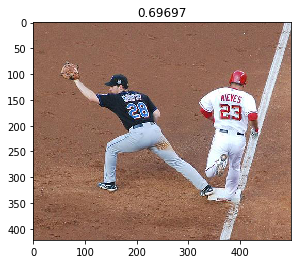

In [0]:
file=""#
def show_sample_from_dataset(i=0):
  global file#
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))

  image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
  file=image_path
  mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
  show_image(io.imread(image_path),mem_val)

show_sample_from_dataset()

In [0]:
from PIL import Image
image=None
def image_loader(loader, image_name):
    global image
    
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print( (resmodel_50(image_loader(data_transforms,file).double().to(device)).cpu().item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.7414350080736298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


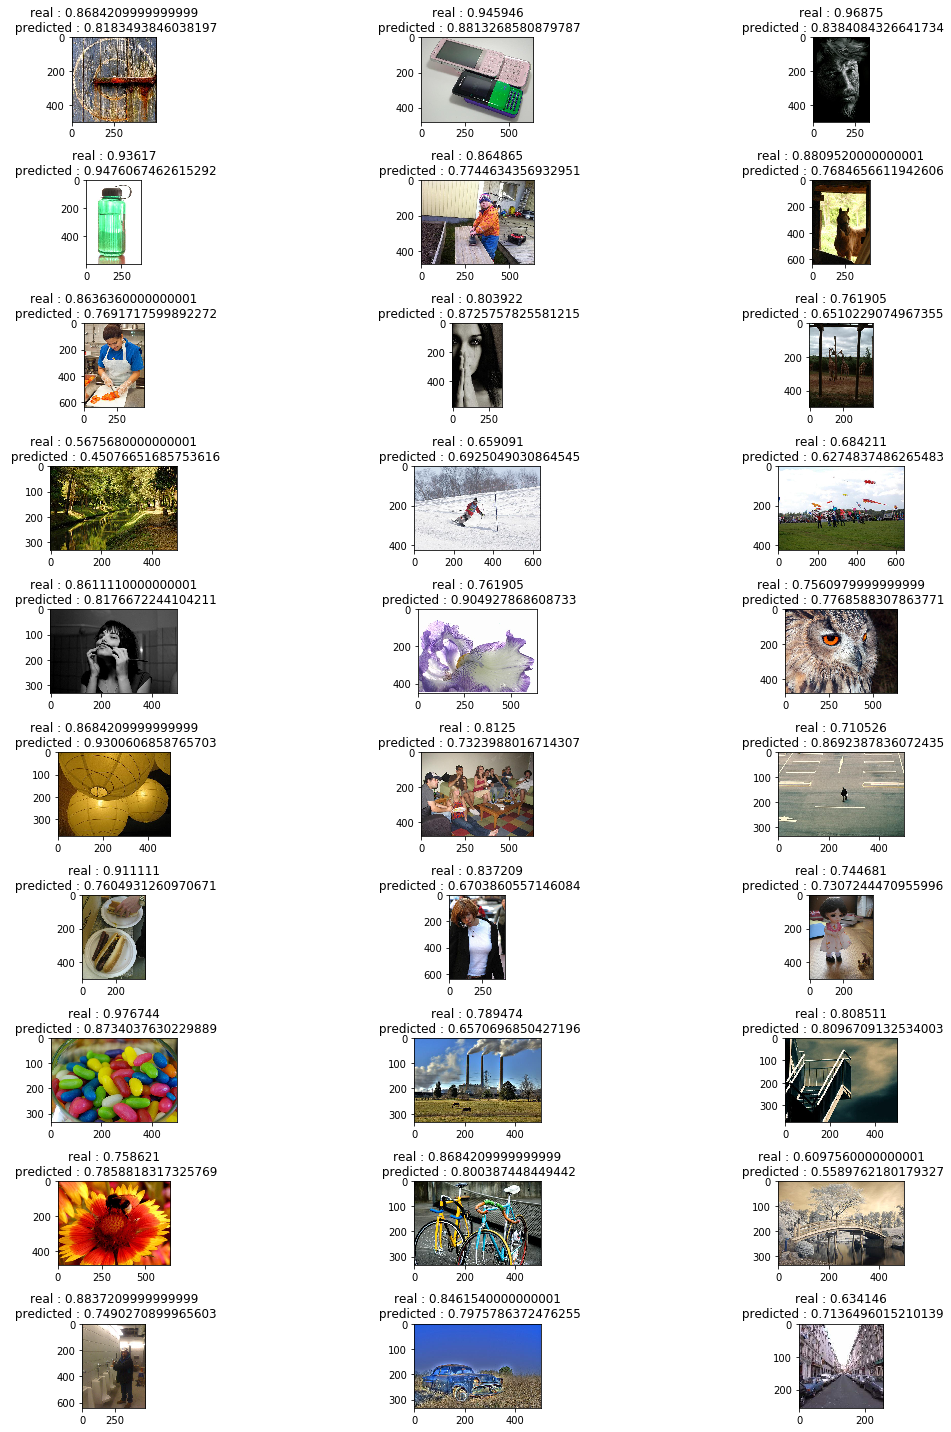

In [0]:

def show_grid(n_row,n_col):
 
  i=220
  _ ,fig = plt.subplots(n_row, n_col, figsize=(20,20))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
    mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
    pred=best_model_50(image_loader(data_transforms,image_path).double().to(device)).cpu().item()
    
    f.imshow(io.imread(image_path))
    plt.tight_layout()
    f.title.set_text("real : "+ str(mem_val)+"\n predicted : "+str(pred))
#     f.title(str(aseth_value))
    i=i+1
show_grid(10,3)

**validation on ResNet50**

In [0]:
# dataset_validation.iloc[i]["y"]

In [0]:
# for i in range(len(dataset_validation)):
  
#   if dataset_validation.iloc[i]["y"] <0.03:
#     image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
#     pred=best_model_50(image_loader(data_transforms,image_path).double().to(device)).cpu().item()
#     print(i,pred)